<a href="https://colab.research.google.com/github/lapidesd/wetted_channels_from_space/blob/main/Colab_notebooks/wetted_channel_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import math
import matplotlib.ticker as ticker
import matplotlib
%config InlineBackend.figure_format='retina'
import imblearn

# Load data


In [198]:
site = 'Ramsey'

In [199]:
# load imagery data
site = 'Ramsey'
if site=='Ramsey':
    df = pd.read_csv('../data/'+site+'/processed_assumptions/processed_with_dates_and_assumptions_drawline.csv')
df['date'] = pd.to_datetime(df.date)
df['date'] = df.date.dt.date
df = df.groupby(['x','y','date']).first().reset_index()

#load hydro data
hydro = pd.read_csv('../data/'+site+'/'+site+'HydroData.csv')
hydro['Unnamed: 0'] = pd.to_datetime(hydro['Unnamed: 0'])
hydro.set_index('Unnamed: 0',inplace=True)

# load imagery metadata
metad = pd.read_csv('../data/'+site+'/'+site+'_imagery_metadata.csv')
metad['acquired'] = pd.to_datetime(metad.acquired)
metad['doy'] = metad.acquired.dt.dayofyear
metad['time'] = metad.acquired.dt.hour
metad['date'] = metad.acquired.dt.date
metad['month'] = metad.acquired.dt.month
metad = metad.groupby('date').first().reset_index()

# load imagery summary data values
imagd = pd.read_csv('../data/'+site+'/'+site+'_imagery_summary_values.csv')
imagd['date'] = pd.to_datetime(imagd['date'],format='%Y%m%d')
imagd['date'] = imagd.date.dt.date
imagd.drop(columns='Unnamed: 0',inplace=True)
imagd = imagd.set_index('date').sort_index().reset_index().groupby('date').first().reset_index()

/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_6323/250899562.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/'+site+'/processed_assumptions/processed_with_dates_and_assumptions_drawline.csv')


## Normalize data values

In [200]:
df = df.merge(imagd,on='date')

for band in ['blue','green','red','NIR']:
    if band=='NIR':
        band1 = 'nir'
    else:
        band1 = band
#     df[band] = (df[band]-df[band1+'1'].median())/(df[band1+'99'].median()-df[band1+'1'].median())
    df[band] = (df[band]-df[band1+'1'])/(df[band1+'99']-df[band1+'1'])

# Random Forest

## make estimator and predictor dataframes, run model

In [201]:
df = df.merge(metad,on='date')

In [202]:
features = ['blue', 'green', 'red', 'NIR', 'NDWI',#'month',
#            'satellite_azimuth',
#             'sun_azimuth','sun_elevation',
#             'view_angle',
           ]
assumptions_use = ['survey/imagery match','assumed perennial','assumed dry','assumed wet'] 
X = df[df.assumption.isin(assumptions_use)][features]
X = X.fillna(X.median())
df['wet'] = np.where(df.wetdry=='wet',1,0)
Y = df[df.assumption.isin(assumptions_use)]['wet']
print('Depth of binary tree on num samples is %.0f'%np.log2(np.shape(X)[0]))

Depth of binary tree on num samples is 15


# Hyperparameter search on max_depth
---

Default parameters (maxdepth = None) are likely the best option as hyperparameter search finds optimal $\mathrm{maxdepth}=30 \gg log_2(N)$, where $N$ is the number of samples. For simplicity, we stick with default hyperparameters.

In [136]:
from sklearn.model_selection import GridSearchCV,\
RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

param_grid = {
    'max_depth': [3, 6, 9, 15, 18, 20, 30, 50],#[400,450,500,550],#
#     [50,75,100,125,150],#
}

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y,
                                                random_state=42)

grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid, n_jobs=-1)
grid_search.fit(Xtrain, ytrain)
print(grid_search.best_estimator_)

/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version 

RandomForestClassifier(max_depth=20)


# get basic fit metrics on train/test split, train model

In [203]:
mdepth=30

In [204]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# X = df[features]
# Y = df[features]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y,
                                                random_state=42)

test_model = RandomForestClassifier(random_state=42)
test_model.fit(Xtrain, ytrain)

## FINAL MODEL TRAINED ON ALL DATA

model = RandomForestClassifier(random_state=42,max_depth=mdepth, )#class_weight='balanced')
model.fit(X, Y)
# feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns
ypred = model.predict(Xtest)

In [205]:
dd = Xtest.copy()
dd['predict'] = ypred
dd['actual'] = test_model.predict(Xtest)

print('test accuracy:',len(dd[(dd.predict==dd.actual)])/len(dd))
print('accuracy wet:',len(dd[(dd.predict==1)&(dd.actual==1)])/len(dd[dd.actual==1]))
print('accuracy dry:',len(dd[(dd.predict==0)&(dd.actual==0)])/len(dd[dd.actual==0]))


test accuracy: 0.9391236306729265
accuracy wet: 0.7987012987012987
accuracy dry: 0.9500674763832658


In [206]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())
def class_accuracy(m,x,y,c): return m.score(x[y==c],y[y==c])
def balanced_accuracy(m,x,y): return np.mean([class_accuracy(m,x,y,0),
                                             class_accuracy(m,x,y,1)])


def print_score(m,Xtrain=Xtrain,ytrain=ytrain,Xtest=Xtest,ytest=ytest):
    res = [rmse(m.predict(Xtrain), ytrain), rmse(m.predict(Xtest), ytest),
                balanced_accuracy(m,Xtrain,ytrain),
                balanced_accuracy(m,Xtest,ytest)]
#     if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print('RMSE on training set, RMSE on test set, accuracy with training set, accuracy with test set')#,oobscore(optional)')
    print(res)
    res1 = [class_accuracy(m,Xtrain,ytrain,0),
           class_accuracy(m,Xtrain,ytrain,1),
           class_accuracy(m,Xtest,ytest,0),
           class_accuracy(m,Xtest,ytest,1)]
          
    print('Accuracy dry train, Accuracy wet train, Accuracy dry test, Accuracy wet test')
    print(res1)

print_score(test_model)

RMSE on training set, RMSE on test set, accuracy with training set, accuracy with test set
[0.0, 0.24673137078019397, 1.0, 0.7693213382801983]
Accuracy dry train, Accuracy wet train, Accuracy dry test, Accuracy wet test
[1.0, 1.0, 0.9837554585152839, 0.5548872180451128]


In [141]:
Xtest['predict'] = ypred
Xtest['actual'] = ytest
label = 1
len(Xtest[(Xtest.predict==label)&(Xtest.actual==label)])/len(Xtest[Xtest.actual==label])
Xtest = Xtest.drop(columns=['predict','actual'])

5632 0.5 0.5
296 1.5 0.5
93 0.5 1.5
369 1.5 1.5


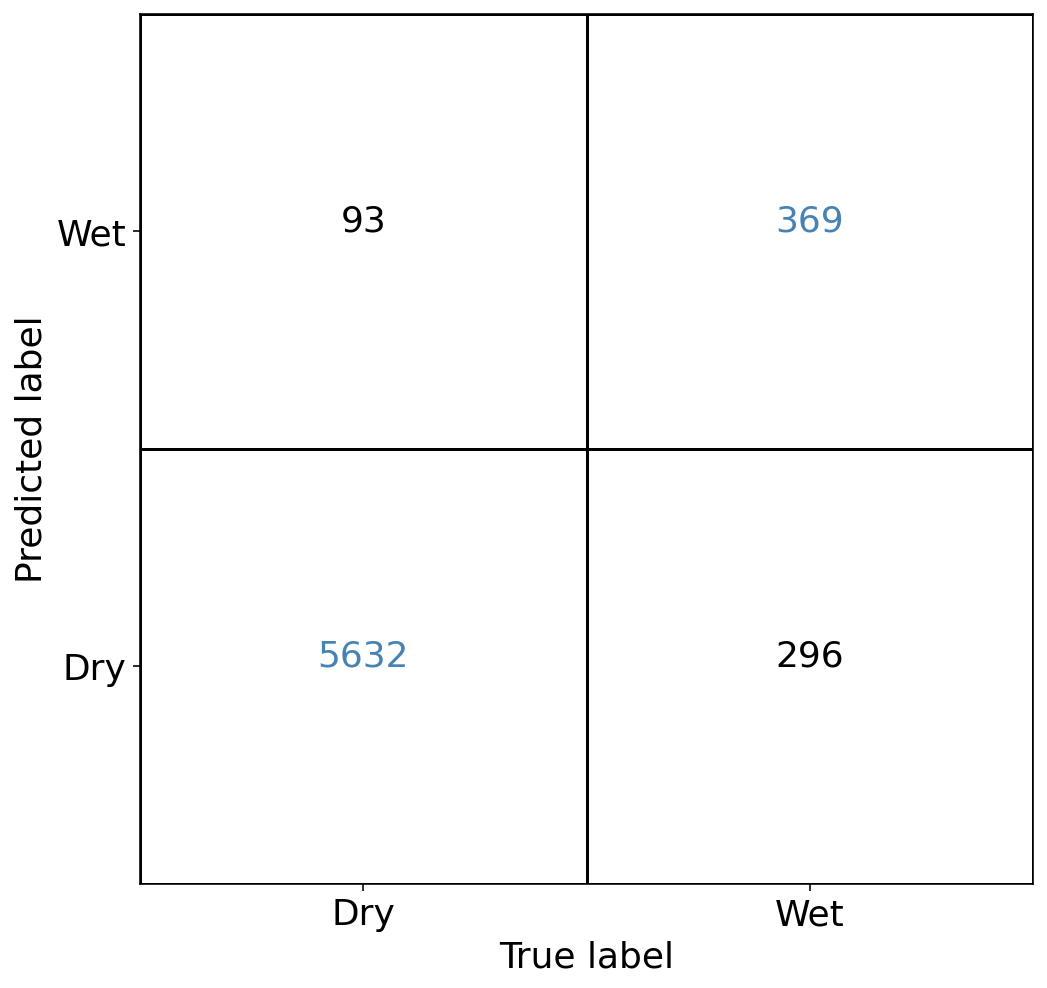

In [142]:
# confusion matrix on test data

from sklearn.metrics import confusion_matrix
# !pip install seaborn
import seaborn as sns

plt.rcParams.update({'font.size': 18})

ytest_predict = test_model.predict(Xtest)
mat = confusion_matrix(ytest, ytest_predict)
f,ax = plt.subplots(1, figsize = (8,8))
# ax.imshow([[1,0],[0,1]],cmap='Blues')

xlocs = [0.5,1.5,0.5,1.5]
ylocs = [0.5,0.5,1.5,1.5,]
colors = ['steelblue','k','k','steelblue',]
for i in range(len(mat.T.flatten())):
  t = mat.T.flatten()[i]
  xloc = xlocs[i]
  yloc = ylocs[i]
  color = colors[i]
  print(t,xloc,yloc)
  ax.text(xloc,yloc,t,ha='center',
          c=color,)

ax.set_xlabel('True label')
ax.set_ylabel('Predicted label')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['Dry','Wet'])
ax.set_yticks([1.5,0.5])
ax.set_yticklabels(['Wet','Dry'])
for x in [0,1,2]:
  ax.plot([x,x],[0,2],c='k')
for y in [0,1,2]:
  ax.plot([0,2],[y,y],c='k')
ax.set_xlim(0,2)
ax.set_ylim(0,2)
plt.savefig('correlation_matrix.pdf',format='pdf')

## Try undersampling

In [102]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y,
                                                random_state=42)

# random undersampling
# import library
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(Xtrain, Ytrain)


# import library
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler

tl = RandomUnderSampler(sampling_strategy='majority')

# fit predictor and target variable
x_tl, y_tl = tl.fit_resample(Xtrain, Ytrain)

# import library
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
x_ros, y_ros = ros.fit_resample(Xtrain, Ytrain)

# import library
from imblearn.over_sampling import SMOTE

smote = SMOTE()


# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(Xtrain, Ytrain)


x, y = x_tl, y_tl

test_model = RandomForestClassifier(random_state=42)
test_model.fit(x, y)

# ## FINAL MODEL TRAINED ON ALL DATA

# model = RandomForestClassifier(random_state=42,max_depth=mdepth)
# model.fit(x, y)
# # feature_names = [f"feature {i}" for i in range(X.shape[1])]
# feature_names = Xtrain.columns
# ypred = test_model.predict(Xtest)



RandomForestClassifier(random_state=42)

In [103]:
dd = Xtest.copy()
dd['predict'] = test_model.predict(Xtest)
dd['actual'] = Ytest

print('test accuracy:',len(dd[(dd.predict==dd.actual)])/len(dd))
print('accuracy wet:',len(dd[(dd.predict==1)&(dd.actual==1)])/len(dd[dd.actual==1]))
print('accuracy dry:',len(dd[(dd.predict==0)&(dd.actual==0)])/len(dd[dd.actual==0]))


test accuracy: 0.8674930797929955
accuracy wet: 0.8067910090865614
accuracy dry: 0.8879060791251207


In [151]:
# def rmse(x,y): return math.sqrt(((x-y)**2).mean())

# def print_score(m,Xtrain=Xtrain,ytrain=ytrain,Xtest=Xtest,ytest=ytest):
#     res = [rmse(m.predict(Xtrain), ytrain), rmse(m.predict(Xtest), ytest),
#                 np.mean([m.score(Xtrain[ytrain==0], ytrain[ytrain==0]),m.score(Xtrain[ytrain==1], ytrain[ytrain==1])]),
#                np.mean([m.score(Xtest[ytest==0], ytest[ytest==0]),m.score(Xtest[ytest==1],ytest[ytest==1])])]
#     if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
#     print('RMSE on training set, RMSE on test set, accuracy with training set, accuracy with test set,oobscore(optional)')
#     print(res)

print_score(test_model)

RMSE on training set, RMSE on test set, accuracy with training set, accuracy with test set,oobscore(optional)
[0.0, 0.24673137078019397, 1.0, 0.7693213382801983]


In [47]:
Xtest['predict'] = ypred
Xtest['actual'] = ytest
label = 1
len(Xtest[(Xtest.predict==label)&(Xtest.actual==label)])/len(Xtest[Xtest.actual==label])
Xtest = Xtest.drop(columns=['predict','actual'])

5791 0.5 0.5
508 1.5 0.5
427 0.5 1.5
1583 1.5 1.5


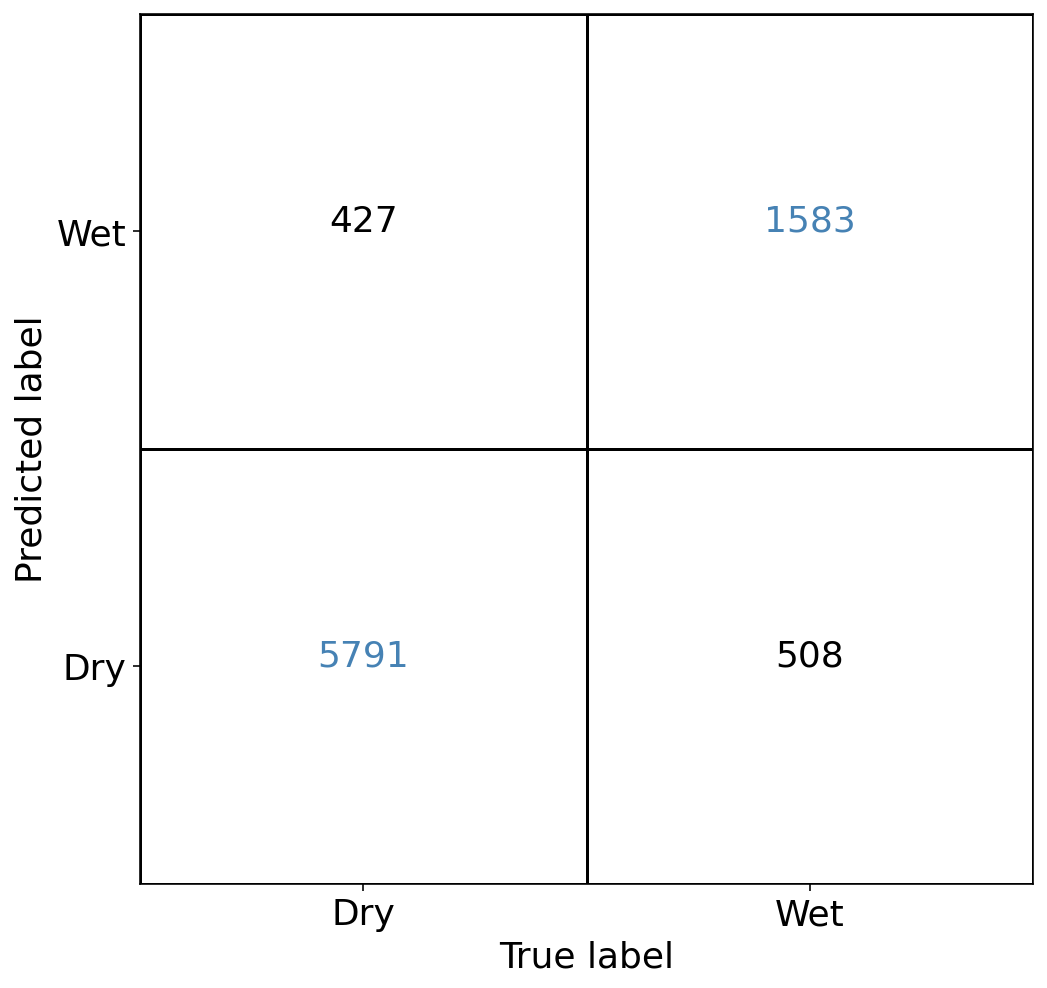

In [97]:
# confusion matrix on test data

from sklearn.metrics import confusion_matrix
# !pip install seaborn
import seaborn as sns

plt.rcParams.update({'font.size': 18})

ytest_predict = test_model.predict(Xtest)
mat = confusion_matrix(ytest, ytest_predict)
f,ax = plt.subplots(1, figsize = (8,8))
# ax.imshow([[1,0],[0,1]],cmap='Blues')

xlocs = [0.5,1.5,0.5,1.5]
ylocs = [0.5,0.5,1.5,1.5,]
colors = ['steelblue','k','k','steelblue',]
for i in range(len(mat.T.flatten())):
  t = mat.T.flatten()[i]
  xloc = xlocs[i]
  yloc = ylocs[i]
  color = colors[i]
  print(t,xloc,yloc)
  ax.text(xloc,yloc,t,ha='center',
          c=color,)

ax.set_xlabel('True label')
ax.set_ylabel('Predicted label')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['Dry','Wet'])
ax.set_yticks([1.5,0.5])
ax.set_yticklabels(['Wet','Dry'])
for x in [0,1,2]:
  ax.plot([x,x],[0,2],c='k')
for y in [0,1,2]:
  ax.plot([0,2],[y,y],c='k')
ax.set_xlim(0,2)
ax.set_ylim(0,2)
plt.savefig('correlation_matrix.pdf',format='pdf')

## Try ensemble approach

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# X = df[features]
# Y = df[features]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y,
                                                random_state=42)

ytrain_wet = ytrain[ytrain==1]
Xtrain_wet = Xtrain[ytrain==1]
ytrain_dry = ytrain[ytrain==0]
Xtrain_dry = Xtrain[ytrain==0]




num = round(len(Xtrain_dry)/3)
test_models = []
for i in range(3):
    test_model = RandomForestClassifier(random_state=42)
    Xtrain1 = pd.concat([Xtrain_wet,Xtrain_dry.iloc[i*num:(i+1)*num]])
    ytrain1 = pd.concat([ytrain_wet,ytrain_dry.iloc[i*num:(i+1)*num]])
    test_model.fit(Xtrain1, ytrain1)
    test_models.append(test_model)

def run_ensemble(models,X):
    ps = {i:m.predict(X) for i,m in enumerate(models)}
    ps = pd.DataFrame.from_dict(ps)
    ps = ps.mean(axis=1).round()
    return(ps)


# ## FINAL MODEL TRAINED ON ALL DATA

model = RandomForestClassifier(random_state=42,max_depth=mdepth, )#class_weight='balanced')

X_dry = X[Y==0]
X_wet = X[Y==1]
Y_dry = Y[Y==0]
Y_wet = Y[Y==1]

num = round(len(X_dry)/3)
models = []
for i in range(3):
    model = RandomForestClassifier(random_state=42)
    Xtrain1 = pd.concat([X_wet,X_dry.iloc[i*num:(i+1)*num]])
    ytrain1 = pd.concat([Y_wet,Y_dry.iloc[i*num:(i+1)*num]])
    model.fit(Xtrain1, ytrain1)
    models.append(model)

feature_names = X.columns
ypred = run_ensemble(models,X)

In [105]:
dd = Xtest.copy()
dd['predict'] = run_ensemble(test_models,Xtest).values
dd['actual'] = ytest

print('test accuracy:',len(dd[(dd.predict==dd.actual)])/len(dd))
print('accuracy wet:',len(dd[(dd.predict==1)&(dd.actual==1)])/len(dd[dd.actual==1]))
print('accuracy dry:',len(dd[(dd.predict==0)&(dd.actual==0)])/len(dd[dd.actual==0]))

test accuracy: 0.8712239740040919
accuracy wet: 0.8015303682448589
accuracy dry: 0.8946606625924735


5563 0.5 0.5
415 1.5 0.5
655 0.5 1.5
1676 1.5 1.5


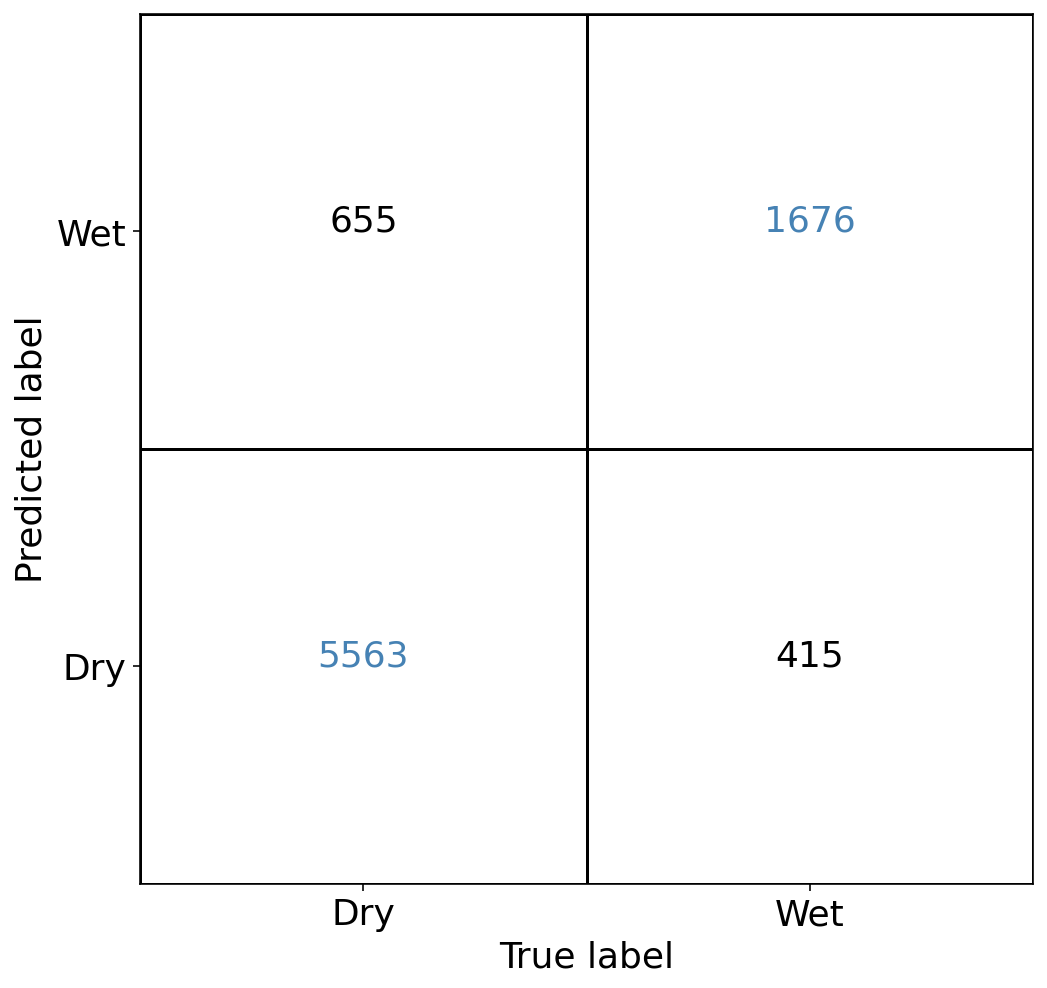

In [108]:
# confusion matrix on test data

from sklearn.metrics import confusion_matrix
# !pip install seaborn
import seaborn as sns

plt.rcParams.update({'font.size': 18})

ytest_predict = run_ensemble(test_models,Xtest)
mat = confusion_matrix(ytest, ytest_predict)
f,ax = plt.subplots(1, figsize = (8,8))
# ax.imshow([[1,0],[0,1]],cmap='Blues')

xlocs = [0.5,1.5,0.5,1.5]
ylocs = [0.5,0.5,1.5,1.5,]
colors = ['steelblue','k','k','steelblue',]
for i in range(len(mat.T.flatten())):
  t = mat.T.flatten()[i]
  xloc = xlocs[i]
  yloc = ylocs[i]
  color = colors[i]
  print(t,xloc,yloc)
  ax.text(xloc,yloc,t,ha='center',
          c=color,)

ax.set_xlabel('True label')
ax.set_ylabel('Predicted label')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['Dry','Wet'])
ax.set_yticks([1.5,0.5])
ax.set_yticklabels(['Wet','Dry'])
for x in [0,1,2]:
  ax.plot([x,x],[0,2],c='k')
for y in [0,1,2]:
  ax.plot([0,2],[y,y],c='k')
ax.set_xlim(0,2)
ax.set_ylim(0,2)
plt.savefig('correlation_matrix.pdf',format='pdf')

###  Explore accuracy of leave-one-date-out train-test splits


In [152]:
subset = df
dates = set(subset.date)
subset['date'] = pd.to_datetime(subset.date)
assumptions = df.assumption.unique()

date_accuracy = {}

for date in assumptions:
  print(date)
  mask_test1 = ''
  sub1 = subset.set_index('date').sort_index().reset_index()
  numscenes = 0
  mask_test = (sub1.assumption==date)
  if date=='survey/imagery match':
      mask_test1 = (mask_test) | (sub1.assumption=='assumed dry') | (sub1.assumption=='assumed wet')
  else:
      mask_test1 = mask_test

  Xtrain_date = sub1[~mask_test1][features]
  Xtest_date = sub1[mask_test][features]
  # print(len(Xtest_date))

  ytrain_date = sub1[~mask_test1]['wet']
  ytest_date = sub1[mask_test]['wet']
  date_model = RandomForestClassifier(random_state=42,max_depth=mdepth)
  date_model.fit(Xtrain_date, ytrain_date)
  try:
    if 'wet' in date:
        date_accuracy.update({date: date_model.score(Xtest_date, ytest_date)})
    elif 'dry' in date:
        date_accuracy.update({date: date_model.score(Xtest_date, ytest_date)})
    elif 'perennial' in date:
        date_accuracy.update({date: date_model.score(Xtest_date, ytest_date)})
    else:
        date_accuracy.update({date: np.mean([date_model.score(Xtest_date[ytest_date==0], ytest_date[ytest_date==0]),
                                         date_model.score(Xtest_date[ytest_date==1], ytest_date[ytest_date==1])])})
  except:
    print(date,'BROKEN')

survey/imagery match
assumed wet
assumed dry
assumed perennial


In [153]:
date_accuracy.update({'75% of all data as train, 25% as test':test_model.score(Xtest, ytest)})
date_accuracy

{'survey/imagery match': 0.5,
 'assumed wet': 0.8181818181818182,
 'assumed dry': 0.8006263631787931,
 'assumed perennial': 0.02155365963179165,
 '75% of all data as train, 25% as test': 0.9391236306729265}

In [250]:
ss = sub1[sub1.date=='2018-06-23']

len(ss[ss.y<splitval])/len(ss)

0.10358565737051793

In [154]:
# do comparison from leaving out a single reach

splitval = 3476835
mask_test1 = ''
sub1 = subset.set_index('date').sort_index().reset_index()
numscenes = 0
mask_test = (sub1.y<splitval)
mask_test1 = mask_test

Xtrain_date = sub1[~mask_test1][features]
Xtest_date = sub1[mask_test][features]
# print(len(Xtest_date))

ytrain_date = sub1[~mask_test1]['wet']
ytest_date = sub1[mask_test]['wet']
date_model = RandomForestClassifier(random_state=42,max_depth=mdepth)
date_model.fit(Xtrain_date, ytrain_date)
print(np.mean([date_model.score(Xtest_date[ytest_date==0], ytest_date[ytest_date==0]),
               date_model.score(Xtest_date[ytest_date==1],ytest_date[ytest_date==1])]))

0.49871299871299873


# Permutation importance

In [143]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    model, X, Y, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)



/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core

Elapsed time to compute the importances: 6.645 seconds


5632 0.5 0.5
296 1.5 0.5
93 0.5 1.5
369 1.5 1.5


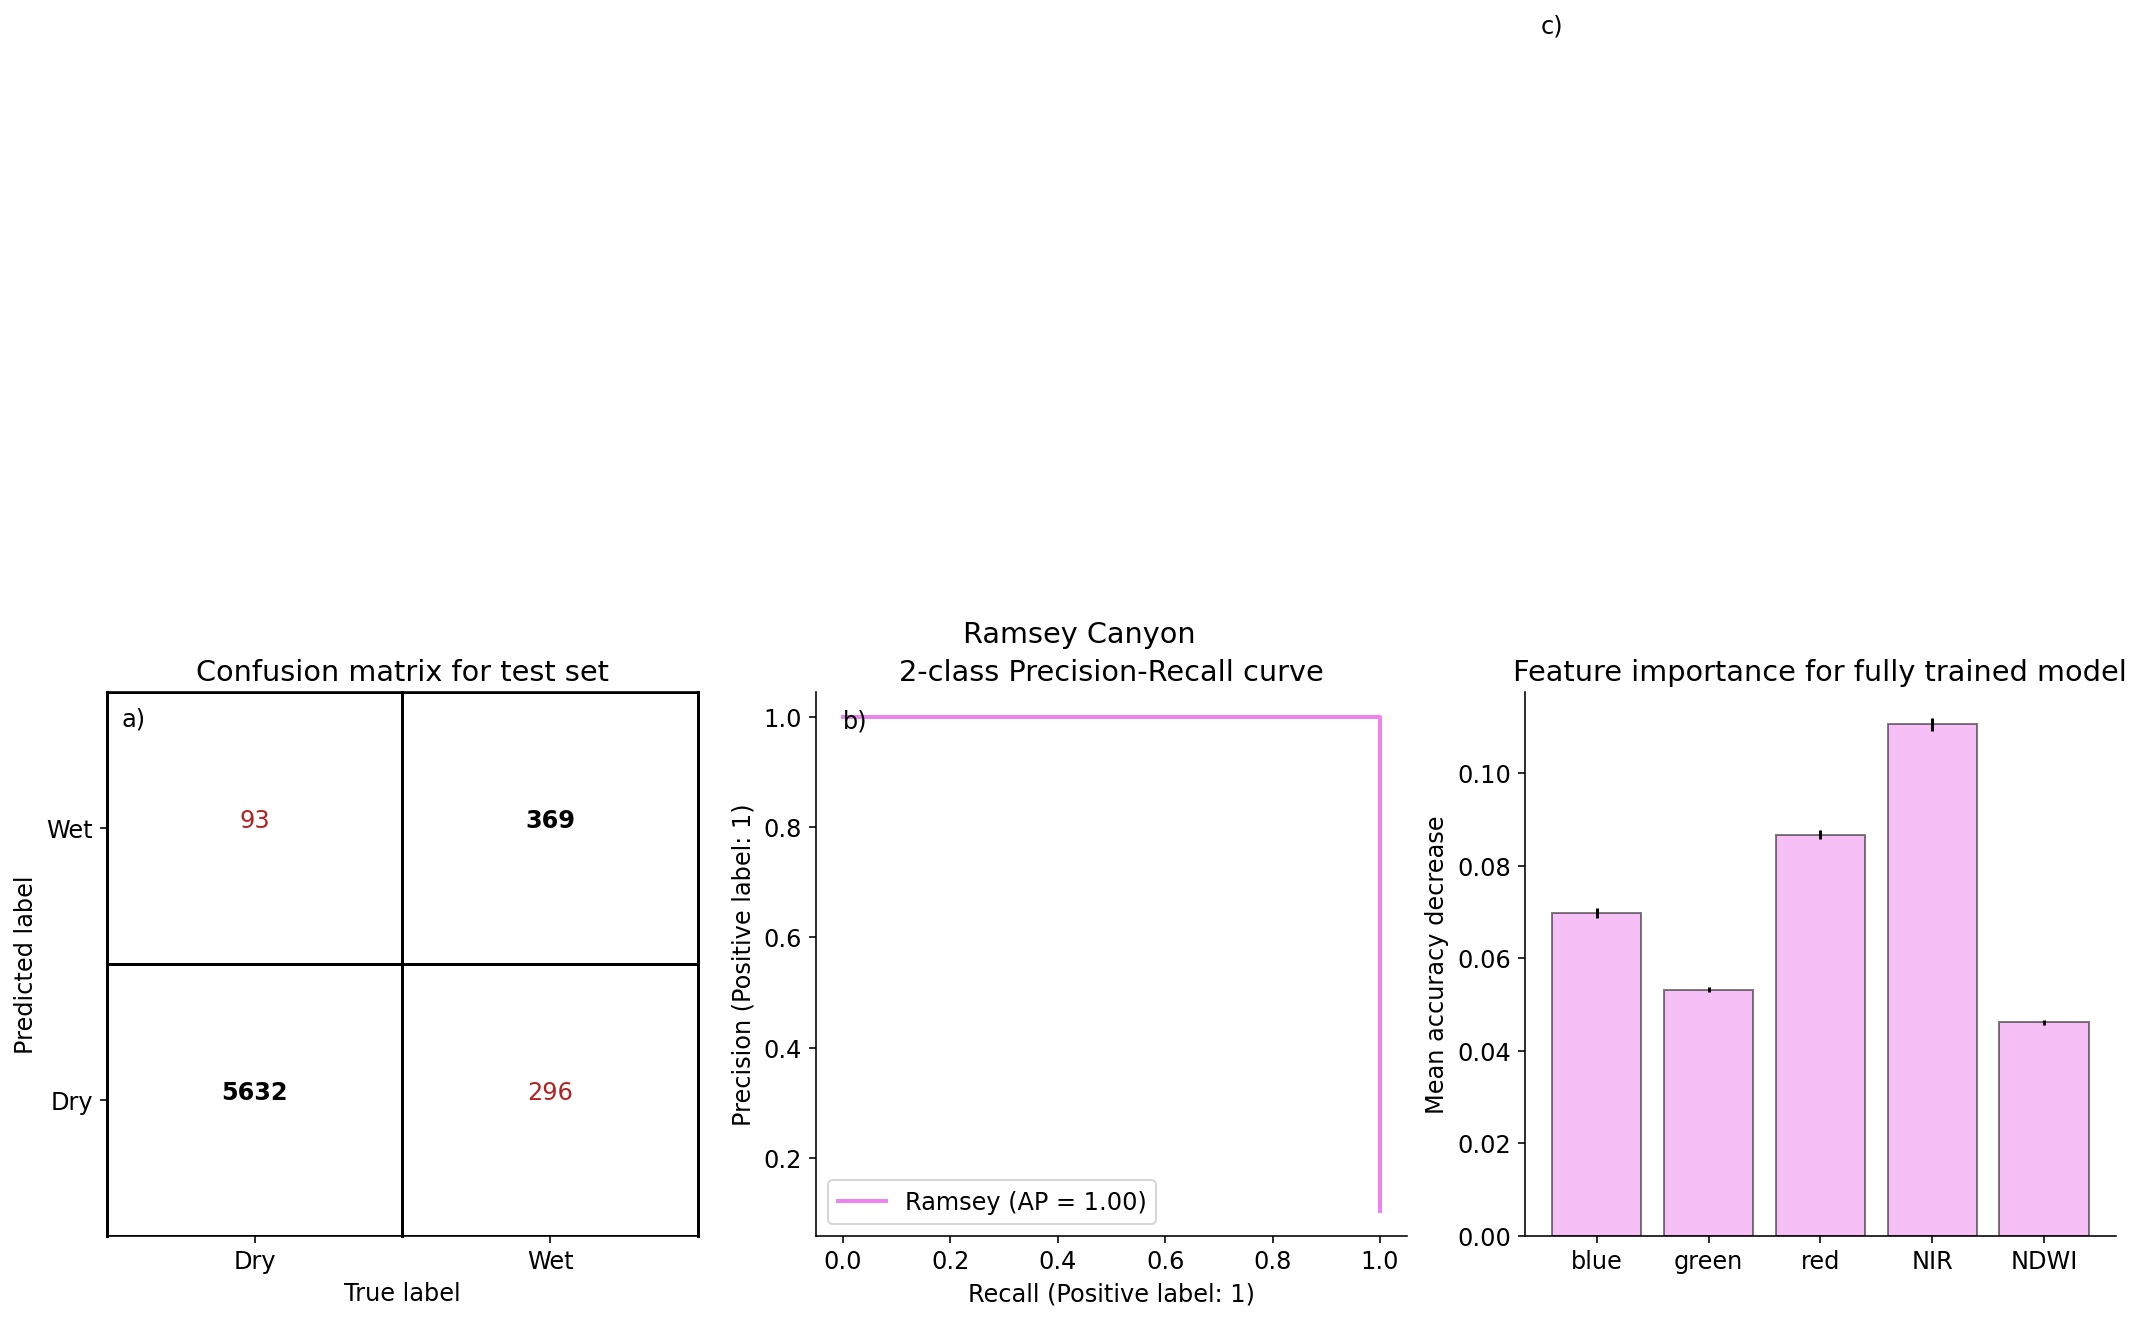

In [144]:
# confusion matrix with feature importance

# Manuscript figure; confusion matrix on test data

plt.rcParams.update({'font.size': 12})

ytest_predict = test_model.predict(Xtest)
mat = confusion_matrix(ytest, ytest_predict)


f,axs = plt.subplots(1, 3, figsize = (18,5))

ax = axs[0]
# sns.heatmap([[1,0],[0,1]], square=True, annot=False,fmt='d',
#             cbar=False,ax=ax, cmap='Blues')

xlocs = [0.5,1.5,0.5,1.5]
ylocs = [0.5,0.5,1.5,1.5,]
colors = ['k','firebrick','firebrick','k',]
for i in range(len(mat.T.flatten())):
  t = mat.T.flatten()[i]
  xloc = xlocs[i]
  yloc = ylocs[i]
  color = colors[i]
  print(t,xloc,yloc)
  if color==colors[1]:
        ax.text(xloc,yloc,t,ha='center',
          c=color,)
  else:
    ax.text(xloc,yloc,t,ha='center',
          c=color,weight='demibold')

ax.set_xlabel('True label')
ax.set_ylabel('Predicted label')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['Dry','Wet'])
ax.set_yticks([1.5,0.5])
ax.set_yticklabels(['Wet','Dry'])
for x in [0,1,2]:
  ax.plot([x,x],[0,2],c='k',clip_on=False)
for y in [0,1,2]:
  ax.plot([0,2],[y,y],c='k')
ax.set_title('Confusion matrix for test set')
ax.text(.05,1.875,'a)',c='k')
ax.set_xlim(0,2)
ax.set_ylim(0,2)

ax = axs[2]

labels = features#['Blue','Green','Red','NIR','NDWI',]#'Area']
ax.bar(labels,forest_importances.values,
       yerr = result.importances_std,
       edgecolor = 'k',facecolor = 'violet',alpha=.5)
ax.set_title("Feature importance for fully trained model")
ax.set_ylabel("Mean accuracy decrease")
ax.text(-.5,0.26,'c)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = axs[1]
from sklearn.metrics import PrecisionRecallDisplay
# fig,ax = plt.subplots(1)
display = PrecisionRecallDisplay.from_estimator(
    model, Xtest, ytest, name="Ramsey", ax=ax, c = 'violet',lw=2
)
_ = display.ax_.set_title("2-class Precision-Recall curve")
ax.spines[['top','right']].set_visible(False)
ax.text(0,.98,'b)')

# fig.tight_layout()

f.suptitle('Ramsey Canyon')
plt.savefig('confusion_and_importance_ramsey.pdf',format='pdf',bbox_inches='tight')

In [352]:
len(df.date.unique())##[(df.assumption=='assumed wet')&(df.wet==1)]

1137

In [304]:
forest_importances#.values, labels, result.importances_std

blue     0.119815
green    0.132778
red      0.153522
NIR      0.264171
NDWI     0.077077
dtype: float64

# make some maps

In [145]:
len(df),len(X)

(25558, 25558)

In [146]:
ypred_all = test_model.predict(df[features])
df['prediction'] = ypred_all

In [147]:
df[df.assumption=='survey/imagery match'].date.unique()

array([datetime.date(2022, 6, 13), datetime.date(2018, 6, 23),
       datetime.date(2020, 6, 15), datetime.date(2019, 6, 15),
       datetime.date(2023, 6, 13), datetime.date(2021, 6, 16)],
      dtype=object)

In [148]:
df

x             y        date  \
0      562749.27889  3.477383e+06  2022-06-13   
1      562753.15280  3.477383e+06  2022-06-13   
2      562758.07943  3.477382e+06  2022-06-13   
3      562763.00607  3.477381e+06  2022-06-13   
4      562767.93271  3.477380e+06  2022-06-13   
...             ...           ...         ...   
25553  565823.62753  3.479456e+06  2023-07-04   
25554  565823.62753  3.479456e+06  2023-07-05   
25555  565823.62753  3.479456e+06  2023-07-06   
25556  565823.62753  3.479456e+06  2023-07-07   
25557  565823.62753  3.479456e+06  2023-07-08   

                                         geometry_x wetdry  \
0      POINT (562749.2788896125 3477383.2291790517)    dry   
1        POINT (562753.152797671 3477382.558155245)    dry   
2      POINT (562758.0794348125 3477381.7047816603)    dry   
3      POINT (562763.0060719542 3477380.8514080755)    dry   
4      POINT (562767.9327090957 3477379.9980344903)    dry   
...                                             ...    ...   
25553  POINT (565823.6275333037 3479456.4153816323)    dry   
25554  POINT (565823.6275333037 3479456.4153816323)    dry   
25555  POINT (565823.6275333037 3479456.4153816323)    dry   
25556  POINT (565823.6275333037 3479456.4153816323)    dry   
25557  POINT (565823.6275333037 3479456.4153816323)    dry   

                 assumption     Imagery  date_first      blue     green  ...  \
0      survey/imagery match  2022-06-13        None  0.073254  0.321402  ...   
1      survey/imagery match  2022-06-13        None  0.087632  0.343499  ...   
2      survey/imagery match  2022-06-13        None  0.120767  0.379503  ...   
3      survey/imagery match  2022-06-13        None  0.122095  0.375527  ...   
4      survey/imagery match  2022-06-13        None  0.120767  0.372763  ...   
...                     ...         ...         ...       ...       ...  ...   
25553           assumed dry        None  2023-07-04  0.289421  0.435497  ...   
25554           assumed dry        None  2023-07-05  0.680102  0.690855  ...   
25555           assumed dry        None  2023-07-06  0.219387  0.465318  ...   
25556           assumed dry        None  2023-07-07  0.453526  0.599732  ...   
25557           assumed dry        None  2023-07-08  0.332198  0.552684  ...   

       satellite_azimuth  satellite_id  sun_azimuth  sun_elevation  \
0                  276.2          249c        103.5           66.0   
1                  276.2          249c        103.5           66.0   
2                  276.2          249c        103.5           66.0   
3                  276.2          249c        103.5           66.0   
4                  276.2          249c        103.5           66.0   
...                  ...           ...          ...            ...   
25553              276.9          2461        104.8           66.0   
25554              100.1          242b         96.4           57.5   
25555              277.3          241e         97.6           58.3   
25556              273.4          24a9         98.3           58.7   
25557              276.9          24bc         98.5           58.8   

       view_angle  doy  time  month  wet  prediction  
0             3.2  164    17      6    0           0  
1             3.2  164    17      6    0           0  
2             3.2  164    17      6    0           0  
3             3.2  164    17      6    0           0  
4             3.2  164    17      6    0           0  
...           ...  ...   ...    ...  ...         ...  
25553         4.1  185    17      7    0           0  
25554         4.8  186    17      7    0           0  
25555         5.0  187    17      7    0           0  
25556         1.7  188    17      7    0           0  
25557         5.0  189    17      7    0           0  

[25558 rows x 35 columns]

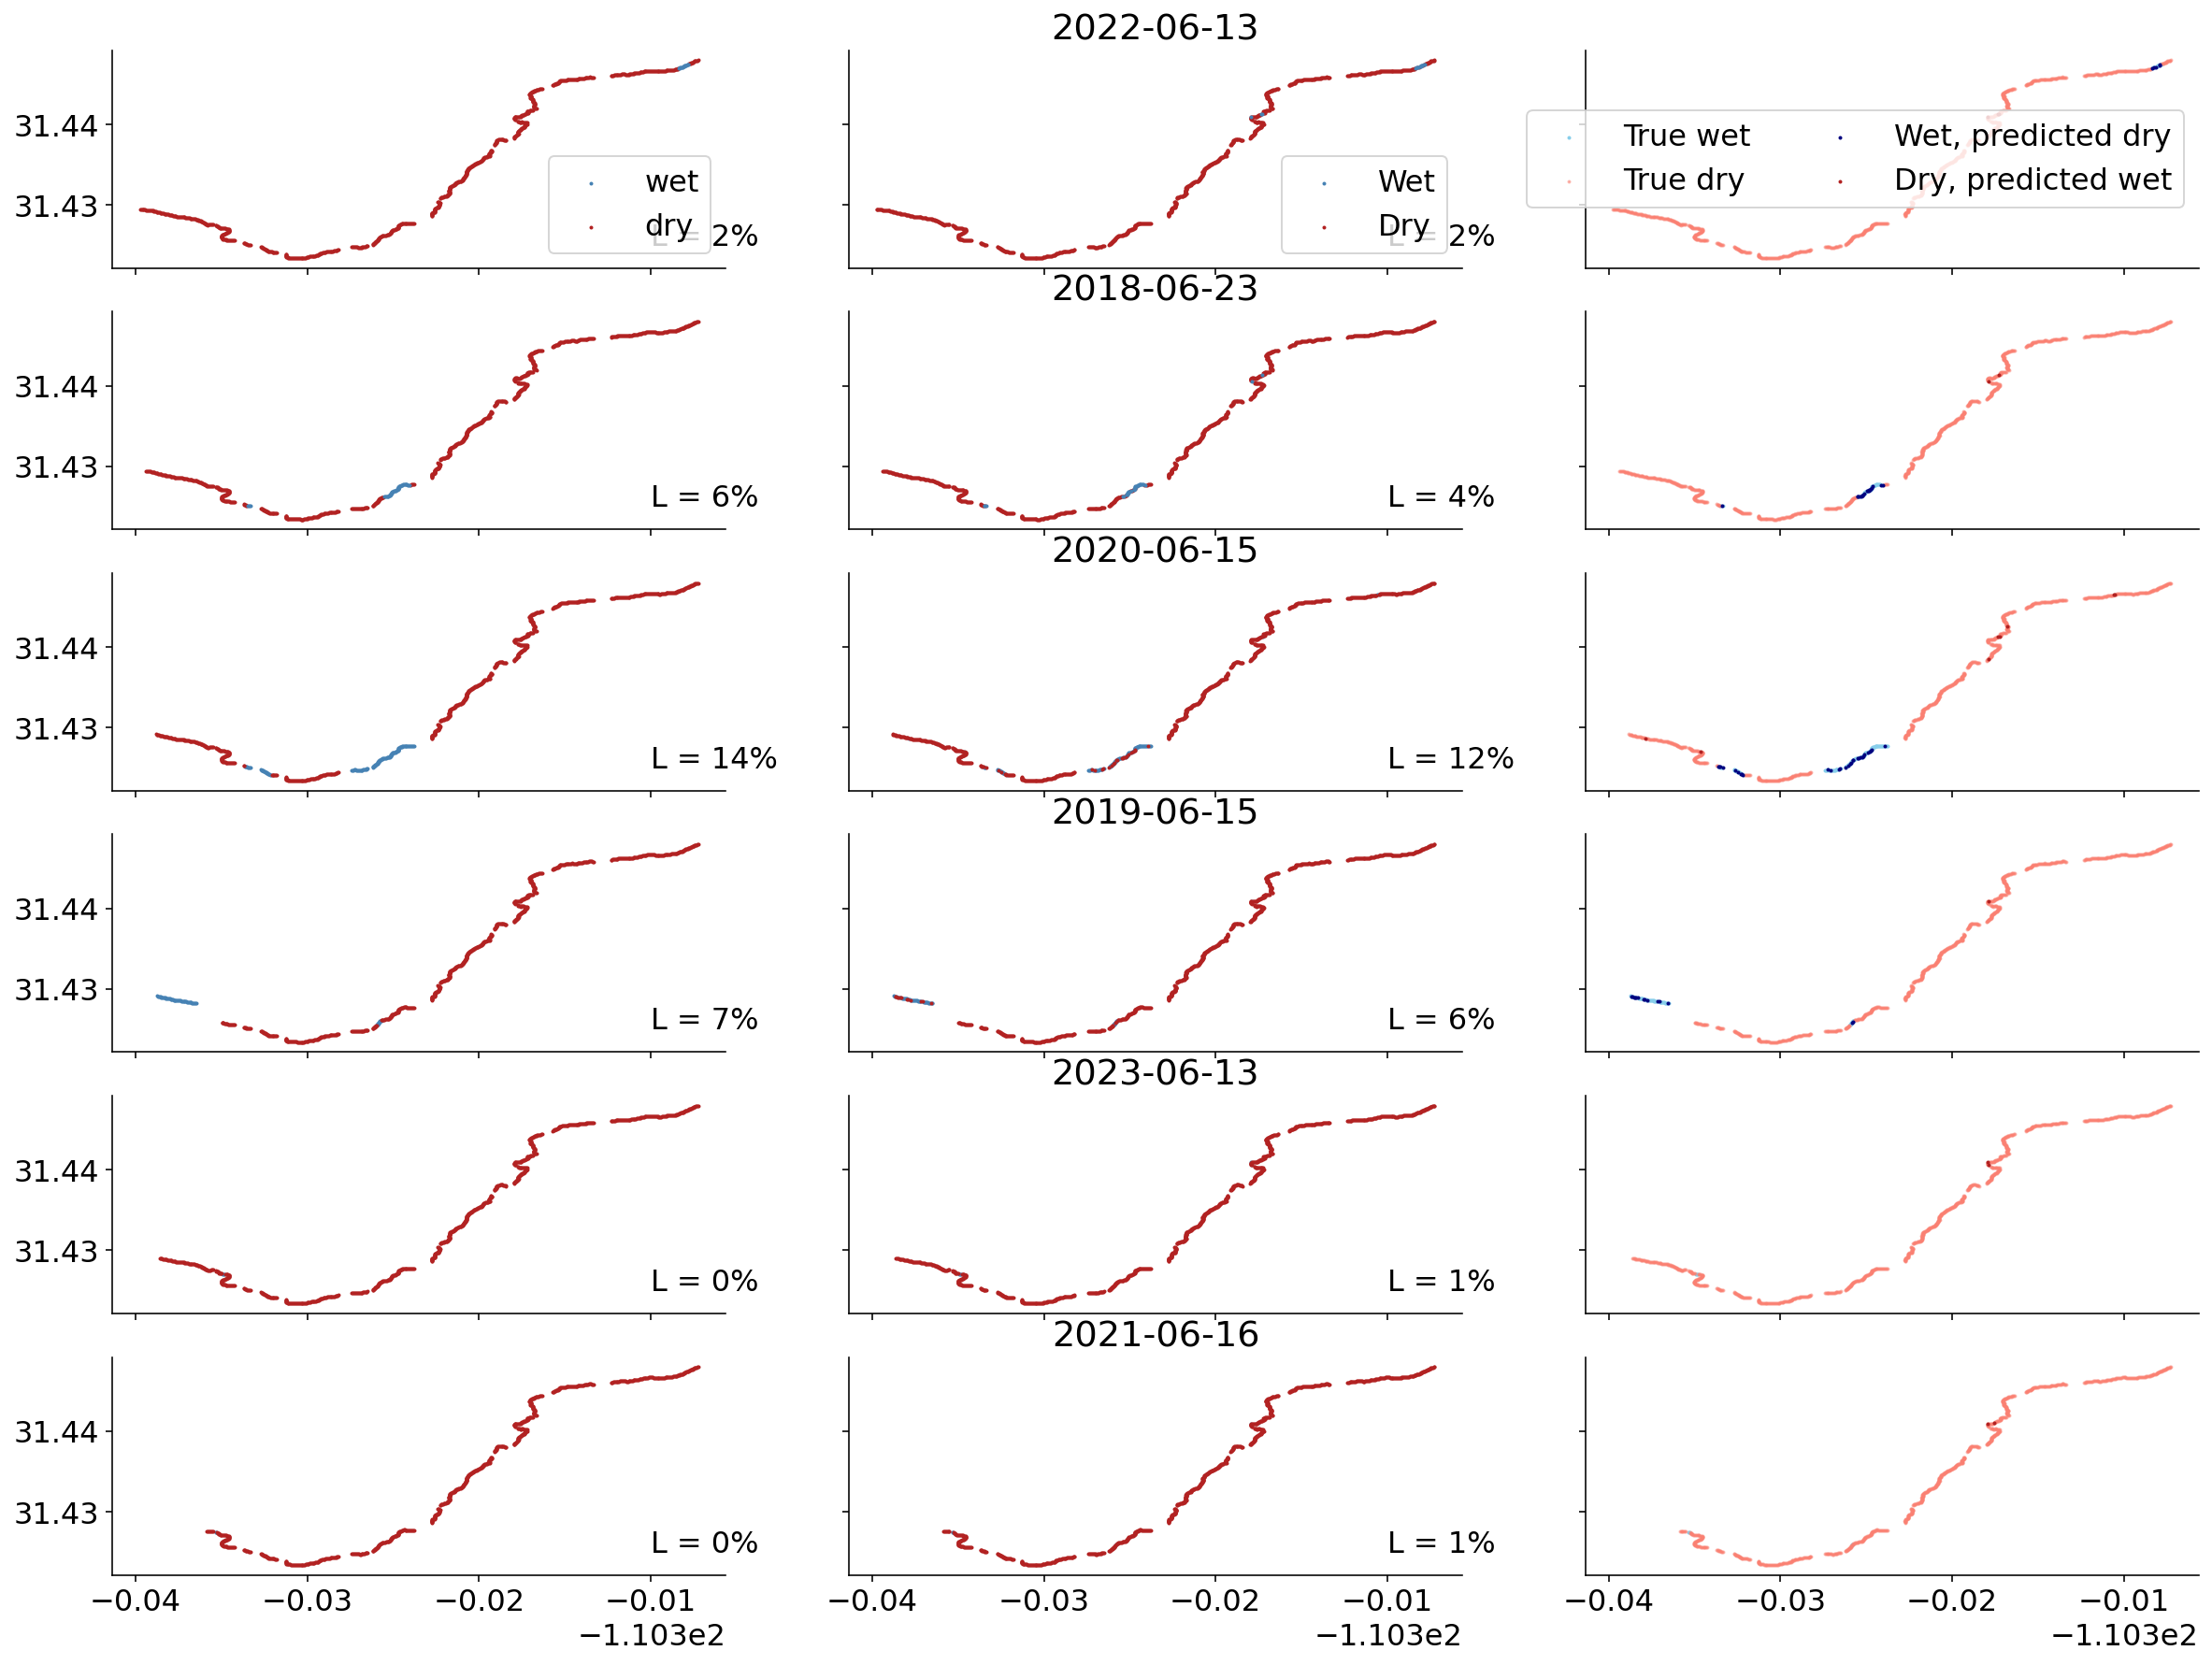

In [149]:
import matplotlib as mpl
import geopandas as gpd

size = 1

plt.rcParams.update({'font.size': 16})

fig,axs = plt.subplots(6,3,figsize = (20,15),
                       sharex=True,
                       sharey=True)
subset = df

xv,yv = -110.31,31.425

i=0
for date in df[df.assumption=='survey/imagery match'].date.unique():#subset.date.drop_duplicates().values[:4]:
  dfsub = subset[subset.date==date]
  if date=='2018-02-12':
    dfsub = dfsub[dfsub.area_updated<=20000]
  dfsub = dfsub.drop_duplicates()
  dfsub = gpd.GeoDataFrame(
    dfsub, geometry=gpd.points_from_xy(dfsub.x, dfsub.y), crs="EPSG:26912"
)
  dfsub = dfsub.to_crs('EPSG:4326')
  dfsub['x'] = dfsub.geometry.x
  dfsub['y'] = dfsub.geometry.y

  ax = axs[i,0]
  if i>1:
    zorder = -1
    zord1 = 100
  else:
    zorder = 100
    zord1 = -1
  dfsub2 = dfsub[(dfsub.wet==1)]
  pwet = len(dfsub2)/len(dfsub)*100
  ax.scatter(dfsub2.x,dfsub2.y,c='steelblue',
             s=size,label='wet',zorder=zorder)
  dfsub2 = dfsub[(dfsub.wet==0)]
  ax.scatter(dfsub2.x,dfsub2.y,c='firebrick',
             s=size,label='dry',zorder = zord1)
  ax.text(xv,yv,'L = '+str(round(pwet))+'%')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  if i==0:
    legend = ax.legend(loc='lower right')
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]

    # ax.set_title('Actual')

  ax = axs[i,1]

  dfsub1 = dfsub[(dfsub.prediction==1)]
  pwet = len(dfsub1)/len(dfsub)*100
  ax.scatter(dfsub1.x,dfsub1.y,c='steelblue',
             s=size,label='Wet',
             zorder = zorder)
  dfsub1 = dfsub[(dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,c='firebrick',
             s=size,label='Dry',zorder = zord1)
  ax.set_title(str(date)[:10])
  if i==0:
    legend = ax.legend(loc='lower right')
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]

  ax.text(xv,yv,'L = '+str(round(pwet))+'%')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  ax = axs[i,2]

  dfsub1 = dfsub[(dfsub.wet==1) &
                 (dfsub.prediction==1)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='skyblue',label='True wet',
             s=size)
  dfsub1 = dfsub[(dfsub.wet==0) &
                 (dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='salmon',label='True dry',
             s=size, alpha=0.5)
  dfsub1 = dfsub[(dfsub.wet==1) &
                 (dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='navy',label='Wet, predicted dry',
             s=size)
  dfsub1 = dfsub[(dfsub.wet==0) &
                 (dfsub.prediction==1)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='firebrick',label='Dry, predicted wet',
             s=size)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  if i==0:
    legend = ax.legend(ncol=2)
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]
#     legend.legendHandles[2]._sizes = [size1]
#     legend.legendHandles[3]._sizes = [size1]
  n = 70

  i+=1



# axs[0,0].text(xv-.015,yv+.03,'Actual',
#               ha = 'center',fontsize = 16)
# axs[0,1].text(xv-.015,yv+.03,'Predicted',
#               ha = 'center',fontsize = 16)
# axs[0,2].text(xv-.015,yv+.03,'Comparison',
#               ha = 'center',fontsize = 16)

# labels = ['a)','b)','c)',
#           'd)','e)','f)',
#           'g)','h)','i)',
#           'j)','k)','l)']

# k=0
# for i in range(4):
#   for j in range(3):
#     axs[i,j].text(-123.517,39.579,labels[k],
#                   fontsize = 16)
#     # print(i,j,k)
#     k+=1

# ax = axs[3,0]
# labels = [item.get_text() for item in ax.get_xticklabels()]
# for ax in [axs[3,0],axs[3,1],axs[3,2]]:
#   ax.set_xticklabels(labels,rotation=90)
#   ax.set_xlabel('Longitude')

# for ax in [axs[0,0],axs[1,0],axs[2,0]]:
#   ax.set_ylabel('Latitude')

# plt.savefig('training_maps.pdf',format='pdf',bbox_inches='tight')

x             y        date  \
3412  563355.94240  3.476902e+06  2017-08-26   
3413  563355.94240  3.476902e+06  2017-08-29   
3414  563355.94240  3.476902e+06  2017-08-30   
3766  563355.94240  3.476902e+06  2020-03-09   
3767  563355.94240  3.476902e+06  2020-03-19   
3768  563355.94240  3.476902e+06  2020-03-20   
3769  563355.94240  3.476902e+06  2020-03-21   
3770  563355.94240  3.476902e+06  2020-03-25   
3771  563355.94240  3.476902e+06  2020-03-26   
3772  563355.94240  3.476902e+06  2020-03-27   
3773  563355.94240  3.476902e+06  2020-03-28   
3774  563355.94240  3.476902e+06  2020-03-31   
4229  563355.94240  3.476902e+06  2022-08-29   
4230  563355.94240  3.476902e+06  2022-08-31   
4316  563355.94240  3.476902e+06  2023-02-24   
4317  563355.94240  3.476902e+06  2023-02-27   
4318  563355.94240  3.476902e+06  2023-02-28   
4319  563355.94240  3.476902e+06  2023-03-01   
4320  563355.94240  3.476902e+06  2023-03-03   
4321  563355.94240  3.476902e+06  2023-03-05   
4322  563355.94240  3.476902e+06  2023-03-09   
4323  563355.94240  3.476902e+06  2023-03-10   
4324  563355.94240  3.476902e+06  2023-03-12   
4325  563355.94240  3.476902e+06  2023-03-13   
4326  563355.94240  3.476902e+06  2023-03-23   
4327  563355.94240  3.476902e+06  2023-03-25   
4328  563355.94240  3.476902e+06  2023-03-26   
4329  563355.94240  3.476902e+06  2023-03-28   
4547  563360.94231  3.476902e+06  2017-08-26   
4548  563360.94231  3.476902e+06  2017-08-29   
4549  563360.94231  3.476902e+06  2017-08-30   
4901  563360.94231  3.476902e+06  2020-03-09   
4902  563360.94231  3.476902e+06  2020-03-19   
4903  563360.94231  3.476902e+06  2020-03-20   
4904  563360.94231  3.476902e+06  2020-03-21   
4905  563360.94231  3.476902e+06  2020-03-25   
4906  563360.94231  3.476902e+06  2020-03-26   
4907  563360.94231  3.476902e+06  2020-03-27   
4908  563360.94231  3.476902e+06  2020-03-28   
4909  563360.94231  3.476902e+06  2020-03-31   
5364  563360.94231  3.476902e+06  2022-08-29   
5365  563360.94231  3.476902e+06  2022-08-31   
5451  563360.94231  3.476902e+06  2023-02-24   
5452  563360.94231  3.476902e+06  2023-02-27   
5453  563360.94231  3.476902e+06  2023-02-28   
5454  563360.94231  3.476902e+06  2023-03-01   
5455  563360.94231  3.476902e+06  2023-03-03   
5456  563360.94231  3.476902e+06  2023-03-05   
5457  563360.94231  3.476902e+06  2023-03-09   
5458  563360.94231  3.476902e+06  2023-03-10   
5459  563360.94231  3.476902e+06  2023-03-12   
5460  563360.94231  3.476902e+06  2023-03-13   
5461  563360.94231  3.476902e+06  2023-03-23   
5462  563360.94231  3.476902e+06  2023-03-25   
5463  563360.94231  3.476902e+06  2023-03-26   
5464  563360.94231  3.476902e+06  2023-03-28   

                                        geometry_x wetdry         assumption  \
3412   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   
3413   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   
3414   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   
3766   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   
3767   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   
3768   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   
3769   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   
3770   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   
3771   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   
3772   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   
3773   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   
3774   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   
4229   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   
4230   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   
4316   POINT (563355.9423973752 3476901.682804249)    wet  assumed perennial   


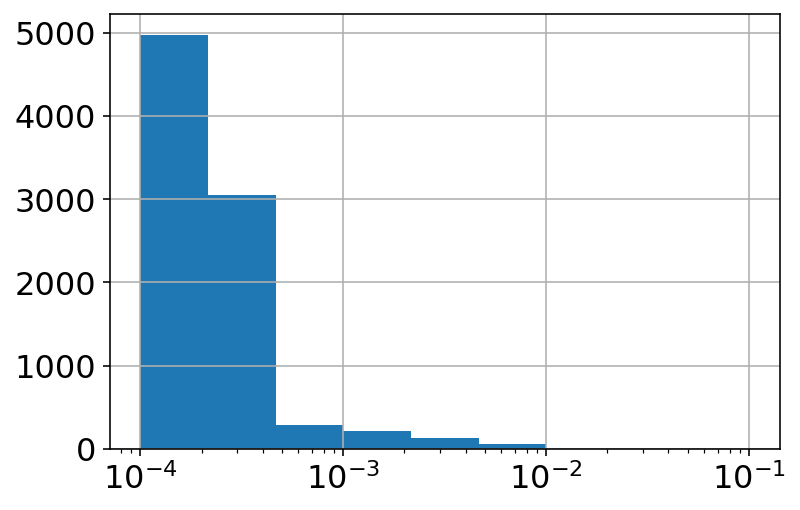

In [150]:
hydro = hydro.reset_index()
hydro['date'] = hydro['Unnamed: 0'].dt.date
hydro = hydro.set_index('date')
combo = df.merge(hydro,left_on='date',right_index=True)
combo['Q [mm/d]'].hist(bins=np.logspace(-4,-1,10))
plt.xscale('log')
combo[(combo['Q [mm/d]']>5e-3)]#&(combo['Q [mm/d]']<10e-3)]

# Make predictions for all dates with PlanetScope data

In [155]:
# # import data and resave as smaller files for github
# # save this block

# bad_dates = ['2019-12-23','2019-10-20','2019-09-30', # cloudy or snowy dates
#              '2019-02-28','2019-02-22','2018-11-19',
#              '2018-12-10','2016-12-17','2018-10-08',
#              '2018-10-31','2018-09-14','2018-07-27',
#              '2018-04-17','2018-03-29','2018-03-26',
#              '2018-01-30','2017-12-27','2017-12-26',
#              '2017-11-18','2017-09-04','2017-08-11',
#              '2017-07-29','2017-02-27','2017-01-24',
#              '2016-05-25','2016-03-15','2016-02-12',
#              '2016-02-02','2015-12-29','2015-12-26',
#              '2016-03-23','2016-11-10',
#              '2015-08-19','2015-08-16','2015-08-03','2015-07-06',
#              '2015-04-24','2014-09-26','2014-09-22','2014-09-17',
#              '2014-03-10','2013-10-28','2013-08-20','2013-06-18',
#              '2013-03-29','2013-03-25','2013-02-21','2013-02-06',
#              '2013-02-02','2012-12-06','2012-10-28','2012-10-25',
#              '2012-10-19','2012-08-23','2012-04-14','2012-03-06',
#              '2012-02-14','2012-02-06','2012-02-05','2012-01-23',

#              '2011-10-06','2011-09-15','2011-04-05','2011-02-22',
#              '2011-01-10','2010-10-23','2010-11-28','2010-11-03',
#              '2010-09-20','2010-04-19','2010-02-05','2010-01-05',
#              '2009-10-04','2009-09-12'
#              ]

# df_alldates1 = pd.read_csv('/content/drive/MyDrive/Sky_Data/rapideye_predict_data_buffer1.csv')

# df_new = ''
# for date in df_alldates1.date.unique():
#   df1 = df_alldates1[df_alldates1.date==date].drop(columns=[
#       'Lithology_']).drop_duplicates()
#   # print(len(df))
#   if len(df_new)==0:
#     df_new = df1
#   else:
#     df_new = pd.concat([df_new,df1])
# df_alldates1 = df_new

# df_alldates1['datetime'] = df_alldates1['datetime_x']

# df_alldates = df_alldates1[df_alldates1['area_updated'].astype(float)>area_thresh]
# df_alldates = df_alldates.loc[pd.to_datetime(df_alldates['datetime'])>dry_runoff.index.values[0]]
# df_alldates = df_alldates[~(df_alldates.date.isin(bad_dates))]

# l = int(len(df_alldates)/10)
# for i in range(11):
#   df_alldates.iloc[l*i:l*(i+1)+1].to_csv('predict_data_'+str(i)+'.csv',index=False
                                        #  )

In [156]:
# read in data
import glob
site = 'Ramsey'
df_alldates = glob.glob('../data/'+site+'/processed_imagery/*.csv')
df_alldates = [pd.read_csv(s) for s in df_alldates]
df_alldates = pd.concat(df_alldates)
df_alldates = df_alldates.dropna().drop_duplicates()
df_alldates = df_alldates.groupby(['geometry','date']).first().reset_index()
df_alldates['date'] = pd.to_datetime(df_alldates['date'],format='%Y%m%d')
df_alldates['date'] = df_alldates.date.dt.date
df_alldates = df_alldates.merge(metad,on='date')

In [157]:
imagd['date'] = pd.to_datetime(imagd.date)
df_alldates['date'] = pd.to_datetime(df_alldates.date)
df_alldates = df_alldates.merge(imagd,on='date')



for band in ['blue','green','red','NIR']:
    if band=='NIR':
        band1 = 'nir'
    else:
        band1 = band
#     df[band] = (df[band]-df[band1+'1'].median())/(df[band1+'99'].median()-df[band1+'1'].median())
    df_alldates[band] = (df_alldates[band]-df_alldates[band1+'1'])/(df_alldates[band1+'99']-df_alldates[band1+'1'])

In [158]:
X_alldates = df_alldates[features]
X_alldates.replace([np.inf, -np.inf], np.nan, inplace=True)
X_alldates = X_alldates.fillna(X_alldates.median())

/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_6323/2470643163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_alldates.replace([np.inf, -np.inf], np.nan, inplace=True)


In [159]:
ypred_alldates = model.predict(X_alldates)
df_alldates['predict'] = ypred_alldates

In [160]:
df_alldates

geometry       date      blue  \
0        POINT (562487.7694848299 3477326.738673826) 2016-07-22  0.453526   
1        POINT (562487.7694848299 3477326.738673826) 2016-08-28  0.392777   
2        POINT (562487.7694848299 3477326.738673826) 2016-09-17  0.080256   
3        POINT (562487.7694848299 3477326.738673826) 2016-10-19  0.147462   
4        POINT (562487.7694848299 3477326.738673826) 2016-11-07  0.105997   
...                                              ...        ...       ...   
1654558  POINT (566246.0490671904 3479852.010892204) 2024-03-18  0.328228   
1654559  POINT (566246.0490671904 3479852.010892204) 2024-03-19  0.474344   
1654560  POINT (566246.0490671904 3479852.010892204) 2024-03-22  0.678399   
1654561  POINT (566246.0490671904 3479852.010892204) 2024-03-27  0.289046   
1654562  POINT (566246.0490671904 3479852.010892204) 2024-03-28  0.483629   

            green       red       NIR  missing  NDWI  p  \
0        0.499006  0.509207  0.897571        0 -0.68  0   
1        0.443340  0.474380  0.871679        0 -0.70  0   
2        0.243539  0.284179  0.623982        0 -0.76  0   
3        0.293907  0.346780  0.543767        0 -0.69  0   
4        0.214821  0.290829  0.503129        0 -0.74  0   
...           ...       ...       ...      ...   ... ..   
1654558  0.456372  0.386088  0.734940        0 -0.65  0   
1654559  0.564284  0.502723  0.911747        0 -0.65  0   
1654560  0.675507  0.588213  0.834981        0 -0.57  0   
1654561  0.470845  0.445807  0.844954        0 -0.68  0   
1654562  0.548598  0.488790  0.903825        0 -0.66  0   

                                acquired  ...  month blue1  blue99  green1  \
0       2016-07-22 17:10:51.461035+00:00  ...      7   0.0   587.0     0.0   
1       2016-08-28 17:12:07.576904+00:00  ...      8   0.0   587.0     0.0   
2       2016-09-17 17:13:09.998412+00:00  ...      9   0.0   587.0     0.0   
3       2016-10-19 17:13:45.111834+00:00  ...     10   0.0   587.0     0.0   
4       2016-11-07 17:14:29.062402+00:00  ...     11   0.0   587.0     0.0   
...                                  ...  ...    ...   ...     ...     ...   
1654558 2024-03-18 17:15:41.800896+00:00  ...      3   0.0   587.0     0.0   
1654559 2024-03-19 18:09:34.407650+00:00  ...      3   0.0   587.0     0.0   
1654560 2024-03-22 17:18:09.982769+00:00  ...      3   0.0   587.0     0.0   
1654561 2024-03-27 18:07:50.926206+00:00  ...      3   0.0   587.0     0.0   
1654562 2024-03-28 17:20:36.187981+00:00  ...      3   0.0   587.0     0.0   

         green99  red1   red99  nir1   nir99  predict  
0         1006.0   0.0  1388.0   0.0  2931.0        0  
1         1006.0   0.0  1388.0   0.0  2931.0        0  
2         1006.0   0.0  1388.0   0.0  2931.0        1  
3         1006.0   0.0  1388.0   0.0  2931.0        1  
4         1006.0   0.0  1388.0   0.0  2931.0        1  
...          ...   ...     ...   ...     ...      ...  
1654558   1006.0   0.0  1388.0   0.0  2931.0        1  
1654559   1006.0   0.0  1388.0   0.0  2931.0        0  
1654560   1006.0   0.0  1388.0   0.0  2931.0        0  
1654561   1006.0   0.0  1388.0   0.0  2931.0        0  
1654562   1006.0   0.0  1388.0   0.0  2931.0        0  

[1654563 rows x 27 columns]

Text(0.5, 0.98, 'Ramsey Canyon')

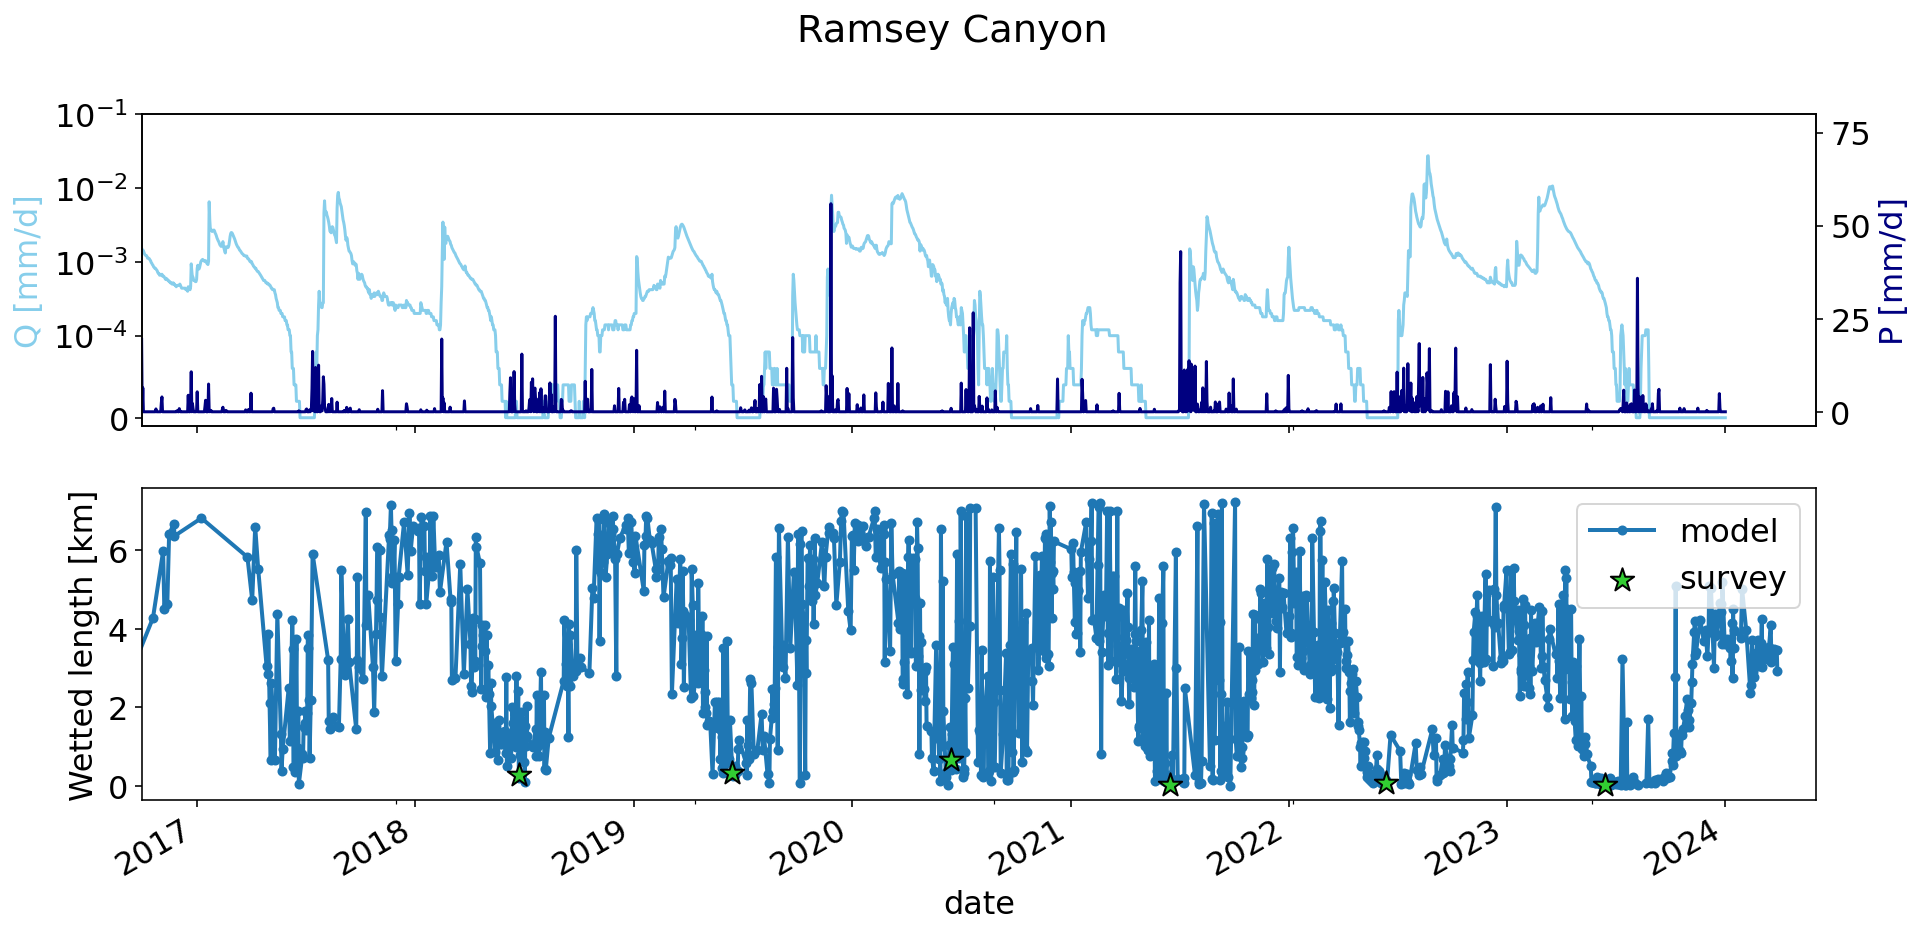

In [161]:
df_alldates['date'] = pd.to_datetime(df_alldates.date,format='%Y%m%d')

fig,axs = plt.subplots(2,figsize = (15,7),sharex=True)
ax = axs[0]
hydro['Q [mm/d]'].plot(ax=ax,c='skyblue')
ax.set_yscale('symlog',linthresh=0.0001)
ax.set_ylim(-.00001,0.1)
ax.set_ylabel('Q [mm/d]',c='skyblue')
axt = ax.twinx()
hydro['P [mm]'].plot(ax=axt,c='navy')
axt.set_ylabel('P [mm/d]',c='navy')
# ax

ax = axs[1]
(df_alldates.groupby('date').predict.sum()*5/1000).plot(ax=ax,lw=2,marker='o',markersize = 4,label='model')
ax.set_ylabel('Wetted length [km]')
survey_info = (df[(df.wetdry=='wet')&(df.assumption=='survey/imagery match')].groupby('date').wetdry.count()*5/1000).reset_index()
ax.scatter(survey_info.date.values,survey_info.wetdry.values,
           c='limegreen',marker='*',s=150,label='survey',zorder = 100,
          edgecolor = 'k')
ax.legend()

ax.set_xlim('2016-10-01','2024-6-01')
fig.suptitle('Ramsey Canyon')

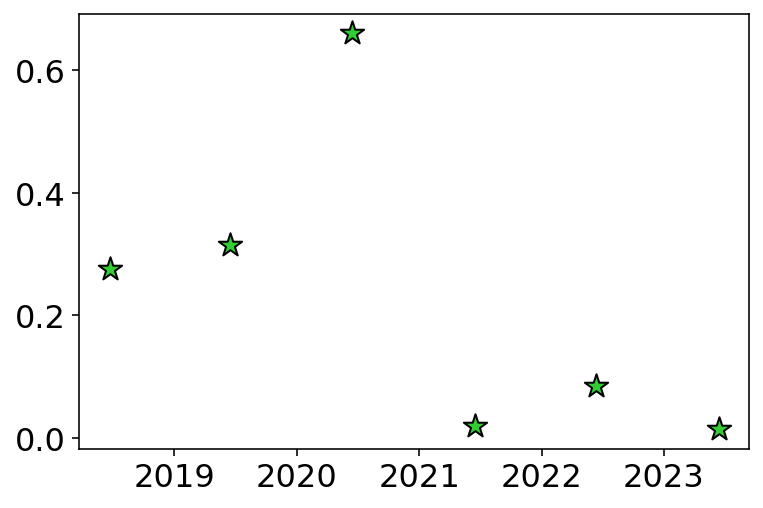

In [162]:
(df_alldates.groupby('date').predict.sum()*5/1000).plot(ax=ax,lw=2,marker='o',markersize = 4,label='model')
ax.set_ylabel('Wetted length [km]')
survey_info = (df[(df.wetdry=='wet')&(df.assumption=='survey/imagery match')].groupby('date').wetdry.count()*5/1000).reset_index()
plt.scatter(survey_info.date.values,survey_info.wetdry.values,
           c='limegreen',marker='*',s=150,label='survey',zorder = 100,
          edgecolor = 'k')

In [219]:
hydro['Unnamed: 0']=pd.to_datetime(hydro['Unnamed: 0'])
hydro.set_index('Unnamed: 0',inplace=True)

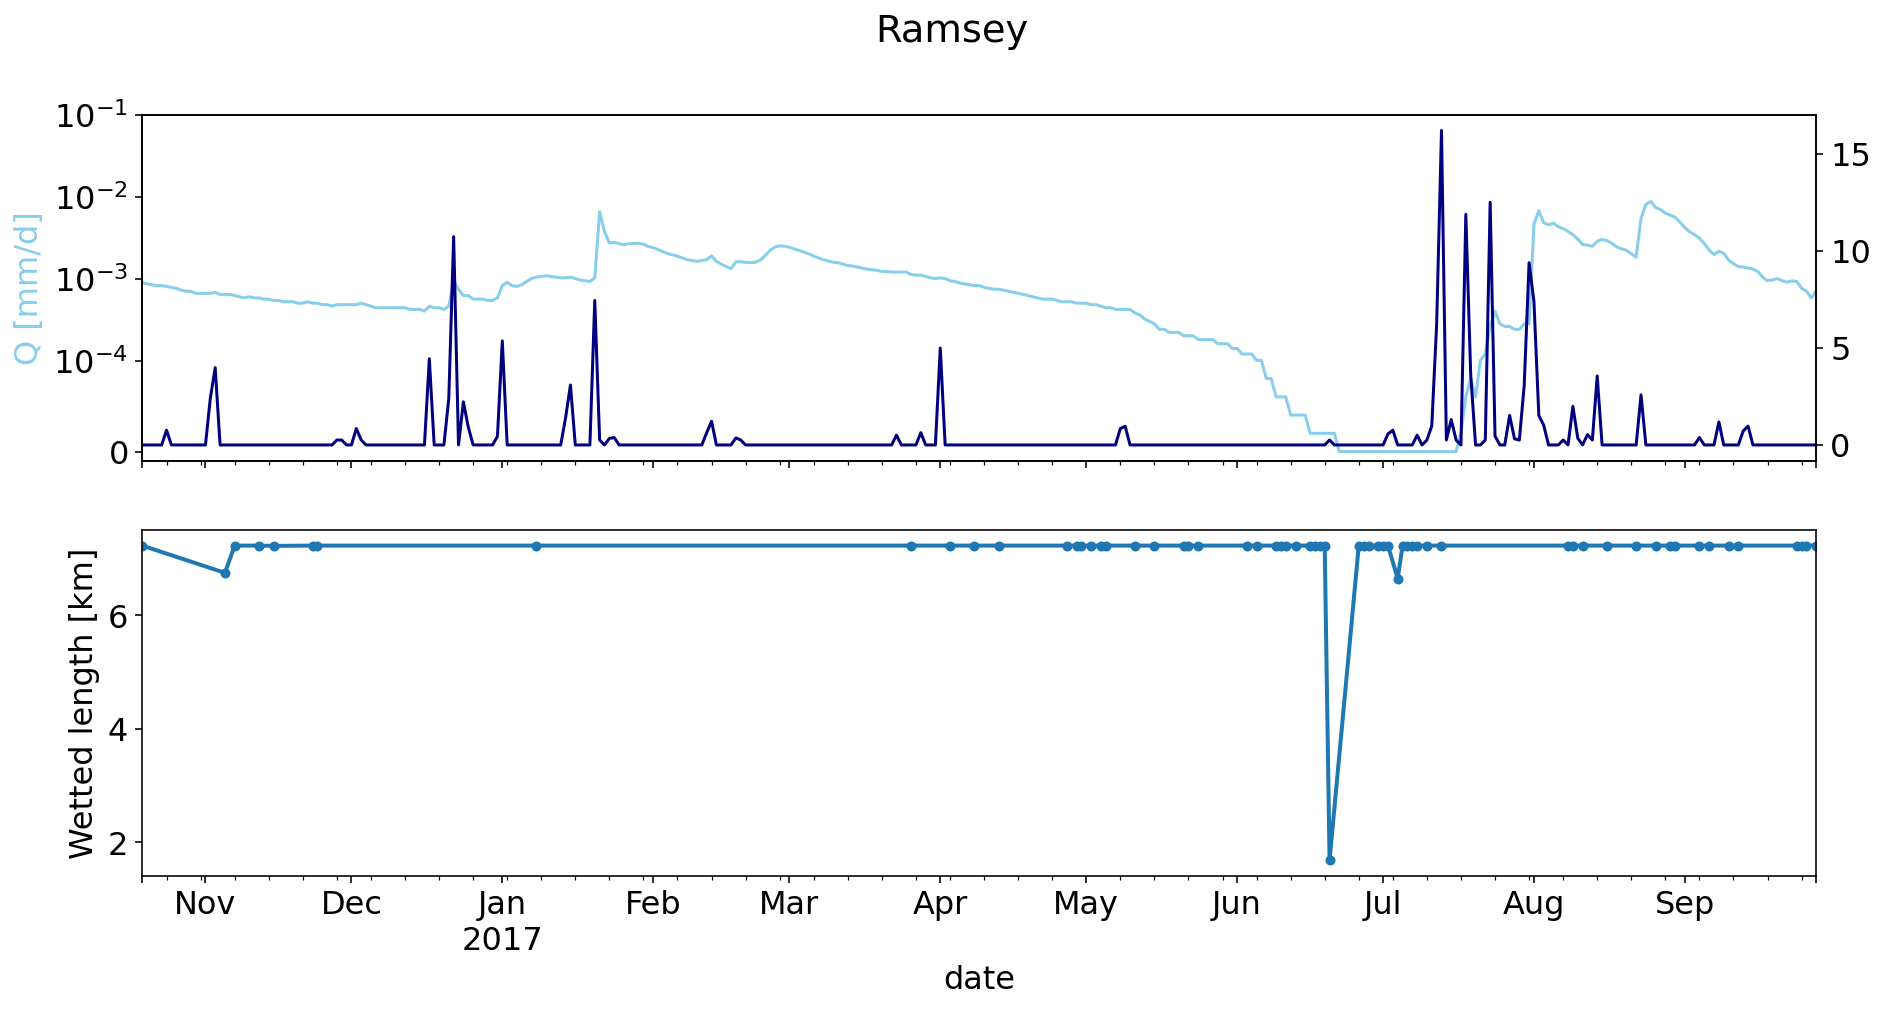

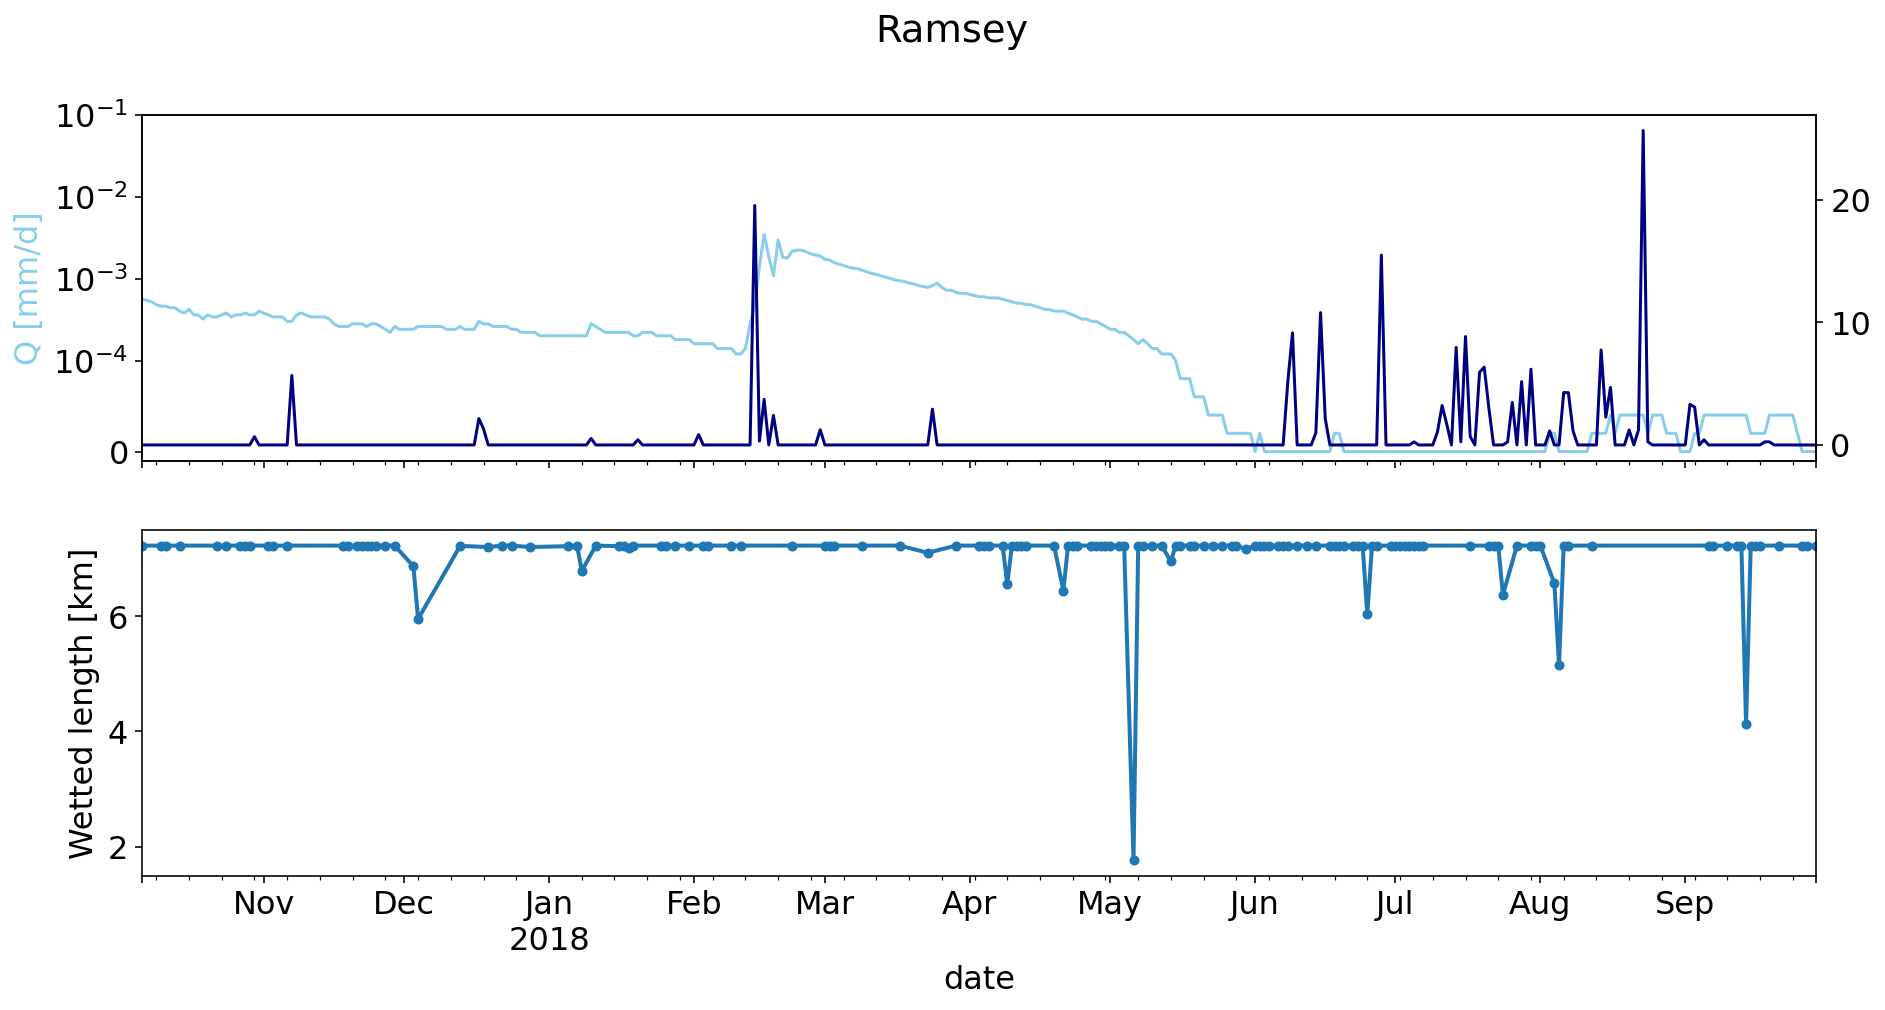

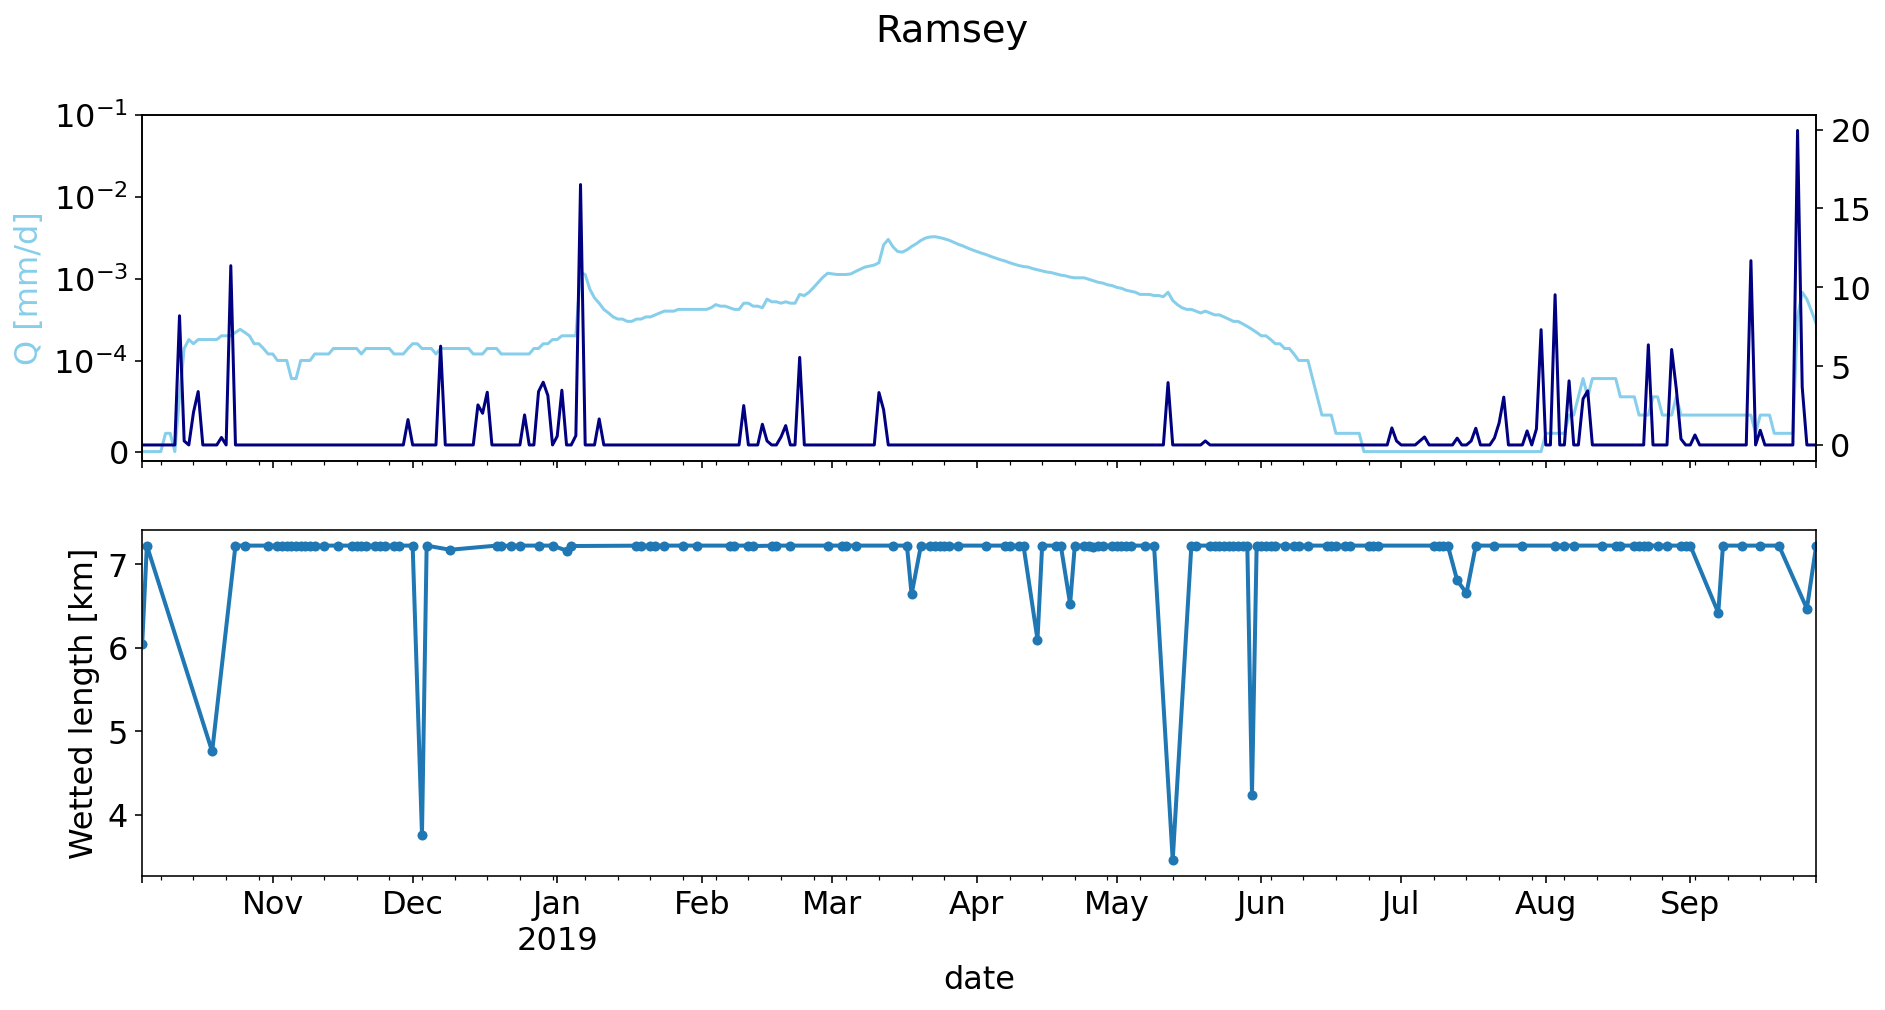

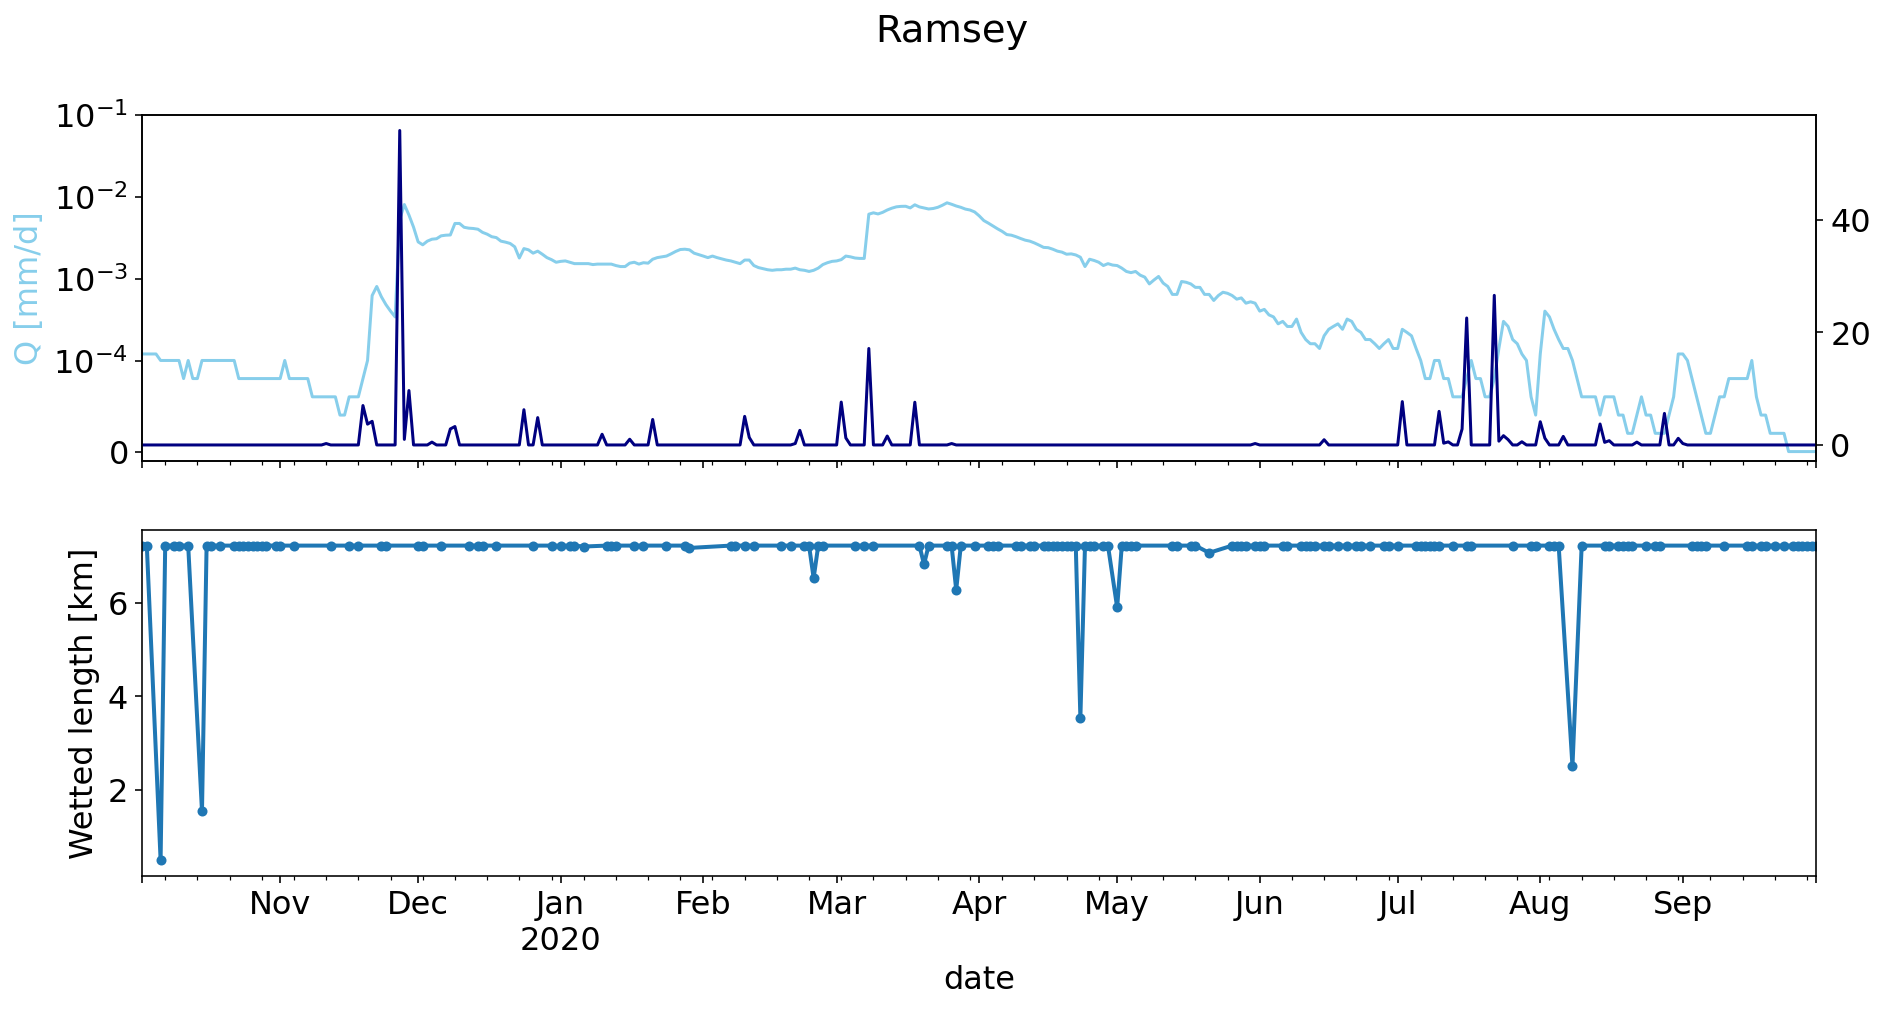

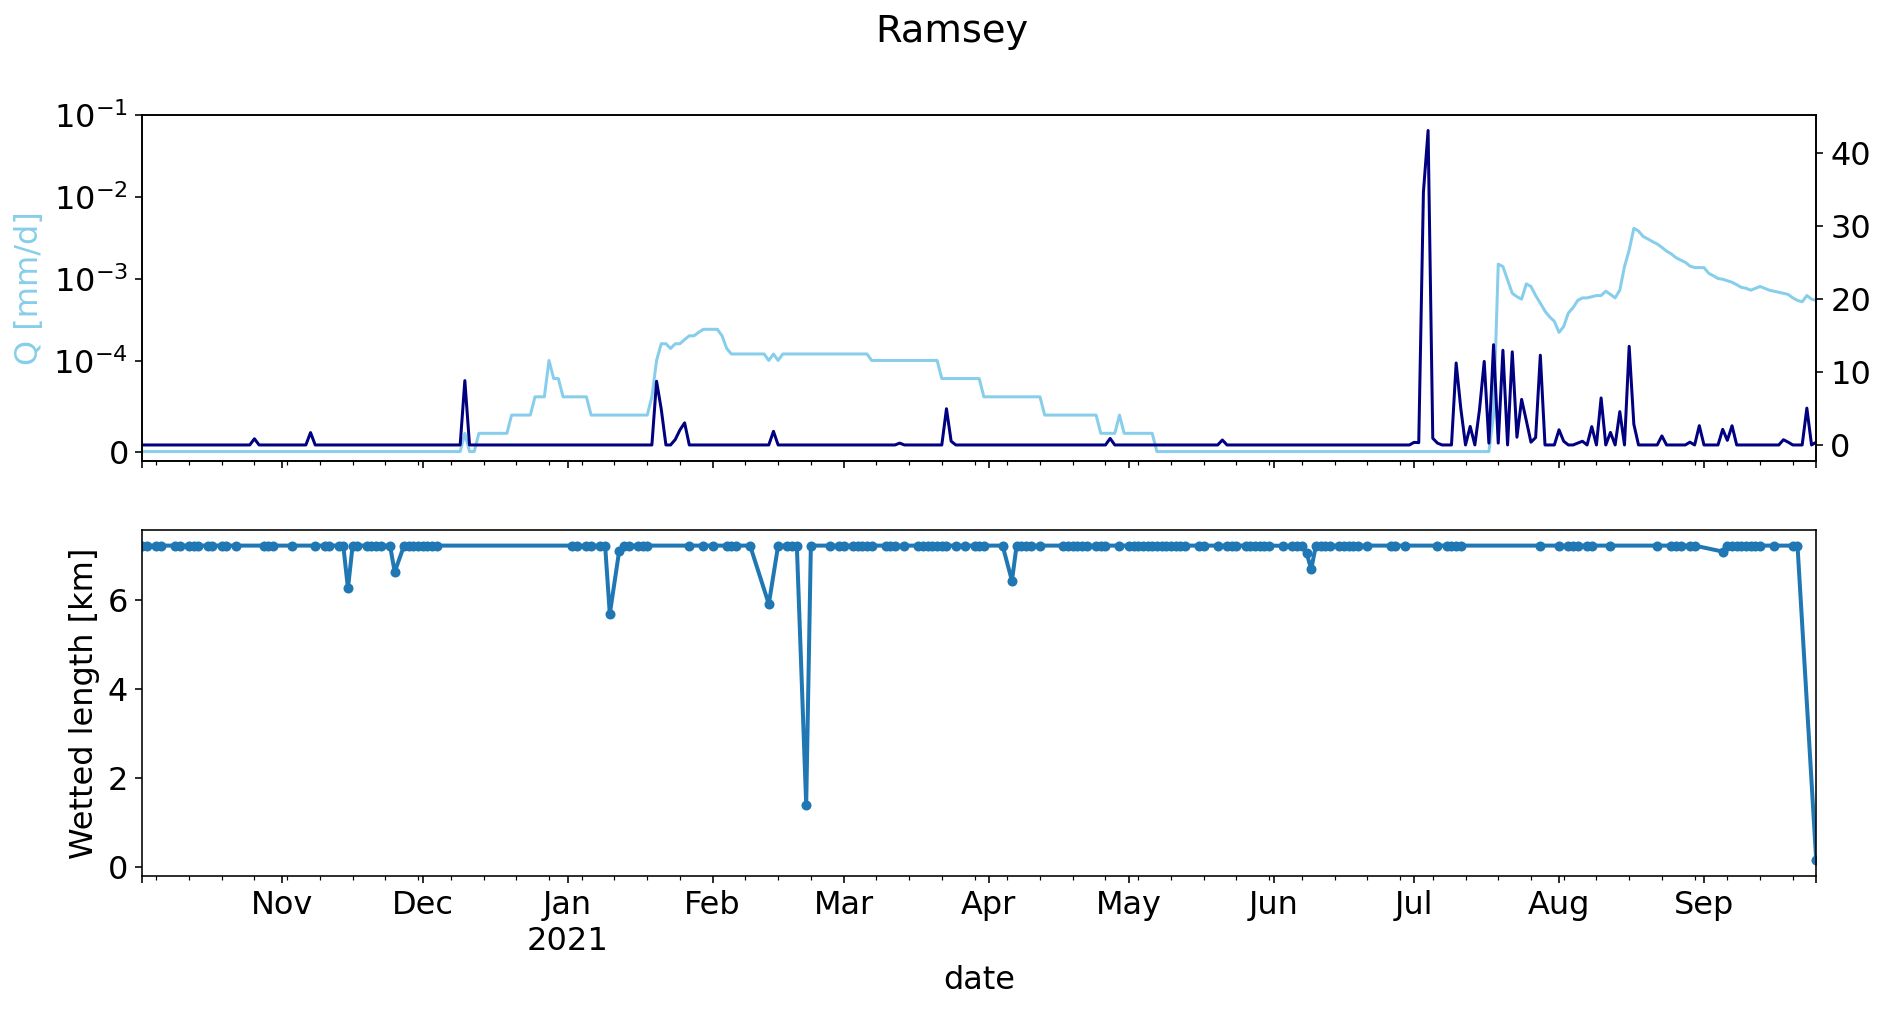

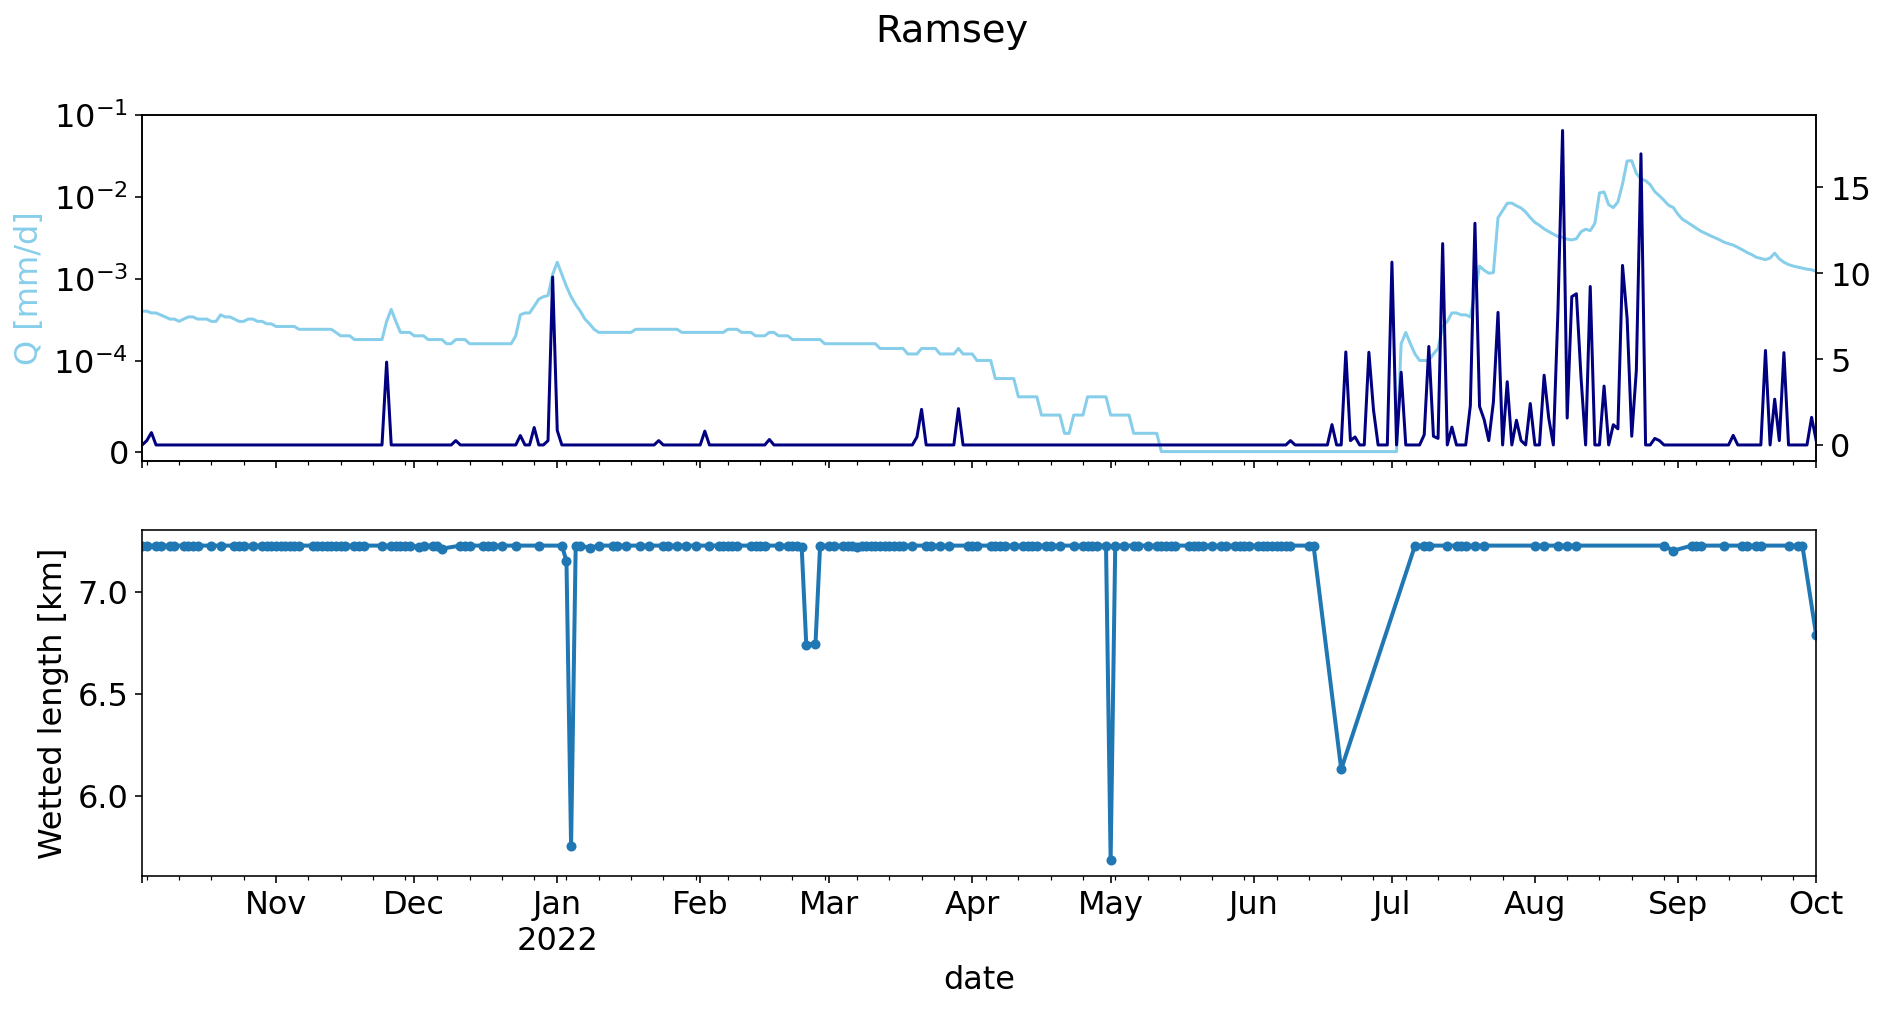

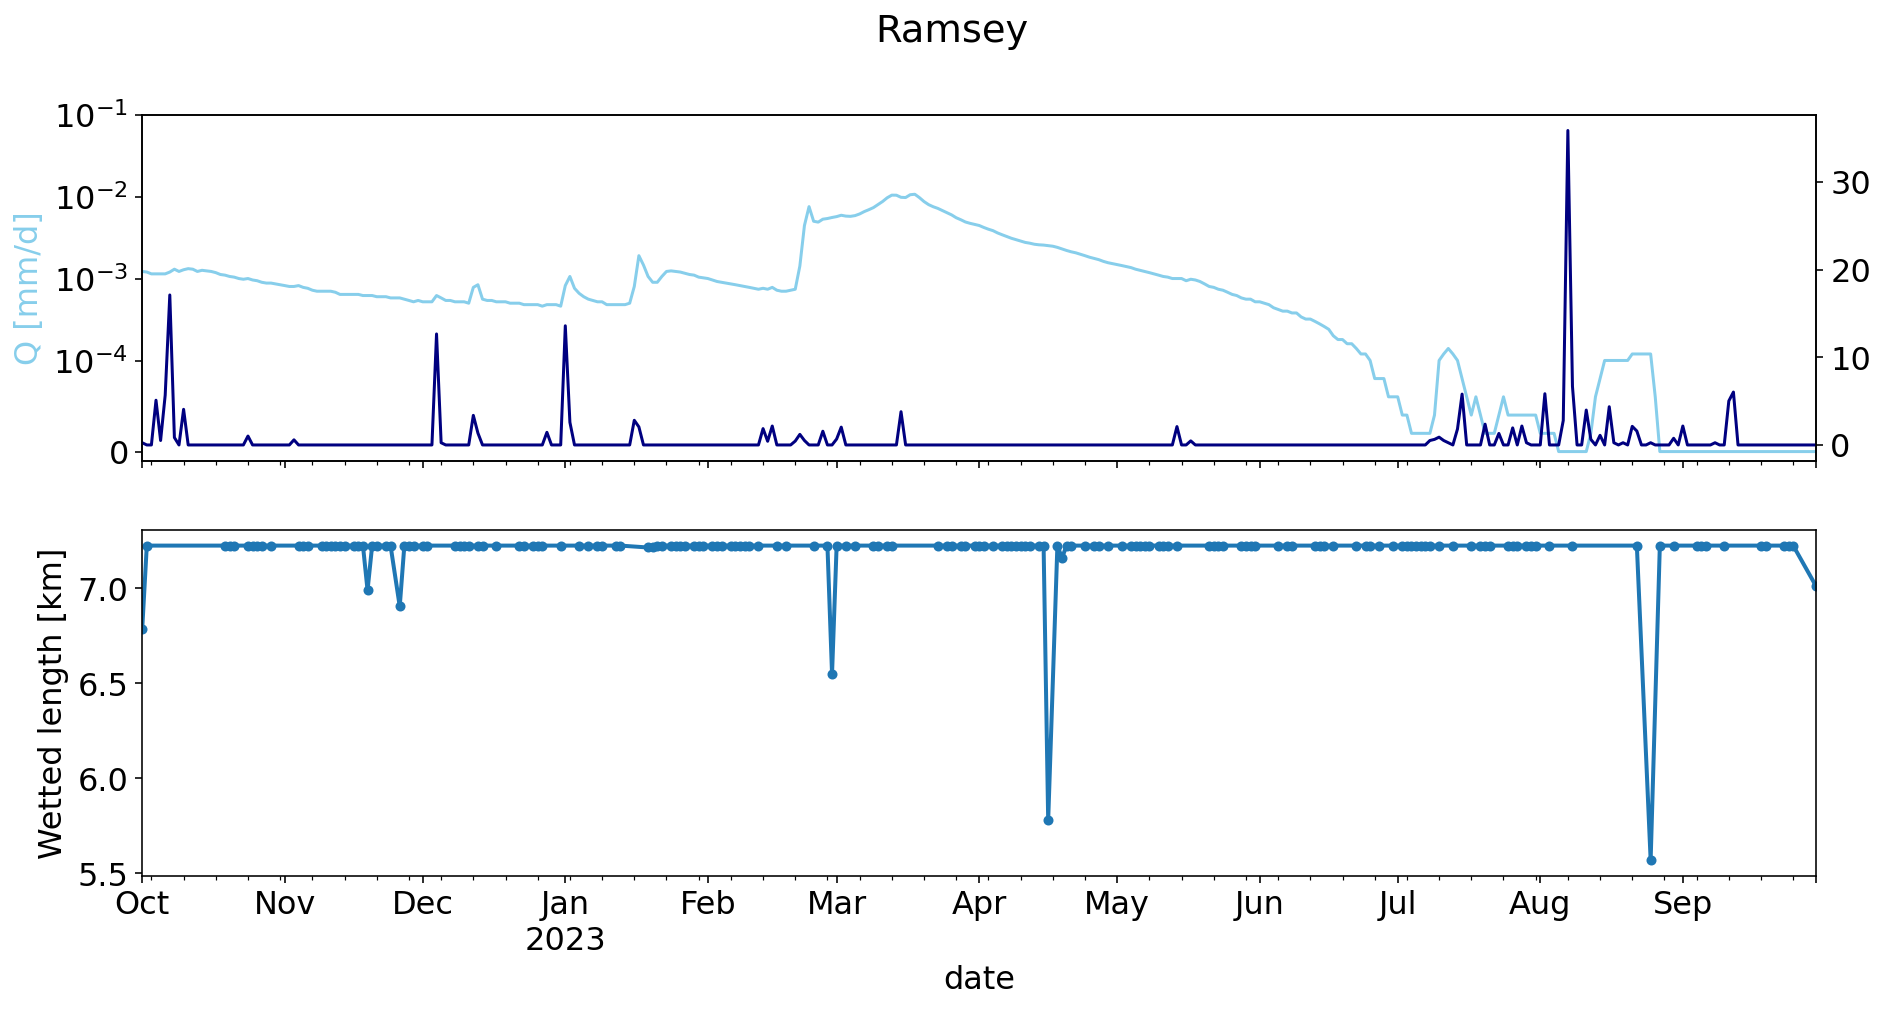

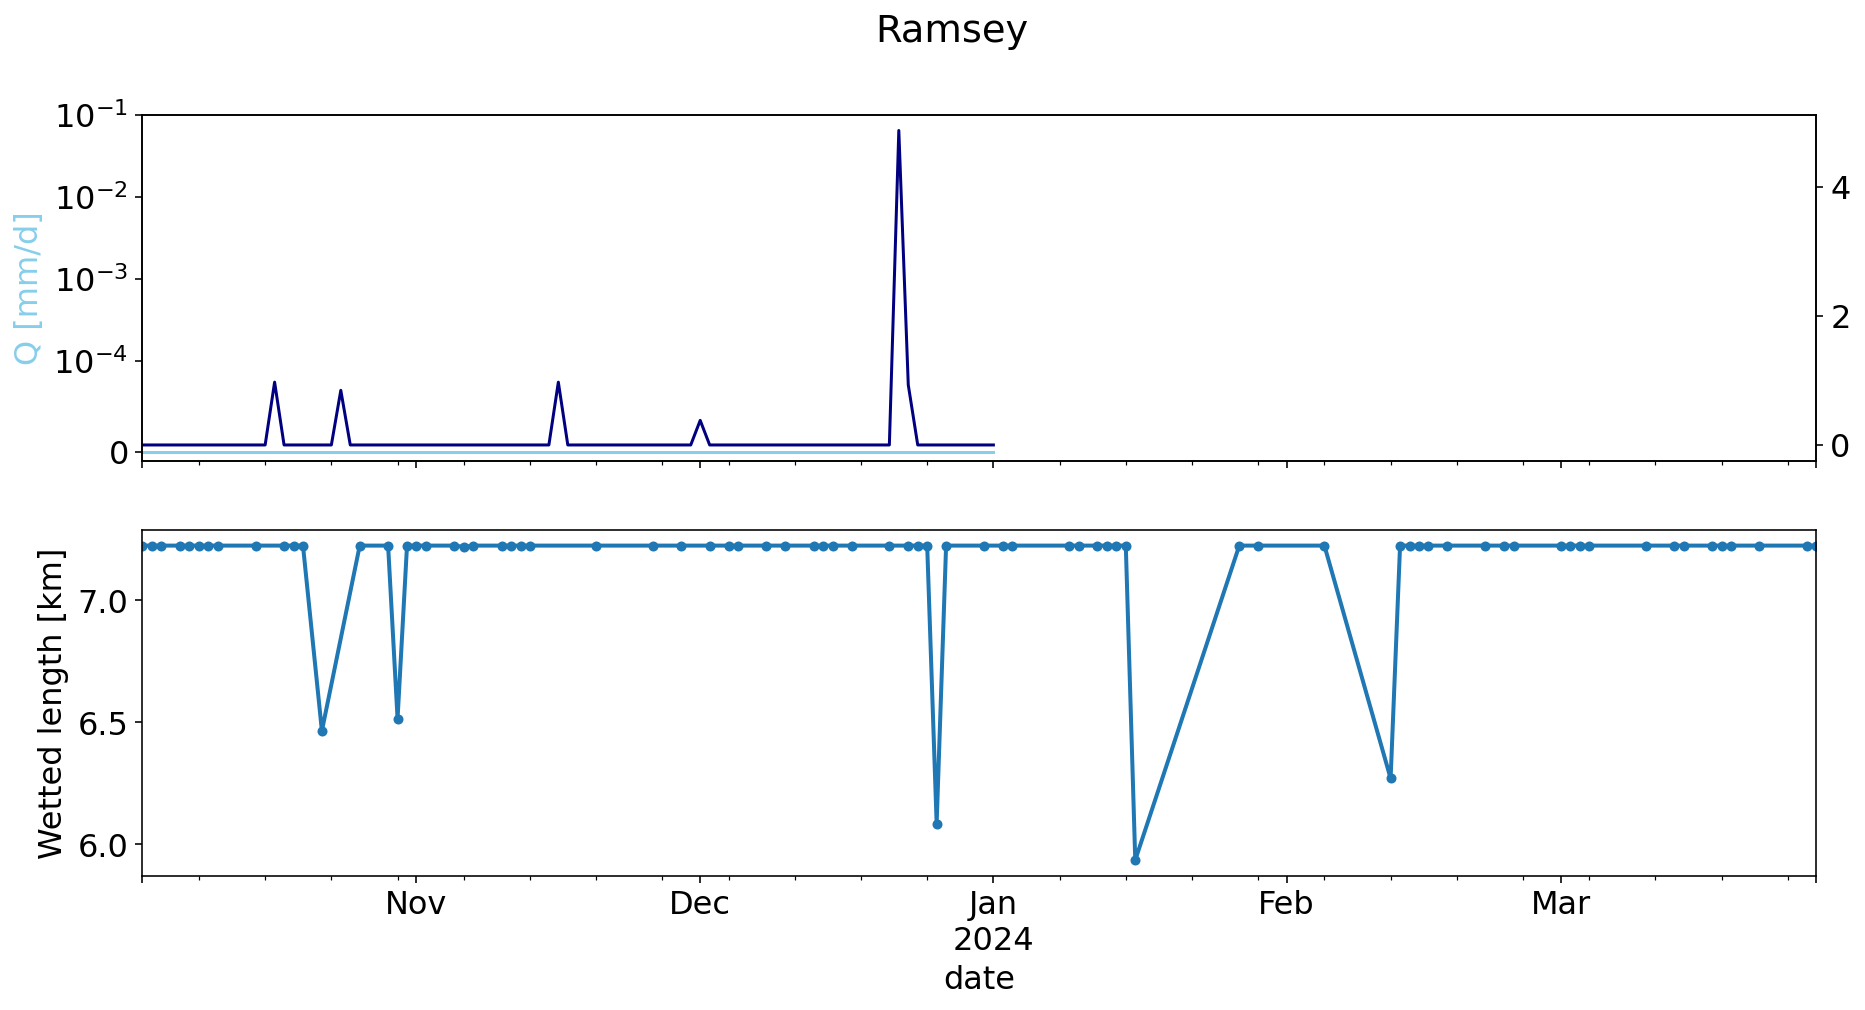

In [92]:
for y in range(2017,2025):
    fig,axs = plt.subplots(2,figsize = (15,7),sharex=True)
    ax = axs[0]
    
    hydro['Q [mm/d]'].loc['10-1-'+str(y-1):'10-1-'+str(y)].plot(ax=ax,c='skyblue')
    ax.set_yscale('symlog',linthresh=0.0001)
    ax.set_ylim(-.00001,0.1)
    ax.set_ylabel('Q [mm/d]',c='skyblue')
    axt = ax.twinx()
    
    hydro['P [mm]'].loc['10-1-'+str(y-1):'10-1-'+str(y)].plot(ax=axt,c='navy')
    # ax

    ax = axs[1]
    (df_alldates.groupby('date').predict.sum()*5/1000).loc['10-1-'+str(y-1):'10-1-'+str(y)].plot(ax=ax,lw=2,marker='o',markersize = 4)
    ax.set_ylabel('Wetted length [km]')

    fig.suptitle(site)

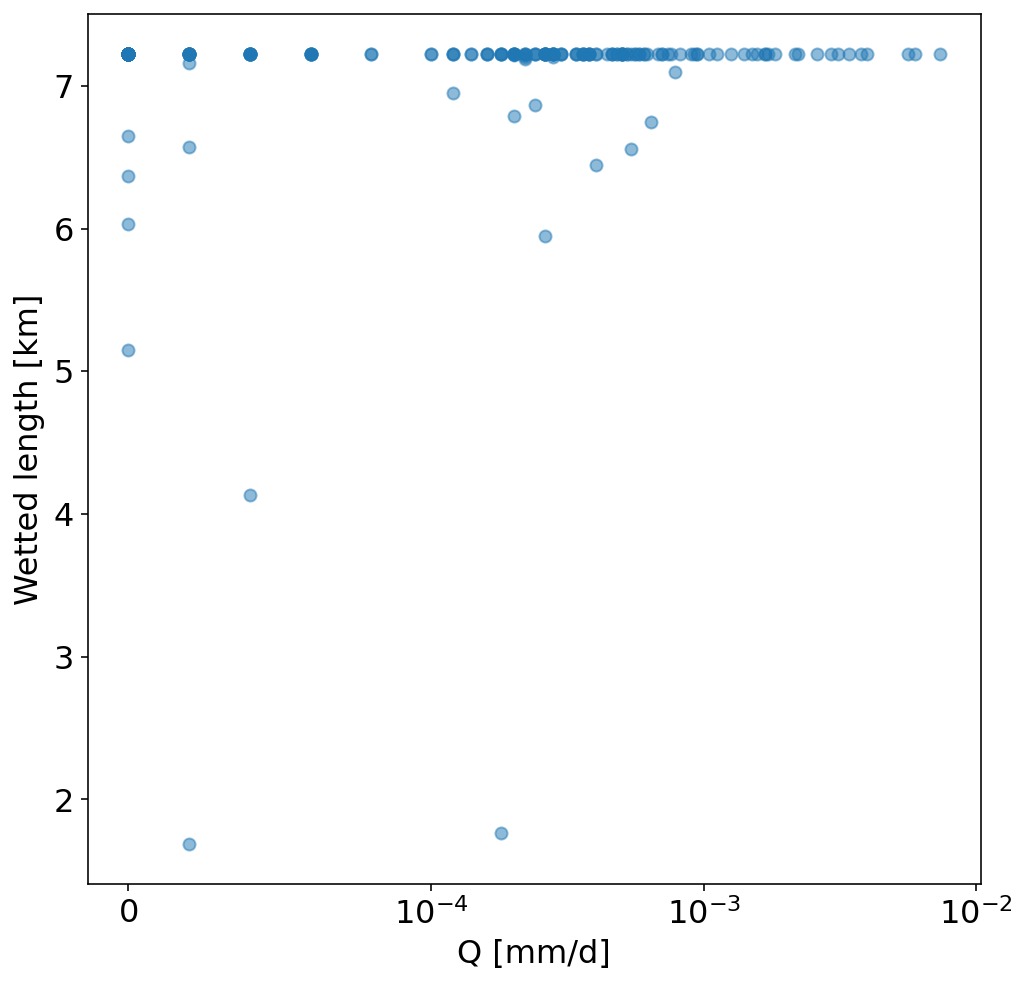

In [93]:
hydroAll = df_alldates.groupby('date')[['predict']].sum().reset_index().merge(hydro,left_on='date',right_index=True)
hydroAll['predict'] = hydroAll.predict*5/1000
hydroAll = hydroAll.loc[:'2023-10-01']

fig,ax = plt.subplots(1,figsize = (8,8))
ax.scatter(hydroAll['Q [mm/d]'],hydroAll.predict,alpha=.5)
ax.set_xlabel('Q [mm/d]')
ax.set_ylabel('Wetted length [km]')
ax.set_xscale('symlog',linthresh=.0001)

<Axes: xlabel='Unnamed: 0'>

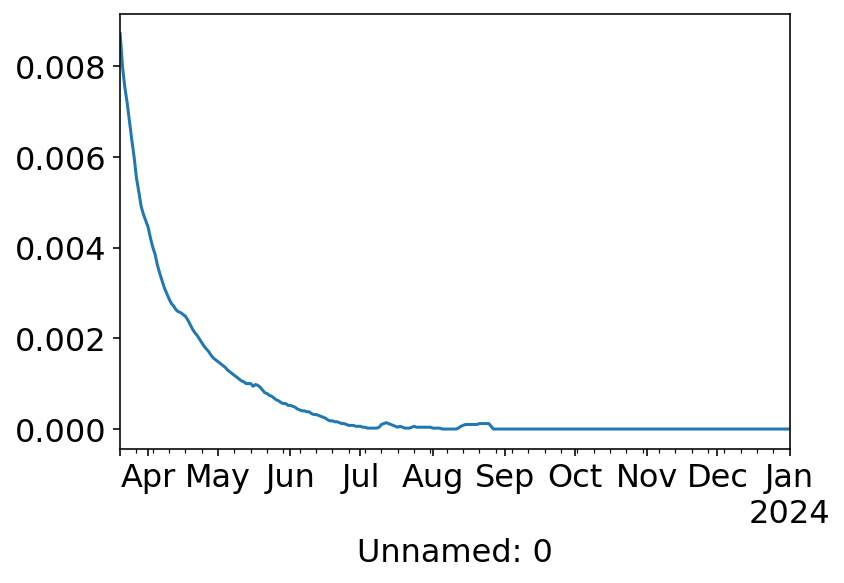

In [56]:
hydroAll[hydroAll['Q [mm/d]']>10e-3]
# hydroAll['Q [mm/d]'].hist(bins = np.logspace(-5,-1,10))
# plt.xscale('log')
hydroAll[hydroAll['Q [mm/d]']==0]#[(hydroAll['Q [mm/d]']<0.00001)&(hydroAll['Q [mm/d]']>0.000001)]
hydro.loc[pd.to_datetime('2023-3-20'):pd.to_datetime('2024-1-1')]['Q [mm/d]'].plot()

In [843]:
df_alldates

geometry       date    blue  \
0        POINT (562487.7694848299 3477326.738673826) 2016-07-22  266.22   
1        POINT (562487.7694848299 3477326.738673826) 2016-08-28  230.56   
2        POINT (562487.7694848299 3477326.738673826) 2016-09-17   47.11   
3        POINT (562487.7694848299 3477326.738673826) 2016-10-19   86.56   
4        POINT (562487.7694848299 3477326.738673826) 2016-11-07   62.22   
...                                              ...        ...     ...   
1654558  POINT (566246.0490671904 3479852.010892204) 2024-03-18  192.67   
1654559  POINT (566246.0490671904 3479852.010892204) 2024-03-19  278.44   
1654560  POINT (566246.0490671904 3479852.010892204) 2024-03-22  398.22   
1654561  POINT (566246.0490671904 3479852.010892204) 2024-03-27  169.67   
1654562  POINT (566246.0490671904 3479852.010892204) 2024-03-28  283.89   

          green     red      NIR  missing  NDWI  p  \
0        502.00  706.78  2630.78        0 -0.68  0   
1        446.00  658.44  2554.89        0 -0.70  0   
2        245.00  394.44  1828.89        0 -0.76  0   
3        295.67  481.33  1593.78        0 -0.69  0   
4        216.11  403.67  1474.67        0 -0.74  0   
...         ...     ...      ...      ...   ... ..   
1654558  459.11  535.89  2154.11        0 -0.65  0   
1654559  567.67  697.78  2672.33        0 -0.65  0   
1654560  679.56  816.44  2447.33        0 -0.57  0   
1654561  473.67  618.78  2476.56        0 -0.68  0   
1654562  551.89  678.44  2649.11        0 -0.66  0   

                                acquired  satellite_azimuth satellite_id  \
0       2016-07-22 17:10:51.461035+00:00              170.1         0e20   
1       2016-08-28 17:12:07.576904+00:00              173.1         0e20   
2       2016-09-17 17:13:09.998412+00:00              229.8         0e0d   
3       2016-10-19 17:13:45.111834+00:00              186.0         0e20   
4       2016-11-07 17:14:29.062402+00:00              185.4         0e2f   
...                                  ...                ...          ...   
1654558 2024-03-18 17:15:41.800896+00:00              101.5         24b4   
1654559 2024-03-19 18:09:34.407650+00:00              101.7         24cd   
1654560 2024-03-22 17:18:09.982769+00:00              262.8         24c0   
1654561 2024-03-27 18:07:50.926206+00:00              277.2         2484   
1654562 2024-03-28 17:20:36.187981+00:00              277.1         24c9   

         sun_azimuth  sun_elevation  view_angle  doy  time  month  predict  
0              101.5           57.4         2.9  204    17      7        1  
1              119.0           52.7         0.8  241    17      8        1  
2              129.4           48.8         0.8  261    17      9        0  
3              142.6           40.5         0.8  293    17     10        1  
4              147.1           35.3         0.2  312    17     11        0  
...              ...            ...         ...  ...   ...    ...      ...  
1654558        129.3           45.2         3.1   78    17      3        1  
1654559        145.7           53.5         3.5   79    18      3        1  
1654560        128.3           46.7         0.6   82    17      3        1  
1654561        142.3           55.8         5.0   87    18      3        1  
1654562        126.7           48.8         4.7   88    17      3        1  

[1654563 rows x 19 columns]

In [844]:
df_alldates['x'] = df_alldates['geometry'].apply(lambda x: float(x.split()[1][1:]))
df_alldates['y'] = df_alldates['geometry'].apply(lambda y: float(y.split()[2][:-1]))
df_alldates = gpd.GeoDataFrame(
    df_alldates, geometry=gpd.points_from_xy(df_alldates.x,df_alldates.y), crs="EPSG:26912"
)
df_alldates = df_alldates.to_crs('EPSG:4326')
df_alldates['x'] = df_alldates.geometry.x
df_alldates['y'] = df_alldates.geometry.y

In [845]:
list(df_alldates[(df_alldates.date>pd.to_datetime('2023-3-20'))&
           (df_alldates.date<pd.to_datetime('2024-1-1'))].date.unique())#.columns#[['date','Q [mm/d]']]

[Timestamp('2023-03-23 00:00:00'),
 Timestamp('2023-03-25 00:00:00'),
 Timestamp('2023-03-26 00:00:00'),
 Timestamp('2023-03-28 00:00:00'),
 Timestamp('2023-03-29 00:00:00'),
 Timestamp('2023-03-31 00:00:00'),
 Timestamp('2023-04-01 00:00:00'),
 Timestamp('2023-04-02 00:00:00'),
 Timestamp('2023-04-04 00:00:00'),
 Timestamp('2023-04-06 00:00:00'),
 Timestamp('2023-04-07 00:00:00'),
 Timestamp('2023-04-08 00:00:00'),
 Timestamp('2023-04-09 00:00:00'),
 Timestamp('2023-04-10 00:00:00'),
 Timestamp('2023-04-11 00:00:00'),
 Timestamp('2023-04-12 00:00:00'),
 Timestamp('2023-04-14 00:00:00'),
 Timestamp('2023-04-15 00:00:00'),
 Timestamp('2023-04-18 00:00:00'),
 Timestamp('2023-04-20 00:00:00'),
 Timestamp('2023-04-21 00:00:00'),
 Timestamp('2023-04-24 00:00:00'),
 Timestamp('2023-04-26 00:00:00'),
 Timestamp('2023-04-27 00:00:00'),
 Timestamp('2023-04-29 00:00:00'),
 Timestamp('2023-05-02 00:00:00'),
 Timestamp('2023-05-04 00:00:00'),
 Timestamp('2023-05-05 00:00:00'),
 Timestamp('2023-05-

In [846]:
df_alldates['wet'] = df_alldates.predict

L = 79%
L = 77%
L = 69%
L = 99%
L = 99%
L = 97%
L = 29%
L = 21%
L = 63%
L = 26%


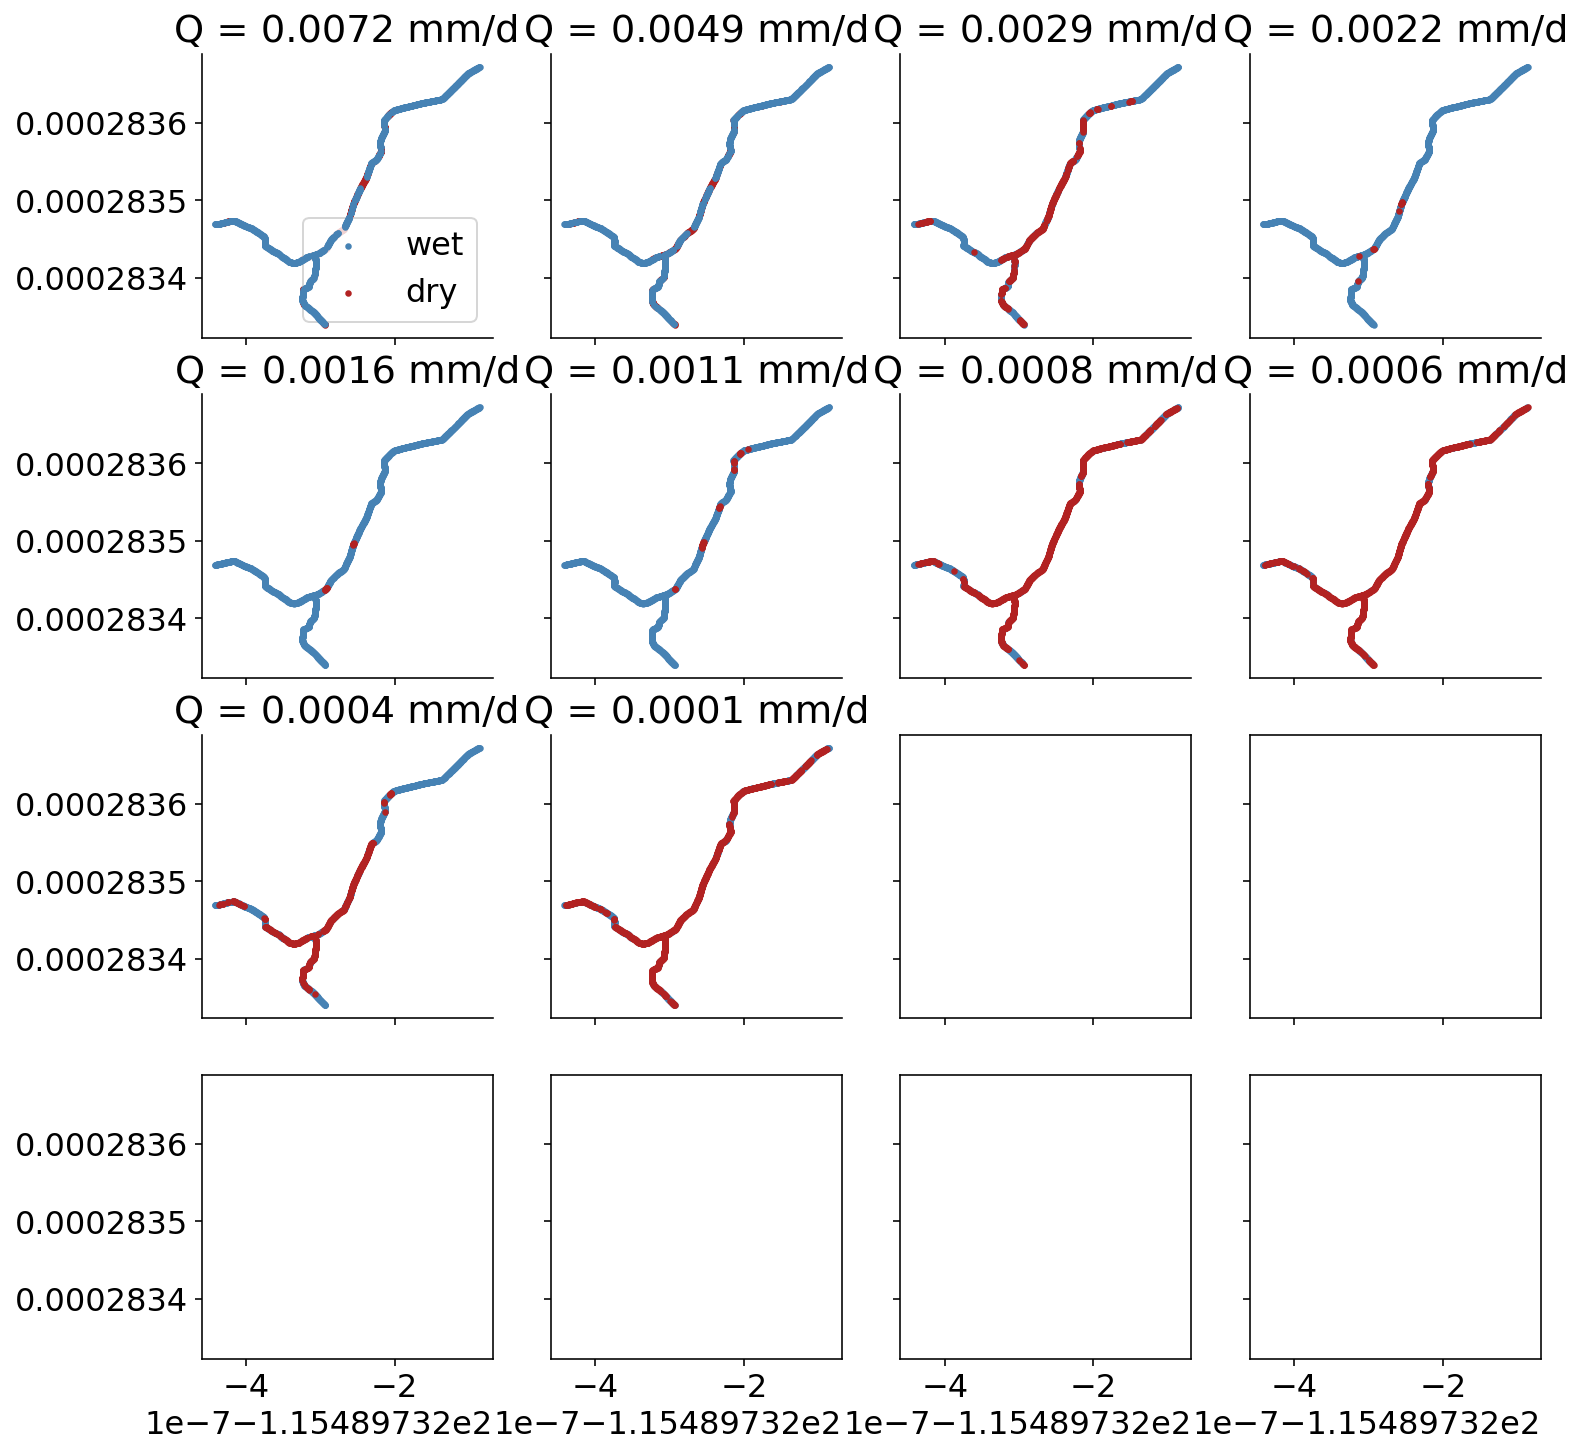

In [847]:
import matplotlib as mpl
import geopandas as gpd

size = 5

plt.rcParams.update({'font.size': 16})

fig,axs = plt.subplots(4,4,figsize = (12,12),
                       sharex=True,
                       sharey=True)
axs = axs.flatten()

xv,yv = -110.31,31.425

i=0
for date in ['2023-3-23','2023-3-29','2023-4-10','2023-4-20','2023-4-29','2023-5-10',
            '2023-5-22','2023-5-30','2023-6-08','2023-6-22',]:#subset.date.drop_duplicates().values[:4]:
  dfsub = df_alldates[df_alldates.date==date]
  if date=='2018-02-12':
    dfsub = dfsub[dfsub.area_updated<=20000]
  dfsub = dfsub.drop_duplicates()
  dfsub = gpd.GeoDataFrame(
    dfsub, geometry=gpd.points_from_xy(dfsub.x, dfsub.y), crs="EPSG:26912"
)
  dfsub = dfsub.to_crs('EPSG:4326')
  dfsub['x'] = dfsub.geometry.x
  dfsub['y'] = dfsub.geometry.y

  ax = axs[i]
  if i>1:
    zorder = -1
    zord1 = 100
  else:
    zorder = 100
    zord1 = -1
  dfsub2 = dfsub[(dfsub.wet==1)]
  pwet = len(dfsub2)/len(dfsub)*100
  ax.scatter(dfsub2.x,dfsub2.y,c='steelblue',
             s=size,label='wet',zorder=zorder)
  dfsub2 = dfsub[(dfsub.wet==0)]
  ax.scatter(dfsub2.x,dfsub2.y,c='firebrick',
             s=size,label='dry',zorder = zord1)
#   ax.text(xv,yv,'L = '+str(round(pwet))+'%')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  if i==0:
    legend = ax.legend(loc='lower right')
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]

  ddate = dfsub.merge(hydro,left_on='date',right_index=True)
  ax.set_title('Q = '+str(round(ddate['Q [mm/d]'].values[0],4))+' mm/d')
#   ax.text(-1*(1e-7-1.154897e2),.00028335,'L = '+str(round((len(dfsub)-len(dfsub2))/len(dfsub))*100)+'%')
  print('L = '+str(round(len(dfsub[dfsub.wet==1])/len(dfsub)*100))+'%')
    


  n = 70

  i+=1



# axs[0,0].text(xv-.015,yv+.03,'Actual',
#               ha = 'center',fontsize = 16)
# axs[0,1].text(xv-.015,yv+.03,'Predicted',
#               ha = 'center',fontsize = 16)
# axs[0,2].text(xv-.015,yv+.03,'Comparison',
#               ha = 'center',fontsize = 16)

# labels = ['a)','b)','c)',
#           'd)','e)','f)',
#           'g)','h)','i)',
#           'j)','k)','l)']

# k=0
# for i in range(4):
#   for j in range(3):
#     axs[i,j].text(-123.517,39.579,labels[k],
#                   fontsize = 16)
#     # print(i,j,k)
#     k+=1

# ax = axs[3,0]
# labels = [item.get_text() for item in ax.get_xticklabels()]
# for ax in [axs[3,0],axs[3,1],axs[3,2]]:
#   ax.set_xticklabels(labels,rotation=90)
#   ax.set_xlabel('Longitude')

# for ax in [axs[0,0],axs[1,0],axs[2,0]]:
#   ax.set_ylabel('Latitude')

# plt.savefig('training_maps.pdf',format='pdf',bbox_inches='tight')

## Context Space

/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_52284/703757501.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context['month'] = context.acquired.dt.month
/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_52284/703757501.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context['date'] = pd.to_datetime(context.date)
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufu

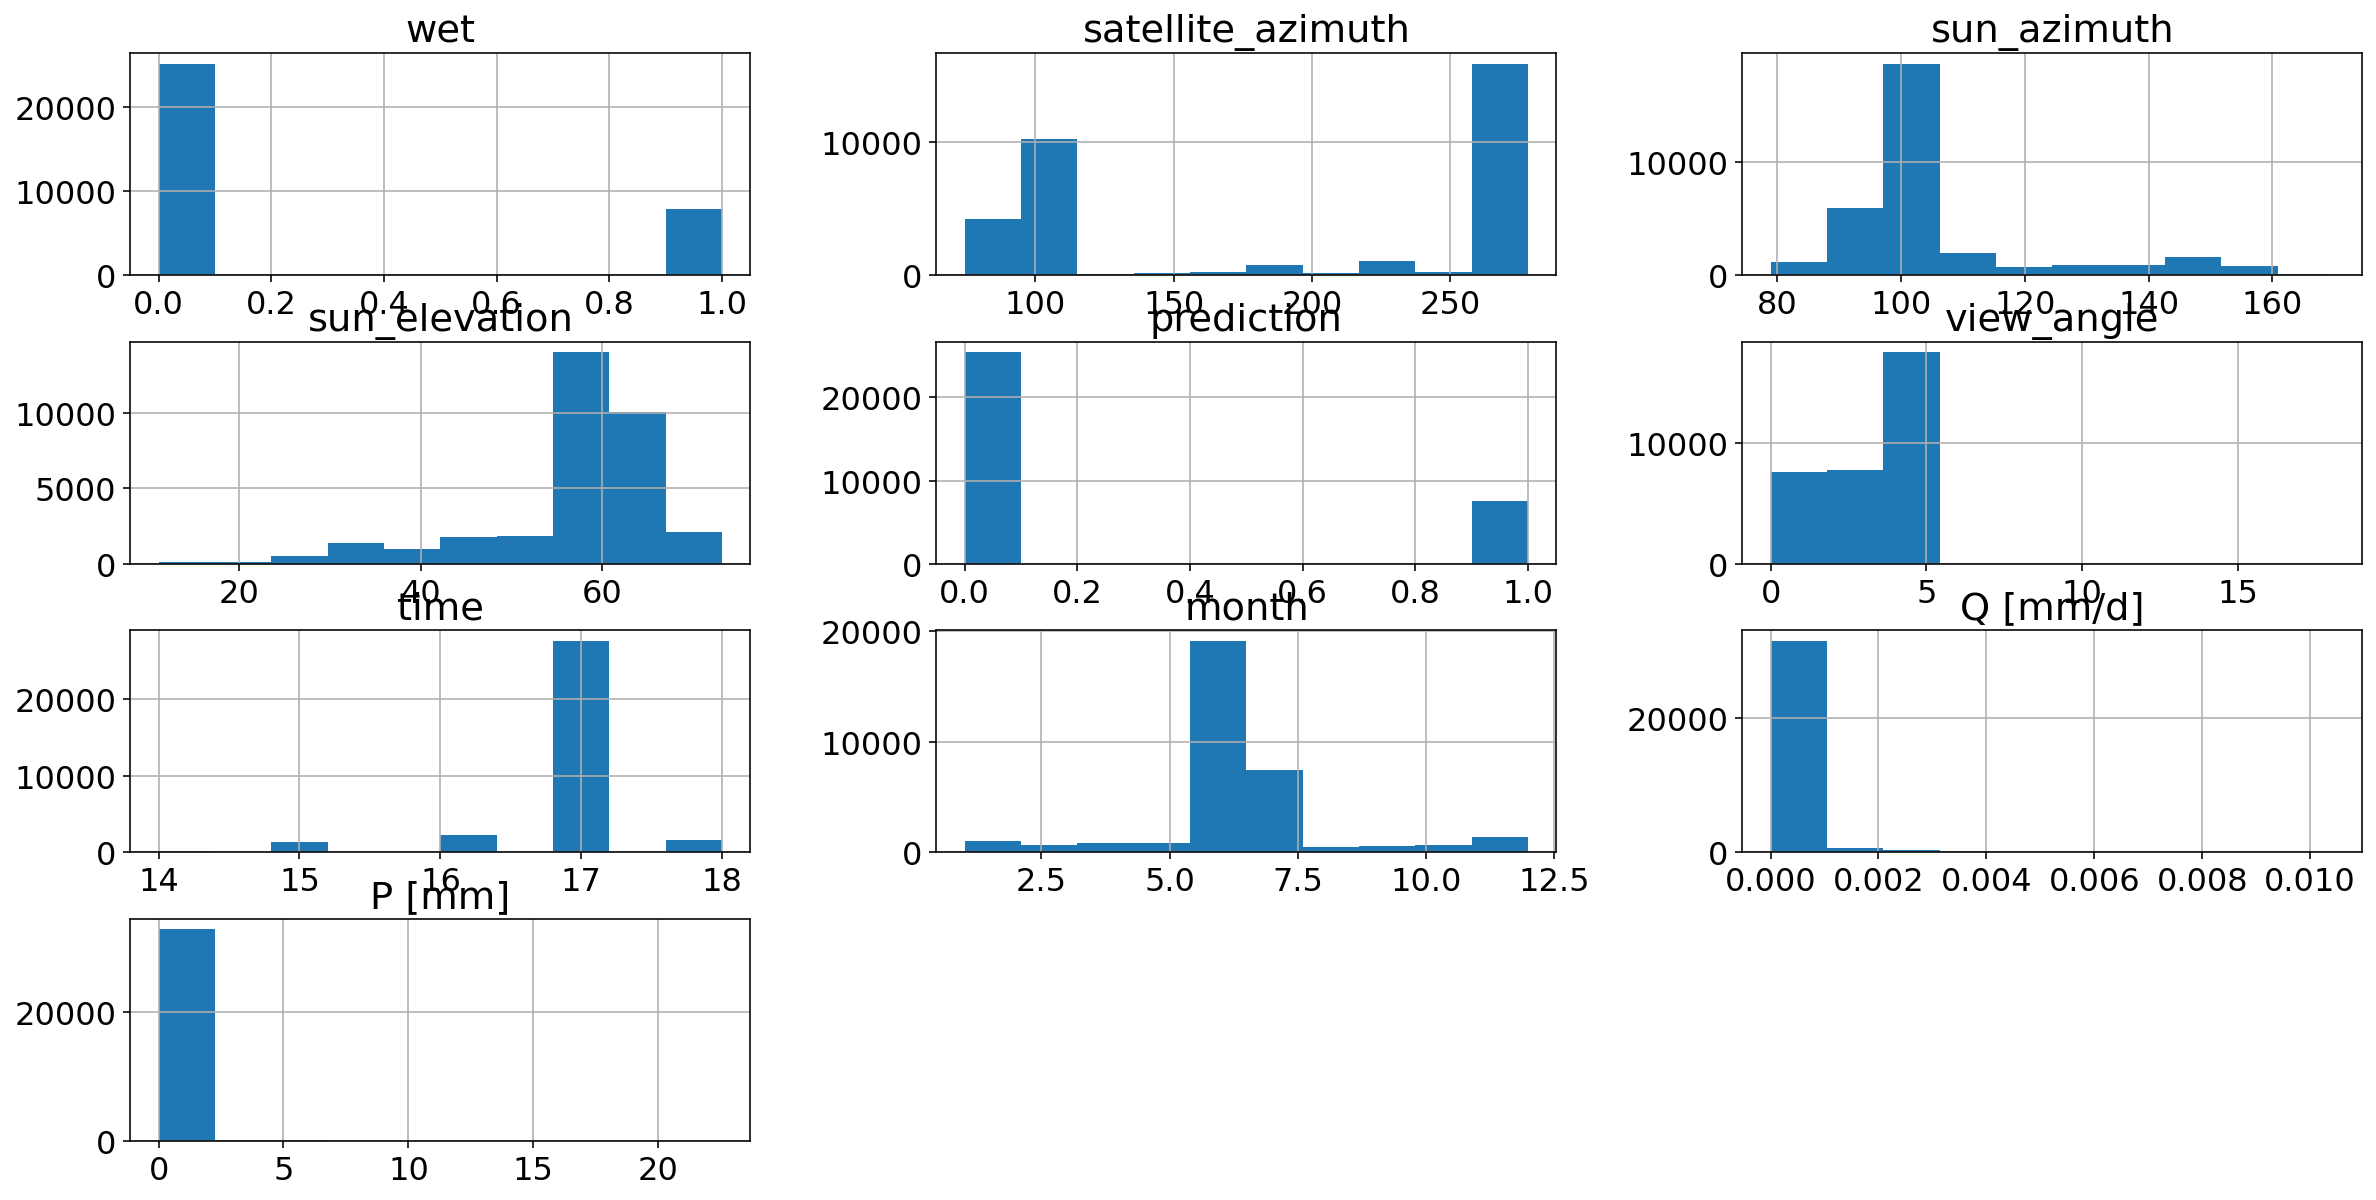

In [970]:
context_features = ['date',
                    'wet',
                    'acquired',
                    'satellite_azimuth','satellite_id',
                    'sun_azimuth','sun_elevation','prediction',
   'view_angle','time',
              'month'
             ]
context_use = [c for c in context_features if c not in ['date','acquired',
                                                       'satellite_id','prediction']]+['Q [mm/d]','P [mm]']
df['month'] = pd.to_datetime(df.date).dt.month
context = df[context_features]
context['month'] = context.acquired.dt.month
context['date'] = pd.to_datetime(context.date)
context = context.merge(hydro,left_on='date',right_index=True)
context.drop(columns=['date','acquired','satellite_id'],inplace=True)
context.hist(figsize = (20,10))
context['Q [mm/d]'] = np.log(context['Q [mm/d]']).fillna(0)
context['Q [mm/d]'] = np.where(np.isfinite(context['Q [mm/d]']),
                              context['Q [mm/d]'],0)

In [852]:
# context = df_alldates[[f for f in context_features if f!='wet']]
# context['month'] = context.acquired.dt.month
# context['date'] = pd.to_datetime(context.date)
# context = context.merge(hydro,left_on='date',right_index=True)
# context.drop(columns=['date','acquired','satellite_id'],inplace=True)
# context.hist(figsize = (20,10))

# Rank context features by information content

In [762]:
df.columns

Index(['x', 'y', 'date', 'wetdry', 'assumption', 'blue', 'green', 'red', 'NIR',
       'missing', 'NDWI', 'p', 'blue1', 'blue99', 'green1', 'green99', 'red1',
       'red99', 'nir1', 'nir99', 'acquired', 'satellite_azimuth',
       'satellite_id', 'sun_azimuth', 'sun_elevation', 'view_angle', 'doy',
       'time', 'month', 'wet', 'prediction'],
      dtype='object')

In [1155]:
# first, get I(L,Ck) for one feature

def categorize(df,feature):
    featuremax = df[feature].max()
    featuremin = df[feature].min()
    numcats = int((featuremax-featuremin)/10)+1
    diff = (featuremax-featuremin)/10
#     print(feature,diff)
    for i in range(11):
        if i==0:
            featurelist = np.where((df[feature]>=featuremin) & (df[feature]<featuremin+diff*(i+1)),
                                   i,-1)
        else:
            featurelist = np.where((df[feature]>=featuremin+diff*i) & (df[feature]<featuremin+diff*(i+1)),
                                   i,featurelist)
    return featurelist
        
def mutual_information_contexts(df1,feature1,feature2):
    df = df1.copy()
    context_vals = []
#     if len(df[feature])>10:
#         df[feature] = categorize(df,feature)
    for c in df[feature1].unique():
        dfsub = df[df[feature1]==c]
        for c1 in df[feature2].unique():
            prob = len(dfsub[dfsub[feature2]==c1])/len(df)
            probl = len(df[df[feature2]==c1])/len(df)
            probc = len(dfsub)/len(df)
            if (prob==0)|(probl==0)|(probc==0):
                mval = 0
            else:
                mval = prob*np.log2(prob/probl/probc)
            context_vals.append(mval)
    rval =  np.sum(context_vals)
    return (rval)

def mutual_information_loss(df1,cc,):
    df = df1.copy()
    num_iters = 1
    for c in cc:
        if len(df[c].unique())>12:
            df[c] = categorize(df,c)
        num_iters  = num_iters*len(df[c].unique())
    cats = {c:df[c].unique() for c in cc}
    mult = 1
    for repnum,c in enumerate(cats.keys()):
        repnum+=1
        repnum = mult
        mult = mult*len(cats[c])
        cats[c] = np.array([np.array([cats[c][i]]*repnum) for i in range(len(cats[c]))]*int(num_iters/len(cats[c])/repnum)).flatten()
    cats = pd.DataFrame.from_dict(cats)
    
    context_vals = []
    for i in range(len(cats)):
        dfsub = df[df[cats.columns[0]]==cats[cats.columns[0]].values[i]]
        for col in cats.columns[1:]:
            dfsub = dfsub[dfsub[col]==cats[col].values[i]]
        
        # prob success (loss=0)
        prob = len(dfsub[dfsub.wet==dfsub.prediction])/len(df)
        probl = len(df[df.wet==df.prediction])/len(df)
        probc = len(dfsub)/len(df)
        if (probl==0)|(probc==0)|(prob==0):
            mval = 0
        else:   
            mval = prob*np.log2(prob/probl/probc)
        context_vals.append(mval)

        # prob failure (loss=1)
        prob = len(dfsub[dfsub.wet!=dfsub.prediction])/len(df)
        probl = len(df[df.wet!=df.prediction])/len(df)
        probc = len(dfsub)/len(df)
        if (prob==0)|(probc==0)|(prob==0):
            mval = 0
        else:
            mval = prob*np.log2(prob/probl/probc)
        context_vals.append(mval)
    rval =  np.sum(context_vals)
    return (rval)

def deltaI(df1,cc):
    df = df1.copy()
    mutual_info = mutual_information_loss(df,cc)
    mutual_context_info = 0
    for i in range(len(cc)-1):
        mutual_context_info += mutual_information_contexts(df,cc[i],cc[-1])
    return mutual_info-mutual_context_info

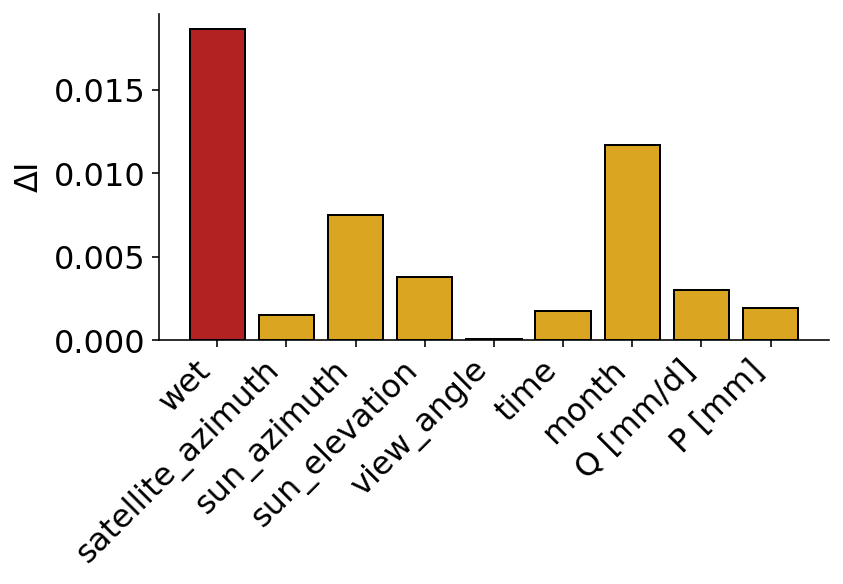

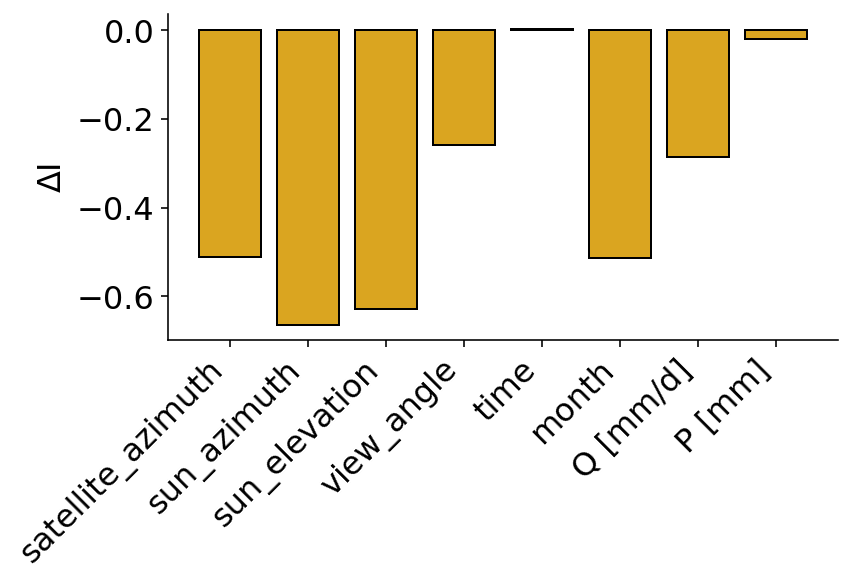

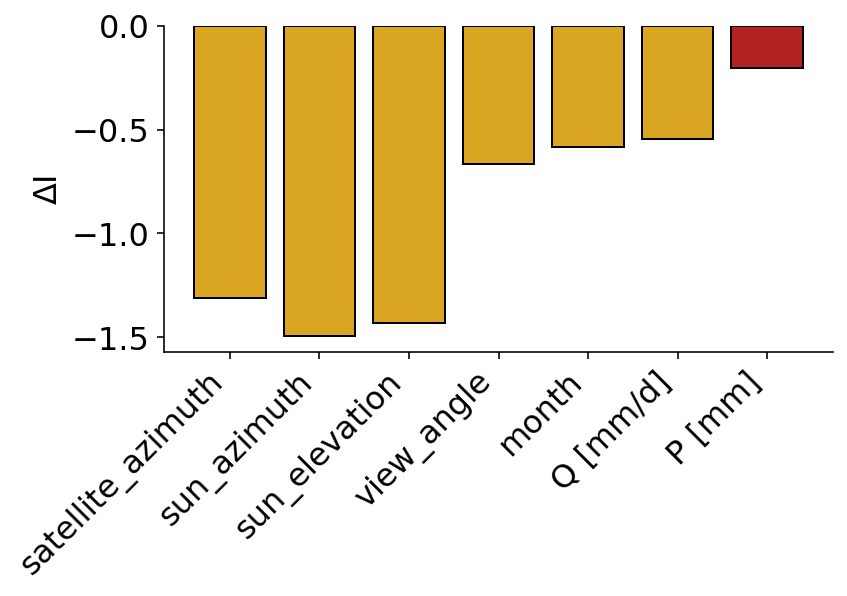

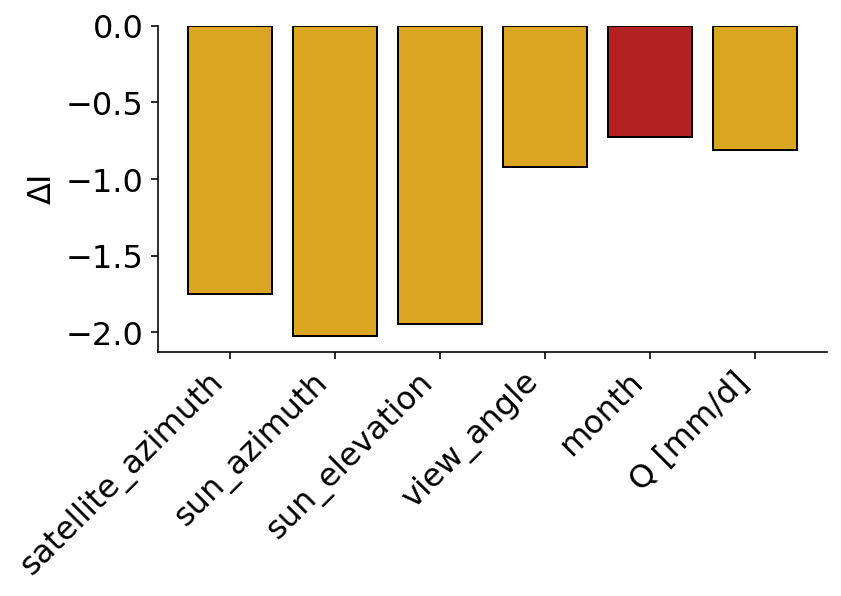

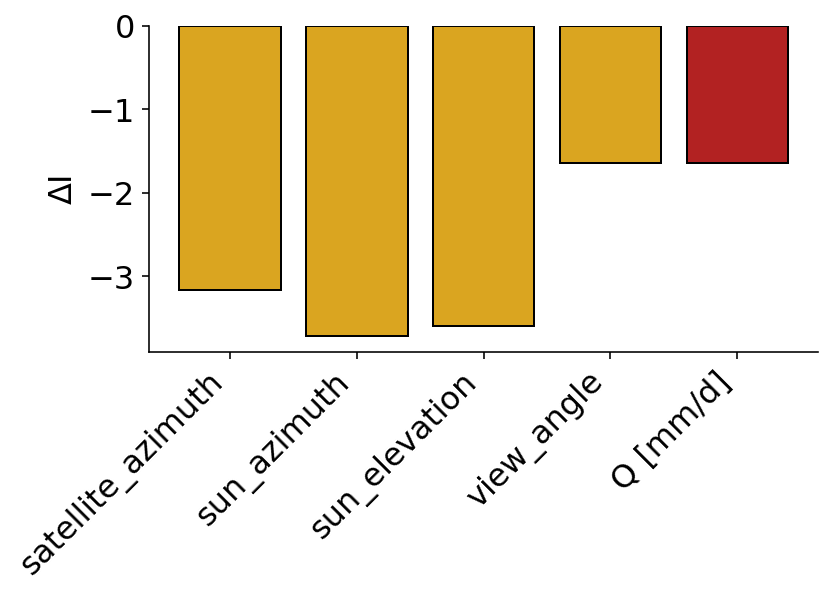

In [1156]:
# rank context features in terms of importance for determining loss
context_features_ranked = []
for i in range(5):#len(context_use)-1):
    infos = {}
    for c in [c for c in context_use if c not in context_features_ranked]:
        infos[c] = [deltaI(context,context_features_ranked + [c])]
    infos = pd.DataFrame.from_dict(infos)
    
    fig,ax = plt.subplots(1,figsize = (6,3))
    for j,c in enumerate(infos.columns):
        if infos[c].values[0]==infos.T.max().values[0]:
            color = 'firebrick'
            context_features_ranked.append(c)
        else:
            color = 'goldenrod'
        ax.bar(j,infos[c].values[0],facecolor = color,edgecolor = 'k')
    ax.set_xticks(list(range(j+1)))
    ax.set_xticklabels(infos.columns,rotation=45,ha='right')
    ax.set_ylabel('$\Delta$I')
    ax.spines[['top','right']].set_visible(False)
    plt.show()
    

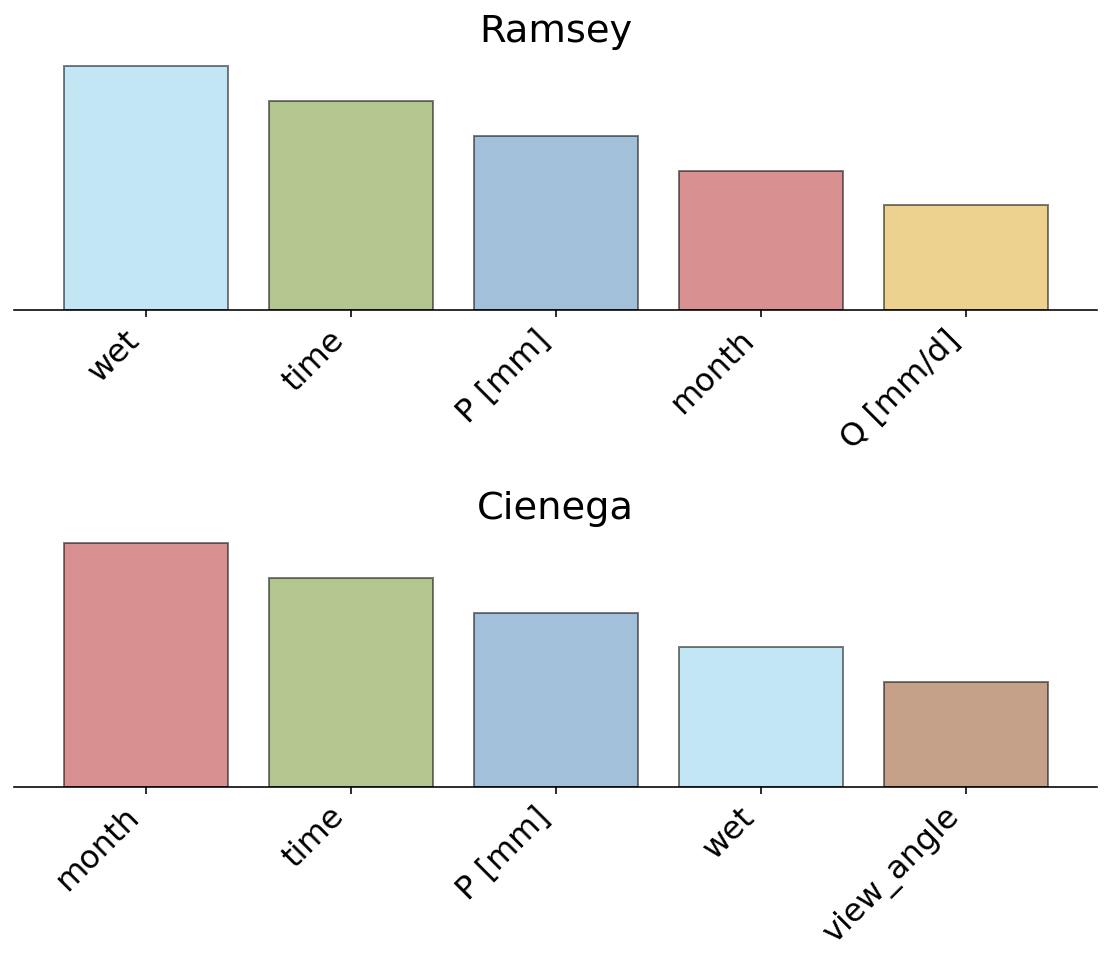

In [1161]:
context_features_ranked_ramsey = context_features_ranked
context_features_ranked_cienega = ['month', 'time', 'P [mm]', 'wet', 'view_angle']
context_list_ranks = [context_features_ranked_ramsey,context_features_ranked_cienega]
colors = {'month':'firebrick','time':'olivedrab','P [mm]':'steelblue','wet':'skyblue',
         'view_angle':'saddlebrown','Q [mm/d]':'goldenrod'}
titles = ['Ramsey','Cienega']

fig,axs = plt.subplots(2,figsize = (8,7))
for i in range(2):
    ax = axs[i]
    for j in range(5):
        ax.bar([j],7-j,edgecolor = 'k',
               facecolor = colors[context_list_ranks[i][j]],alpha=.5)
    ax.set_xticks(list(range(5)))
    ax.set_xticklabels(context_list_ranks[i][:5],rotation=45,ha='right')
    ax.spines[['top','right','left']].set_visible(False)
    ax.set_yticks([])
    ax.set_title(titles[i])
fig.tight_layout()

## Context space dimensionality

In [1162]:
def calc_loss(yfit,y):
    losses = np.nanmean(np.where(yfit!=y,1,0))
    return losses

def gk(df1,context_set,dfval1):
    df = df1.copy()
    dfval = dfval1.copy()
    
    # get set of contexts to explore
    num_iters = 1
    for c in context_set:
        if len(df[c].unique())>12:
            df[c] = categorize(df,c)
        num_iters  = num_iters*len(df[c].unique())
    cats = {c:df[c].unique() for c in context_set}
    mult = 1
    for repnum,c in enumerate(cats.keys()):
        repnum+=1
        repnum = mult
        mult = mult*len(cats[c])
        cats[c] = np.array([np.array([cats[c][i]]*repnum) for i in range(len(cats[c]))]*int(num_iters/len(cats[c])/repnum)).flatten()
    cats = pd.DataFrame.from_dict(cats)
    
    # do calculation
    gkvals = []
    pvals = []
    
    for i in range(len(cats)):
        dfsub = df[df[cats.columns[0]]==cats[cats.columns[0]].values[i]]
        dfsubval = dfval[dfval[cats.columns[0]]==cats[cats.columns[0]].values[i]]
        for col in cats.columns[1:]:
            dfsub = dfsub[dfsub[col]==cats[col].values[i]]
            dfsubval = dfsubval[dfsubval[col]==cats[col].values[i]]
        
        if len(dfsub)==0:
            gkvals.append(1)
        else:
            gkvals.append(len(dfsub[dfsub.wet!=dfsub.prediction])/len(dfsub))
        if len(dfval)==0:
            pvals.append(0)
        else:
            pvals.append(len(dfsubval)/len(dfval))
        
    gkvals = np.array(gkvals)
    pvals = np.array(pvals)
#     print(gkvals)
#     print(pvals)
#     print(np.nansum(pvals*gkvals))
    
    return np.nansum(pvals*gkvals)

In [1163]:
eKs = []
for i in range(1,7):#len(context_features_ranked)+1):
    print('Number of context features:',i)
    cc = context_features_ranked[:i]
    eK = []
    for j in range(10):
        print('     iteration ',j)
        Xfit, Xval, yfit, yval = train_test_split(context,context['prediction'],)
        eK.append(abs(calc_loss(Xfit.prediction,Xfit.wet)-gk(Xfit,cc,Xval)))
#     print(eK)
    eK = np.nanmean(eK)
    eKs.append(eK)
    
    print('     eK =',round(eK,3))

Number of context features: 1
     iteration  0
     iteration  1
     iteration  2
     iteration  3
     iteration  4
     iteration  5
     iteration  6
     iteration  7
     iteration  8
     iteration  9
     eK = 0.0
Number of context features: 2
     iteration  0
     iteration  1
     iteration  2
     iteration  3
     iteration  4
     iteration  5
     iteration  6
     iteration  7
     iteration  8
     iteration  9
     eK = 0.0
Number of context features: 3
     iteration  0
     iteration  1
     iteration  2
     iteration  3
     iteration  4
     iteration  5
     iteration  6
     iteration  7
     iteration  8
     iteration  9
     eK = 0.003
Number of context features: 4
     iteration  0
     iteration  1
     iteration  2
     iteration  3
     iteration  4
     iteration  5
     iteration  6
     iteration  7
     iteration  8
     iteration  9
     eK = 0.004
Number of context features: 5
     iteration  0
     iteration  1
     iteration  2
     iteration  

In [1164]:
eKs

[0.00026557690001544445,
 0.00020877462357922412,
 0.0030000856498125584,
 0.004047124020573304,
 0.004153220907368628,
 0.0038483453428446537]

Text(0.5, 1.0, 'Ramsey')

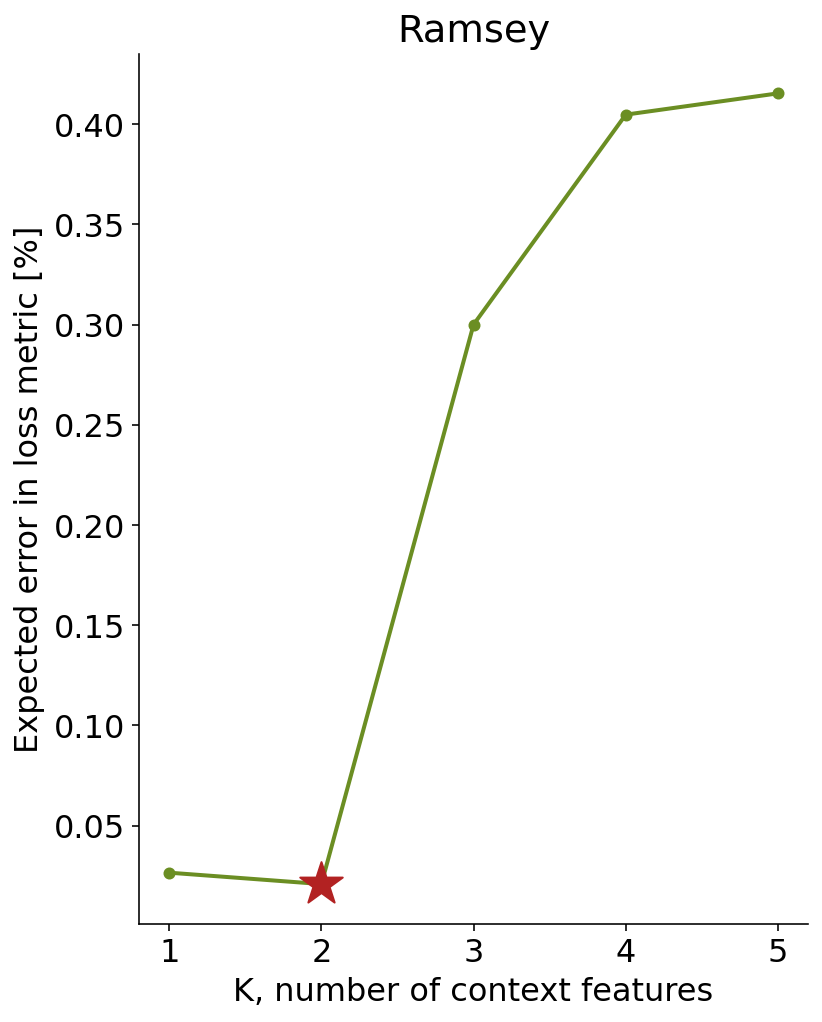

In [1166]:
fig,ax = plt.subplots(1,figsize = (6,8))
eKs = eKs[:6]
ax.plot(list(range(1,len(eKs)+1)),np.array(eKs)*100,marker='o',c='olivedrab',lw=2,markersize=5)
num_use = np.argmin(eKs)
val = np.min(eKs)
ax.scatter([num_use+1],[val*100],c='firebrick',s=500,marker='*',zorder=100)
ax.set_xticks(list(range(1,len(eKs)+1)))
ax.set_xlabel('K, number of context features')
# ax.set_ylim(0,3)
ax.set_ylabel('Expected error in loss metric [%]')
ax.spines[['top','right']].set_visible(False)
ax.set_title('Ramsey')
# ax.set_yscale('symlog',linthresh=3)

In [1098]:
def gk_estimate(df1,context_set):
    df = df1.copy()
       
    # get set of contexts to explore
    num_iters = 1
    for c in context_set:
        if len(df[c].unique())>10:
            df[c] = categorize(df,c)
        if c=='month':
            numuse = 12
        else:
            numuse = len(df[c].unique())
        num_iters  = num_iters*numuse
    cats = {c:df[c].unique() for c in context_set}
    cats['month'] = list(range(1,13))
    mult = 1
    for repnum,c in enumerate(cats.keys()):
        repnum+=1
        repnum = mult
        mult = mult*len(cats[c])
        cats[c] = np.array([np.array([cats[c][i]]*repnum) for i in range(len(cats[c]))]*int(num_iters/len(cats[c])/repnum)).flatten()
    cats = pd.DataFrame.from_dict(cats)
    
    # do calculation
    gkvals = []
#     pvals = []
    lens = 0
    for i in range(len(cats)):
        dfsub = df[df[cats.columns[0]]==cats[cats.columns[0]].values[i]]
#         dfsubval = dfval[dfval[cats.columns[0]]==cats[cats.columns[0]].values[i]]
        for col in cats.columns[1:]:
            dfsub = dfsub[dfsub[col]==cats[col].values[i]]
#             dfsubval = dfsubval[dfsubval[col]==cats[col].values[i]]
        try:
            gkvals.append(len(dfsub[dfsub.wet!=dfsub.prediction])/len(dfsub))
        except:
            gkvals.append(1)
        lens += len(dfsub)
#         pvals.append(1/len(cats))
#         pvals.append(len(dfsubval)/len(dfval))
        
        
    gkvals = np.array(gkvals)
#     pvals = np.array(pvals)
    cats['gk'] = gkvals
    
    return cats

In [1099]:
# estimate model performance on unseen data
i=4
cc = context_features_ranked[:i]
gk_estimate(context,cc)

wet  time  P [mm]  month        gk
0      0    17       0      1  1.000000
1      1    17       0      1  0.012605
2      0    15       0      1  1.000000
3      1    15       0      1  0.028571
4      0    16       0      1  1.000000
..   ...   ...     ...    ...       ...
955    1    16       3     12  1.000000
956    0    18       3     12  1.000000
957    1    18       3     12  1.000000
958    0    14       3     12  1.000000
959    1    14       3     12  1.000000

[960 rows x 5 columns]

## Try running on Cienega

In [241]:
df1 = pd.read_csv('cienega_data.csv')
df1['wet'] = np.where(df1.wetdry=='wet',1,0)

In [233]:
df1.assumption.unique()

array(['survey/imagery match', 'assumed wet', 'assumed perennial',
       'assumed dry'], dtype=object)

In [234]:
print_score(test_model,Xtest = df1[features],ytest=df1['wet'])

RMSE on training set, RMSE on test set, accuracy with training set, accuracy with test set
[0.0, 0.7581802089606114, 1.0, 0.4407537291576657]
Accuracy dry train, Accuracy wet train, Accuracy dry test, Accuracy wet test
[1.0, 1.0, 0.48757202259971283, 0.39393543571561856]


In [197]:
model.score(df1[features], df1.wet)

0.43753148144693393

In [166]:
df['prediction'] = model.predict(df[features])

In [167]:
import matplotlib as mpl
import geopandas as gpd

size = 1

plt.rcParams.update({'font.size': 16})

fig,axs = plt.subplots(12,3,figsize = (20,30),
                       sharex=True,
                       sharey=True)

subset = df1 = df
xv,yv = -110.68,32

i=0
for date in df1[df1.assumption=='survey/imagery match'].date.unique():
  dfsub = subset[subset.date==date]
  dfsub = gpd.GeoDataFrame(
    dfsub, geometry=gpd.points_from_xy(dfsub.x, dfsub.y), crs="EPSG:26912"
)
  dfsub = dfsub.to_crs('EPSG:4326')
  dfsub['x'] = dfsub.geometry.x
  dfsub['y'] = dfsub.geometry.y

#   print(date,len(dfsub))

  ax = axs[i,0]
  if i>1:
    zorder = -1
    zord1 = 100
  else:
    zorder = 100
    zord1 = -1
  dfsub2 = dfsub[(dfsub.wet==1)]
  pwet = len(dfsub2)/len(dfsub)*100
  ax.scatter(dfsub2.x,dfsub2.y,c='steelblue',
             s=size,label='wet',zorder=zorder)
  dfsub2 = dfsub[(dfsub.wet==0)]
  ax.scatter(dfsub2.x,dfsub2.y,c='firebrick',
             s=size,label='dry',zorder = zord1)
  ax.text(xv,yv,'L = '+str(round(pwet))+'%')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  if i==0:
    legend = ax.legend(loc='lower right')
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]

  ax.set_title('Actual')

  ax = axs[i,1]

  dfsub1 = dfsub[(dfsub.prediction==1)]
  pwet = len(dfsub1)/len(dfsub)*100
  ax.scatter(dfsub1.x,dfsub1.y,c='steelblue',
             s=size,label='Wet',
             zorder = zorder)
  dfsub1 = dfsub[(dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,c='firebrick',
             s=size,label='Dry',zorder = zord1)
  ax.set_title(str(date)[:10])
  if i==0:
    legend = ax.legend(loc='lower right')
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]

  ax.text(xv,yv,'L = '+str(round(pwet))+'%')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  ax = axs[i,2]

  dfsub1 = dfsub[(dfsub.wet==1) &
                 (dfsub.prediction==1)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='skyblue',label='True wet',
             s=size)
  dfsub1 = dfsub[(dfsub.wet==0) &
                 (dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='salmon',label='True dry',
             s=size, alpha=0.5)
  dfsub1 = dfsub[(dfsub.wet==1) &
                 (dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='navy',label='Wet, predicted dry',
             s=size)
  dfsub1 = dfsub[(dfsub.wet==0) &
                 (dfsub.prediction==1)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='firebrick',label='Dry, predicted wet',
             s=size)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  if i==0:
    legend = ax.legend(ncol=2)
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]
#     legend.legendHandles[2]._sizes = [size1]
#     legend.legendHandles[3]._sizes = [size1]
  n = 70

  i+=1




In [ ]:
dfsub

## Train on both sites and run for accuracy on each

In [235]:
features1 = features#+['month']

In [247]:
df11 = df1.copy()
df11 = df11[~(df11.assumption.str.contains('perennial'))|
           (pd.to_datetime(df11.date).dt.year>2020)]

In [250]:
# trained on both, tested on Cienega

bothmodel= RandomForestClassifier(random_state=42)
# features1 = features

X1 = pd.concat([df,df11])[features1]
Y1 = pd.concat([df,df11])['wet']

Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(df1[features1], df1['wet'],
                                                random_state=42)

Xtrain1 = pd.concat([Xtrain1,df[features1]])
ytrain1 = pd.concat([ytrain1.to_frame(),df[['wet']]])['wet']

bothmodel.fit(Xtrain1, ytrain1)
print_score(bothmodel, Xtrain = Xtrain1, Xtest = Xtest1, ytrain = ytrain1, ytest = ytest1)

RMSE on training set, RMSE on test set, accuracy with training set, accuracy with test set
[0.0036990890635180086, 0.4669245718841181, 0.9999879345085122, 0.7396119927847654]
Accuracy dry train, Accuracy wet train, Accuracy dry test, Accuracy wet test
[1.0, 0.9999758690170244, 0.6137062307865337, 0.8655177547829971]


In [251]:
# trained on both, tested on Ramsey

bothmodel= RandomForestClassifier(random_state=42)


X1 = pd.concat([df,df1])[features1]
Y1 = pd.concat([df,df1])['wet']

Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(df[features1], df['wet'],
                                                random_state=42)

Xtrain1 = pd.concat([Xtrain1,df1[features1]])
ytrain1 = pd.concat([ytrain1.to_frame(),df1[['wet']]])['wet']

bothmodel.fit(Xtrain1, ytrain1)
print_score(bothmodel, Xtrain = Xtrain1, Xtest = Xtest1, ytrain = ytrain1, ytest = ytest1)

RMSE on training set, RMSE on test set, accuracy with training set, accuracy with test set
[0.0023571732059432552, 0.2486269021309315, 0.9999929473164539, 0.7668036904488296]
Accuracy dry train, Accuracy wet train, Accuracy dry test, Accuracy wet test
[0.9999858946329078, 1.0, 0.983231441048035, 0.5503759398496241]


In [252]:
# trained and tested on both


bothmodel_test= RandomForestClassifier(random_state=42)


X1 = pd.concat([df,df1])[features1]
Y1 = pd.concat([df,df1])['wet']

Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X1, Y1,
                                                random_state=42)

bothmodel_test.fit(Xtrain1, ytrain1)
print_score(bothmodel_test, Xtrain = Xtrain1, Xtest = Xtest1, ytrain = ytrain1, ytest = ytest1)

RMSE on training set, RMSE on test set, accuracy with training set, accuracy with test set
[0.003782685610445669, 0.44453237406673385, 0.999987850069862, 0.7908346566401714]
Accuracy dry train, Accuracy wet train, Accuracy dry test, Accuracy wet test
[1.0, 0.9999757001397241, 0.7259007832898172, 0.8557685299905254]


In [253]:
# train final model
bothmodel = RandomForestClassifier(random_state=42,max_depth=mdepth)
bothmodel.fit(X1, Y1)
# feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X1.columns


In [254]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    bothmodel, X1, Y1, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)



/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core

Elapsed time to compute the importances: 69.622 seconds


15957 0.5 0.5
4128 1.5 0.5
3189 0.5 1.5
10327 1.5 1.5


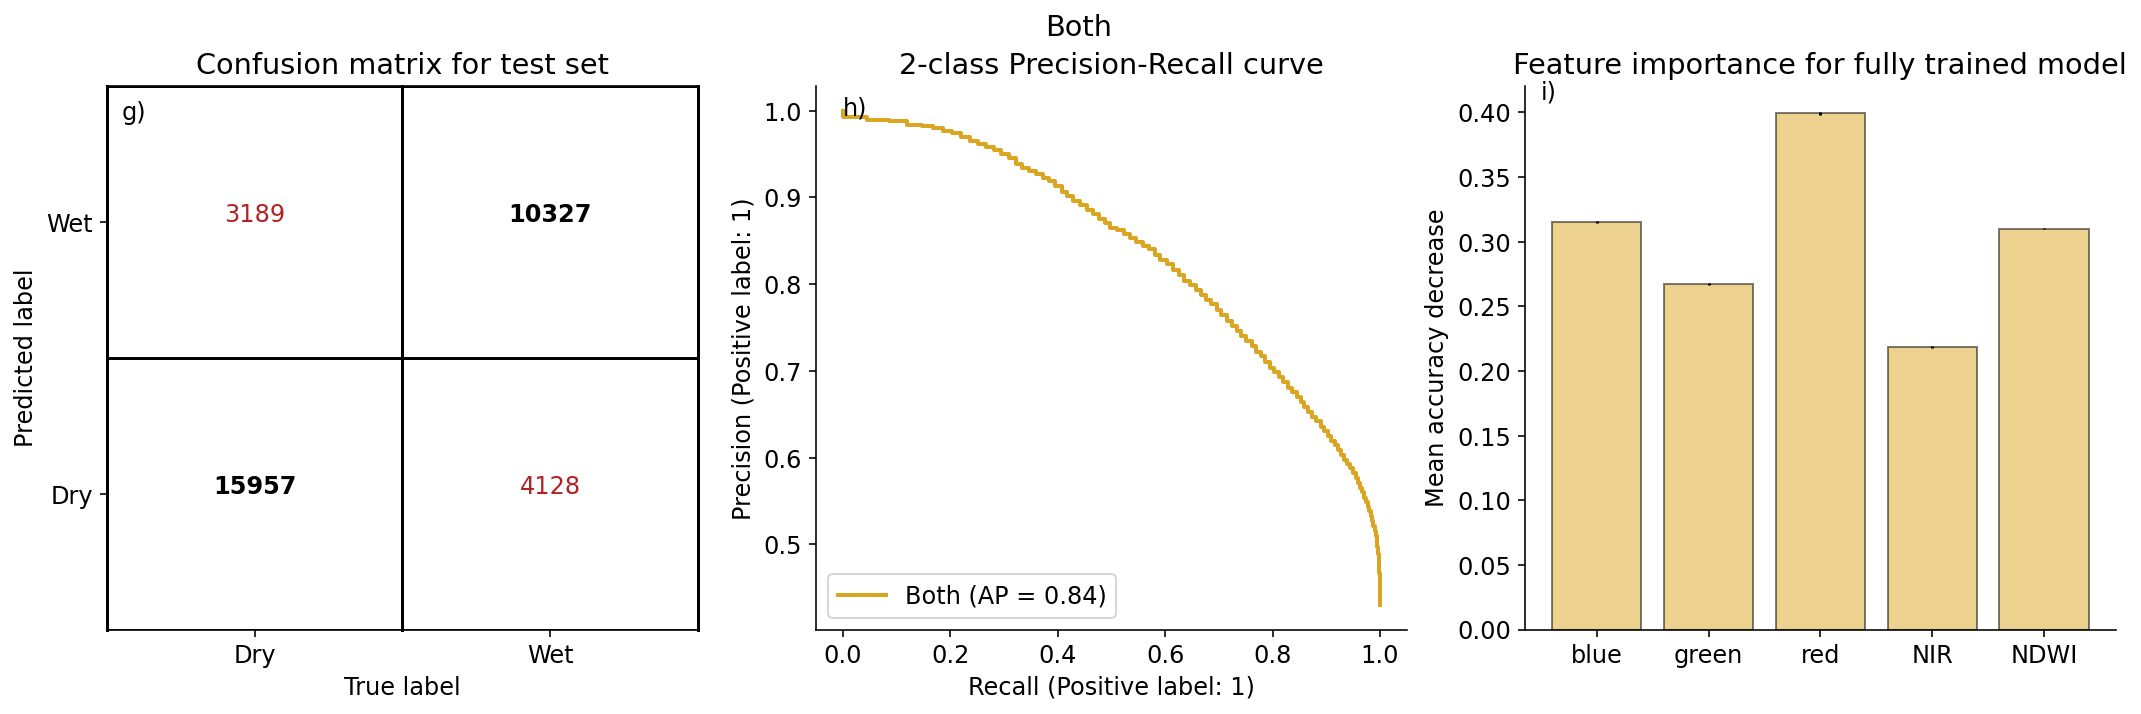

In [216]:
# confusion matrix with feature importance

# Manuscript figure; confusion matrix on test data

plt.rcParams.update({'font.size': 12})

ytest_predict = bothmodel_test.predict(Xtest1)
mat = confusion_matrix(ytest1, bothmodel_test.predict(Xtest1))


f,axs = plt.subplots(1, 3, figsize = (18,5))

ax = axs[0]
# sns.heatmap([[1,0],[0,1]], square=True, annot=False,fmt='d',
#             cbar=False,ax=ax, cmap='Blues')

xlocs = [0.5,1.5,0.5,1.5]
ylocs = [0.5,0.5,1.5,1.5,]
colors = ['k','firebrick','firebrick','k',]
for i in range(len(mat.T.flatten())):
  t = mat.T.flatten()[i]
  xloc = xlocs[i]
  yloc = ylocs[i]
  color = colors[i]
  print(t,xloc,yloc)
  if color==colors[1]:
        ax.text(xloc,yloc,t,ha='center',
          c=color,)
  else:
    ax.text(xloc,yloc,t,ha='center',
          c=color,weight='demibold')

ax.set_xlabel('True label')
ax.set_ylabel('Predicted label')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['Dry','Wet'])
ax.set_yticks([1.5,0.5])
ax.set_yticklabels(['Wet','Dry'])
for x in [0,1,2]:
  ax.plot([x,x],[0,2],c='k',clip_on=False)
for y in [0,1,2]:
  ax.plot([0,2],[y,y],c='k')
ax.set_title('Confusion matrix for test set')
ax.text(.05,1.875,'g)',c='k')
ax.set_xlim(0,2)
ax.set_ylim(0,2)

ax = axs[2]

labels = features1#['Blue','Green','Red','NIR','NDWI',]#'Area']
ax.bar(labels,forest_importances.values,
       yerr = result.importances_std,
       edgecolor = 'k',facecolor = 'goldenrod',alpha=.5)
ax.set_title("Feature importance for fully trained model")
ax.set_ylabel("Mean accuracy decrease")
ax.text(-.5,0.41,'i)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = axs[1]
from sklearn.metrics import PrecisionRecallDisplay
# fig,ax = plt.subplots(1)
display = PrecisionRecallDisplay.from_estimator(
    bothmodel_test, Xtest1, ytest1, name="Both", ax=ax, c = 'goldenrod',lw=2
)
_ = display.ax_.set_title("2-class Precision-Recall curve")
ax.spines[['top','right']].set_visible(False)
ax.text(0,.995,'h)')

# fig.tight_layout()

f.suptitle('Both')
plt.savefig('confusion_and_importance_both.pdf',format='pdf',bbox_inches='tight')

In [256]:
df1['date'] = pd.to_datetime(df1.date)
df1['extrapolatemonth'] = df1.date.dt.month
for m in [3,6,9,12]:
    df1['extrapolatemonth'] = np.where(abs(df1.extrapolatemonth-m)<=1,m,df1.extrapolatemonth)
df1['extrapolatemonth'] = np.where(df1.extrapolatemonth==1,12,df1.extrapolatemonth)
df1['assumption'] = np.where((df1.assumption!='assumed perennial'),
                           [df1.assumption.values[i]+' '+str(df1.extrapolatemonth.values[i]) for i in range(len(df1))],
                           df1.assumption)
df1['assumption'] = np.where(df1.assumption=='assumed perennial',
                            'assumed perennial Cienega',df1.assumption)

In [258]:
df1['assumption'] = np.where(df1.assumption=='assumed perennial',
                            'assumed perennial Cienega',df1.assumption)
subset = pd.concat([df,df1])
dates = set(subset.date)
subset['date'] = pd.to_datetime(subset.date)
assumptions = subset.assumption.unique()

date_accuracy = {}

for date in assumptions:
  print(date)
  mask_test1 = ''
  sub1 = subset.set_index('date').sort_index().reset_index()
  numscenes = 0
  mask_test = (sub1.assumption==date)
  if 'survey/imagery match' in date:
      mask_test1 = (mask_test) | (sub1.assumption==' '.join(['assumed dry',date.split()[-1]])) | (sub1.assumption==' '.join(['assumed wet',date.split()[-1]]))
  else:
      mask_test1 = mask_test

  Xtrain_date = sub1[~mask_test1][features]
  Xtest_date = sub1[mask_test][features]
  # print(len(Xtest_date))

  ytrain_date = sub1[~mask_test1]['wet']
  ytest_date = sub1[mask_test]['wet']
  date_model = RandomForestClassifier(random_state=42,max_depth=mdepth)
  date_model.fit(Xtrain_date, ytrain_date)
  try:
    date_accuracy.update({date: date_model.score(Xtest_date, ytest_date)})
  except:
    print(date,'fail')

survey/imagery match
assumed wet
assumed dry
assumed perennial
survey/imagery match 9
survey/imagery match 3
survey/imagery match 6
survey/imagery match 12
assumed wet 9
assumed wet 3
assumed wet 6
assumed wet 12
assumed perennial Cienega
assumed dry 6
assumed dry 3
assumed dry 12
assumed dry 9


In [259]:
date_accuracy

{'survey/imagery match': 0.8718424962852898,
 'assumed wet': 0.8181818181818182,
 'assumed dry': 0.7525865443767127,
 'assumed perennial': 0.05343511450381679,
 'survey/imagery match 9': 0.5829862425848794,
 'survey/imagery match 3': 0.5712482645462578,
 'survey/imagery match 6': 0.47011413425650456,
 'survey/imagery match 12': 0.5817872018174933,
 'assumed wet 9': 0.9273450207843846,
 'assumed wet 3': 0.7259419896991054,
 'assumed wet 6': 0.8699444885011896,
 'assumed wet 12': 0.6525061124694377,
 'assumed perennial Cienega': 0.6772120232459685,
 'assumed dry 6': 0.48142857142857143,
 'assumed dry 3': 0.3231409444544961,
 'assumed dry 12': 0.3895823331733077,
 'assumed dry 9': 0.29711751662971175}

In [260]:
df_alldates['month'] = df_alldates.date.dt.month
df_alldates['prediction_both'] = bothmodel.predict(df_alldates[features1])

In [261]:
# # train cienega model
# cmodel = RandomForestClassifier(random_state=42,max_depth=mdepth)
# cmodel.fit(df1[~df1.assumption.str.contains('perennial')][features1], 
#            df1[~df1.assumption.str.contains('perennial')].wet)
# # feature_names = [f"feature {i}" for i in range(X.shape[1])]
# # feature_names = X1.columns
# df1['predict_cienega'] = cmodel.predict(df1[features1])

In [262]:

df1_alldates = pd.read_csv('alldates_cienega.csv')
df1_alldates['date'] = pd.to_datetime(df1_alldates.date)
df1_alldates['prediction_both'] = bothmodel.predict(df1_alldates
                                                    [features1])

In [263]:
#load hydro data
hydro1 = pd.read_csv('../data/'+'Cienega'+'/'+'Cienega'+'HydroData.csv')
hydro1['datetime'] = pd.to_datetime(hydro1['datetime'])
hydro1.set_index('datetime',inplace=True)

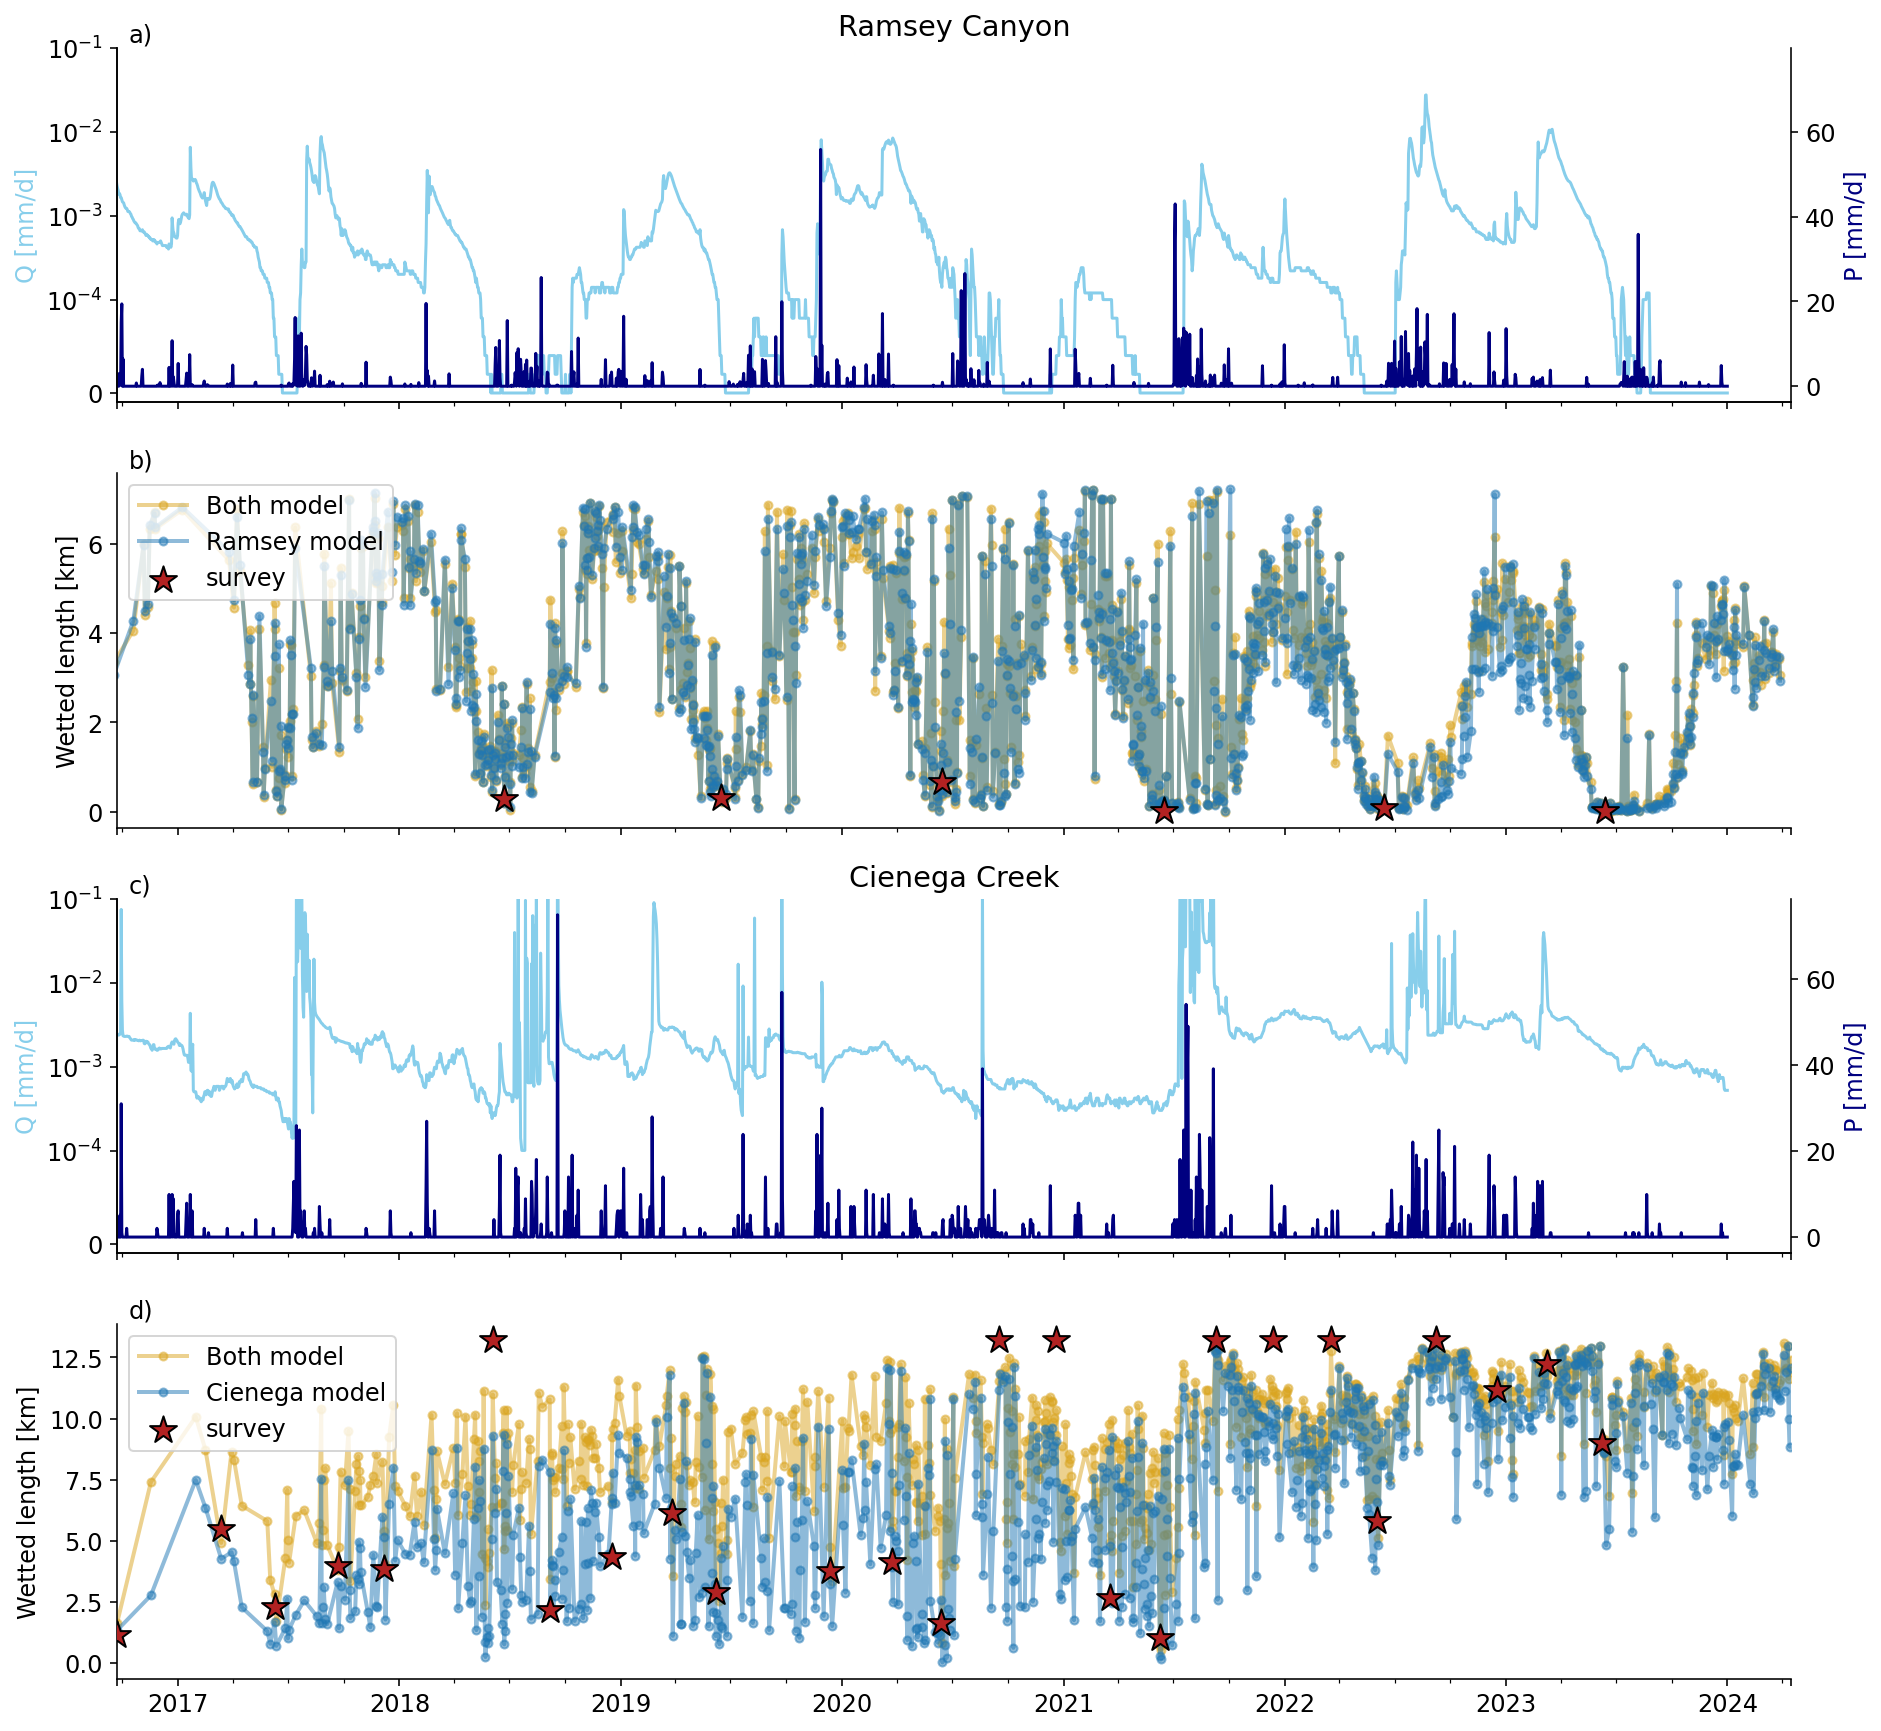

In [266]:
### Make Ramsey results figure

df_alldates['date'] = pd.to_datetime(df_alldates.date,format='%Y%m%d')

fig,axs = plt.subplots(4,figsize = (15,15),sharex=True)
ax = axs[0]
hydro['Q [mm/d]'].plot(ax=ax,c='skyblue')
ax.set_yscale('symlog',linthresh=0.0001)
ax.set_ylim(-.00001,0.1)
ax.set_ylabel('Q [mm/d]',c='skyblue')
axt = ax.twinx()
axt.spines['top'].set_visible(False)
hydro['P [mm]'].plot(ax=axt,c='navy')
axt.set_ylabel('P [mm/d]',c='navy')
# ax

ax = axs[1]
(df_alldates.groupby('date').prediction_both.sum()*5/1000).plot(ax=ax,lw=2,marker='o',
                                                                markersize = 4,label='Both model',c='goldenrod',
                                                               alpha=.5)
(df_alldates.groupby('date').predict.sum()*5/1000).plot(ax=ax,lw=2,marker='o',markersize = 4,label='Ramsey model',
                                                       alpha=.5)
ax.set_ylabel('Wetted length [km]')
survey_info = (df[(df.wetdry=='wet')&(df.assumption=='survey/imagery match')].groupby('date').wetdry.count()*5/1000).reset_index()
ax.scatter(survey_info.date.values,survey_info.wetdry.values,
           c='firebrick',marker='*',s=200,label='survey',zorder = 100,
          edgecolor = 'k')
ax.legend(loc='upper left')

ax.set_xlim('2016-10-01','2024-6-01')
axs[0].set_title('Ramsey Canyon')


axs[2].set_title('Cienega Creek')


ax = axs[2]
hydro1['Q [mm/d]'].plot(ax=ax,c='skyblue')
ax.set_yscale('symlog',linthresh=0.0001)
ax.set_ylim(-.00001,0.1)
ax.set_ylabel('Q [mm/d]',c='skyblue')
axt = ax.twinx()
axt.spines['top'].set_visible(False)
hydro1['P [mm]'].plot(ax=axt,c='navy')
axt.set_ylabel('P [mm/d]',c='navy')

ax = axs[3]
(df1_alldates.groupby('date').prediction_both.sum()*5/1000).plot(ax=ax,lw=2,marker='o',
                                                                markersize = 4,label='Both model',c='goldenrod',
                                                                alpha=.5)
(df1_alldates.groupby('date').predict.sum()*5/1000).plot(ax=ax,lw=2,marker='o',markersize = 4,label='Cienega model',
                                                         alpha=.5
                                                        )
ax.set_ylabel('Wetted length [km]')
survey_info = (df1[(df1.assumption.str.contains('imagery'))&(df1.wetdry=='wet')].groupby('date').count()*5/1000).reset_index()
ax.scatter(survey_info.date.values,survey_info.wetdry.values,
           c='firebrick',marker='*',s=200,label='survey',zorder = 100,
          edgecolor = 'k')
ax.legend(loc='upper left')
ax.set_xlabel('')


for ax in axs:
    ax.spines[['top','right']].set_visible(False)

labels = ['a)','b)','c)','d)']
for i, ax in enumerate(axs):
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
    ax.annotate(
        labels[i],
        xy=(0, 1.05), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        )

plt.savefig('ramsey_cienega_results.png',format='png',dpi=300,bbox_inches='tight')

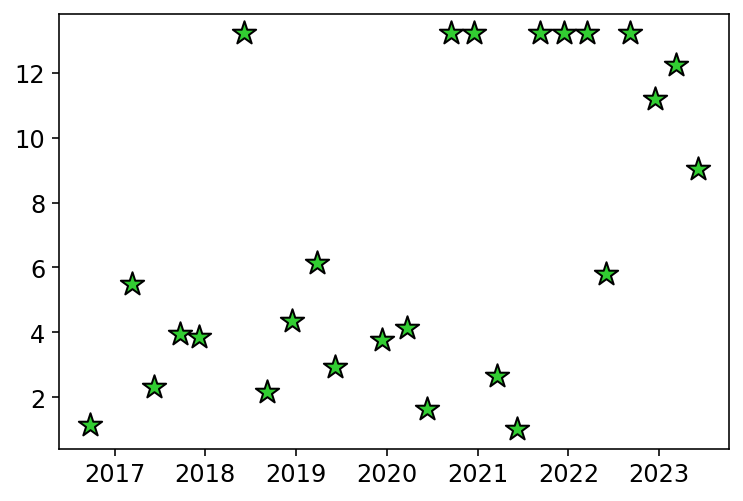

In [267]:
survey_info = (df1[(df1.assumption.str.contains('survey/imagery match'))&(df1.wet==1)].groupby(['date']).wetdry.count()*5/1000).reset_index()

plt.scatter(survey_info.date.values,survey_info.wetdry.values,
           c='limegreen',marker='*',s=150,label='survey',zorder = 100,
          edgecolor = 'k')

In [525]:
df['prediction_both'] = bothmodel.predict(df[features1])

In [268]:
survey_info

date  wetdry
0  2016-09-22   1.150
1  2017-03-13   5.495
2  2017-06-09   2.305
3  2017-09-21   3.960
4  2017-12-07   3.855
5  2018-06-04  13.205
6  2018-09-07   2.155
7  2018-12-17   4.355
8  2019-03-26   6.125
9  2019-06-07   2.920
10 2019-12-13   3.755
11 2020-03-24   4.150
12 2020-06-12   1.635
13 2020-09-17  13.205
14 2020-12-19  13.205
15 2021-03-19   2.665
16 2021-06-09   1.030
17 2021-09-10  13.205
18 2021-12-13  13.205
19 2022-03-18  13.205
20 2022-06-02   5.810
21 2022-09-07  13.205
22 2022-12-17  11.175
23 2023-03-10  12.245
24 2023-06-08   9.020